# Set up

In this experiment we observe the behaviour of different layer-wise training strategies and their weightingvariants under ideal circumstance where all clients are available and there is an IID distribution of data across clients.

In the following sections we will present the following group of strategies:

- Baseline strategies, that are the same as the ones in the original project presenting simple implementation of the FedAvg strategy as well as its FedPart based implementation.

- Both Momentum Strategies (FedAvgMom2) present strategies where the layer-wise first and second momentum are also communicated to the server alongside the client parameters. Using these momentum the server weights client parameters and momentums during aggregation based on cosine similarity to the central aggregated momentum of the previous (layer-wise) round. This section explores the effect of different weighting mechanisms using cosine similarity in order to fix some of the issues that could potentially arise with the original implementation. 

- Single Momentum strategies (FedAvgMom1) present strategies similar approach to the "Both Momentum Strategies" but with only using the first momentum as weighting factor for the client parameters and first momentum while using a simple average for the second momentum. It also explores the effect of different weighting mechanisms using cosine similarity.

- PseudoGradient strategy (FedPseudoGradientPartAvg) present a strategy where the average of the layer-wise pseudo-gradients is used to update the client parameters.

- PseudoGradient Similarity strategies (PSAP) is a new novel set of strategies which build on top of the PseudoGradient strategies by weighting the client parameters based on cosine similarity to the central model/layer pseudo-gradient of the previous (layer-wise) rounds.

- The Local Adam strategy present a comparison to the original implementation. It implements the Local Adam optimizer within the FedPart layer-wise training strategy that was a source of inspiration to our momentum based approach but was not presented in the original work.


In [1]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6


In [2]:
from flwr.simulation import run_simulation
from src.model import *
from src.dataset import load_datasets
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.client import ClientApp 
from src.Original.common import get_evaluate_fn
from src.visualize_data import *
import pickle
import logging
import glob
logging.getLogger("flwr").setLevel(logging.ERROR)
logging.getLogger("flwr.server").setLevel(logging.ERROR)
logging.getLogger("flwr.client").setLevel(logging.ERROR)
logging.getLogger("flwr.server.strategy").setLevel(logging.CRITICAL)
logging.getLogger("flwr.server.client_manager").setLevel(logging.CRITICAL)

In [3]:
experiment_type = "baseline"
all_results = {}

In [4]:
baseline_results = {}
fedavg_mom2_results = {}
fedavg_mom1_results = {}
pseudo_gradient_results = {}
pseudo_gradient_similarity_avg_results = {}
local_adam_results ={}



#### Load previously collected results -  only if had to restart the kernel

In [5]:
baseline_files = glob.glob('results/baseline_*.pkl')

for file_path in baseline_files:
    try:
        with open(file_path, 'rb') as f:
            results = pickle.load(f)
            key = file_path.split('baseline_')[1].replace('.pkl','')
            all_results[key] = results
        print(f"Successfully loaded {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")



Successfully loaded results/baseline_fedavgmom1.pkl
Successfully loaded results/baseline_pseudogradient_similarity_avg.pkl
Successfully loaded results/baseline_fedavgmom2.pkl
Successfully loaded results/baseline_baseline.pkl
Successfully loaded results/baseline_local_adam_results.pkl
Successfully loaded results/baseline_pseudogradient.pkl


In [6]:
baseline_results = all_results["baseline"]
fedavg_mom2_results = all_results["fedavgmom2"]
fedavg_mom1_results = all_results["fedavgmom1"]
pseudo_gradient_results = all_results["pseudogradient"]
pseudo_gradient_similarity_avg_results = all_results["pseudogradient_similarity_avg"]
local_adam_results = all_results["local_adam_results"]




# Baselines

This section presents the baseline results for the original project. It includes 2 strategies:

- FedAvg
- FedPart based on FedAvg (FedPartAvg)

The FedPart based strategies perform a layer-wise training strategy where in each round only a specific layer is trained (after some warm up full network training rounds).



## FedAvg


In [5]:
from src.Original.FedAvg.strategy import CustomFedAvg
from src.Original.FedAvg.client import get_fedavg_client_fn

In [6]:

fedavg_client_fn = get_fedavg_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_client_fn)
net = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, net)

custom_fed_avg_strategy = CustomFedAvg(evaluate_fn=evaluate_fn)

def fedavg_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=custom_fed_avg_strategy,
    )

server = ServerApp(server_fn=fedavg_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=82643) [Client 0] fit, config: {}
(ClientAppActor pid=82643) Epoch 1: train loss 0.06527859717607498, accuracy 0.20053997300134993
(ClientAppActor pid=82639) [Client 4] fit, config: {} [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=82643) Epoch 3: train loss 0.0540439710021019, accuracy 0.3319334033298335 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.048913028091192245, accuracy 0.4127793610319484 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.04417910799384117, accuracy 0.48207589620518976 [repeated 12x across cluster]
  Evaluation results - Loss: 0.0661, Accuracy: 0.2508


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=82642) [Client 2] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.04032789543271065, accuracy 0.521902190219022 [repeated 11x across cluster]
(ClientAppActor pid=82638) [Client 1] fit, config: {}
(ClientAppActor pid=82643) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.05073714256286621, accuracy 0.39058047097645116
(ClientAppActor pid=82640) Epoch 1: train loss 0.04971220716834068, accuracy 0.40324032403240323
(ClientAppActor pid=82639) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 3: train loss 0.04241682589054108, accuracy 0.5054747262636868 [repeated 11x across cluster]
(ClientAppActor pid=82640) Epoch 5: train loss 0.0362984761595726, accuracy 0.5723072307230723 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.030203139409422874, accuracy 0.6511174441277936 [repeated 12x across cluster]
  Evaluation result

(ClientAppActor pid=82641) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82641)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 0] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.02634155936539173, accuracy 0.6957695769576958 [repeated 11x across cluster]
(ClientAppActor pid=82643) [Client 0] fit, config: {}
(ClientAppActor pid=82643) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 1: train loss 0.0399390272796154, accuracy 0.5424542454245425
(ClientAppActor pid=82639) Epoch 1: train loss 0.038804586976766586, accuracy 0.5532553255325533
(ClientAppActor pid=82642) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.03044109418988228, accuracy 0.6498649864986499 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.024841919541358948, accuracy 0.7204139793010349 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.018943792209029198, accuracy 0.7798110094495275 [repeated 12x across cluster]
  Evaluation resul

(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 3] evaluate, config: {}
(ClientAppActor pid=82642) Epoch 8: train loss 0.01600741781294346, accuracy 0.8204320432043204 [repeated 11x across cluster]
(ClientAppActor pid=82639) [Client 5] fit, config: {}
(ClientAppActor pid=82643) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 1: train loss 0.03569155931472778, accuracy 0.5951095109510951
(ClientAppActor pid=82641) Epoch 1: train loss 0.036666907370090485, accuracy 0.5837083708370837
(ClientAppActor pid=82642) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.023618515580892563, accuracy 0.7322232223222322 [repeated 12x across cluster]
(ClientAppActor pid=82641) Epoch 5: train loss 0.01841815374791622, accuracy 0.7908790879087909 [repeated 11x across cluster]
(ClientAppActor pid=82639) Epoch 7: train loss 0.011942131444811821, accuracy 0.8642364236423642 [repeated 12x across cluster]
  Evaluation resu

(ClientAppActor pid=82641) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82641)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 2] fit, config: {}
(ClientAppActor pid=82638) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.03427933156490326, accuracy 0.6257687115644218
(ClientAppActor pid=82639) Epoch 1: train loss 0.032948609441518784, accuracy 0.6452145214521452
(ClientAppActor pid=82643) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 3: train loss 0.02013416588306427, accuracy 0.7714114294285286 [repeated 11x across cluster]
(ClientAppActor pid=82638) Epoch 5: train loss 0.013199911452829838, accuracy 0.8513574321283935 [repeated 12x across cluster]
(ClientAppActor pid=82642) Epoch 7: train loss 0.009532446041703224, accuracy 0.8981398139813982 [repeated 14x across cluster]
  Evaluation results - Loss: 0.0597, Accuracy: 0.5681


(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 5] evaluate, config: {}
(ClientAppActor pid=82643) Epoch 8: train loss 0.007753266952931881, accuracy 0.9108910891089109 [repeated 9x across cluster]
(ClientAppActor pid=82641) [Client 0] fit, config: {}
(ClientAppActor pid=82641) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 1: train loss 0.03106367401778698, accuracy 0.6572671366431678
(ClientAppActor pid=82643) Epoch 1: train loss 0.029375480487942696, accuracy 0.6765676567656765
(ClientAppActor pid=82639) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.015143487602472305, accuracy 0.8276327632763276 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.009478224441409111, accuracy 0.8972397239723973 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.00668540270999074, accuracy 0.9296429642964297 [repeated 12x across cluster]
  Evaluation resu

(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 1] evaluate, config: {}
(ClientAppActor pid=82641) Epoch 8: train loss 0.006833110004663467, accuracy 0.9299535023248837 [repeated 11x across cluster]
(ClientAppActor pid=82641) [Client 2] fit, config: {}
(ClientAppActor pid=82643) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.02793453074991703, accuracy 0.6887188718871887
(ClientAppActor pid=82640) Epoch 1: train loss 0.02711504139006138, accuracy 0.7073207320732073
(ClientAppActor pid=82643) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 3: train loss 0.012667493894696236, accuracy 0.8613861386138614 [repeated 15x across cluster]
(ClientAppActor pid=82639) Epoch 6: train loss 0.006547063123434782, accuracy 0.929042904290429 [repeated 14x across cluster]
(ClientAppActor pid=82641) Epoch 8: train loss 0.005585251376032829, accuracy 0.9450945094509451 [repeated 15x across cluster]
  Evaluation resu

(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82641) [Client 0] evaluate, config: {}
(ClientAppActor pid=82640) [Client 3] fit, config: {}
(ClientAppActor pid=82638) Epoch 8: train loss 0.006596024613827467, accuracy 0.9264926492649265 [repeated 2x across cluster]
(ClientAppActor pid=82639) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82642) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 2: train loss 0.014859902672469616, accuracy 0.8284085795710214 [repeated 7x across cluster]
(ClientAppActor pid=82643) Epoch 4: train loss 0.007543807849287987, accuracy 0.9160041997900105 [repeated 12x across cluster]
(ClientAppActor pid=82643) Epoch 6: train loss 0.0060483836568892, accuracy 0.9301034948252588 [repeated 12x across cluster]
(ClientAppActor pid=82640) Epoch 8: train loss 0.005243263207376003, accuracy 0.9438943894389439 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0707, Accuracy: 0.5680


(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82643) [Client 5] evaluate, config: {}
(ClientAppActor pid=82639) [Client 3] fit, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.005189189687371254, accuracy 0.9428528573571321 [repeated 4x across cluster]
(ClientAppActor pid=82641) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82640) Epoch 2: train loss 0.011379778385162354, accuracy 0.8732563371831409 [repeated 11x across cluster]
(ClientAppActor pid=82641) Epoch 4: train loss 0.008207757957279682, accuracy 0.9154042297885105 [repeated 13x across cluster]
(ClientAppActor pid=82639) Epoch 7: train loss 0.005266991909593344, accuracy 0.9431443144314432 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0733, Accuracy: 0.5702
(ClientAppActor pid=82643) [Client 3] evaluate, config: {}
(ClientAppActor pid=82641) Epoch 8: train loss 0.006011747755110264, accuracy 0.9379031048447578

(ClientAppActor pid=82643) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82643)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82638) [Client 1] fit, config: {}
(ClientAppActor pid=82640) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.02136220410466194, accuracy 0.7721613919304035
(ClientAppActor pid=82642) Epoch 1: train loss 0.02114233374595642, accuracy 0.7743774377437744
(ClientAppActor pid=82641) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82640) Epoch 3: train loss 0.008359121158719063, accuracy 0.9077546122693866 [repeated 14x across cluster]
(ClientAppActor pid=82641) Epoch 5: train loss 0.005492330063134432, accuracy 0.936993699369937 [repeated 14x across cluster]
(ClientAppActor pid=82642) Epoch 8: train loss 0.004337646067142487, accuracy 0.9551455145514551 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0744, Accuracy: 0.5685
(ClientAppActor pid=82643) [Client 1] evaluate, config: {}


(ClientAppActor pid=82643) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82643)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82641) Epoch 8: train loss 0.004695575684309006, accuracy 0.9498949894989499 [repeated 5x across cluster]
(ClientAppActor pid=82641) [Client 2] fit, config: {}
(ClientAppActor pid=82642) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 1: train loss 0.019442368298768997, accuracy 0.7866786678667866 [repeated 3x across cluster]
(ClientAppActor pid=82638) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 4: train loss 0.005377636291086674, accuracy 0.9432943294329433 [repeated 16x across cluster]
(ClientAppActor pid=82638) Epoch 6: train loss 0.0051133763045072556, accuracy 0.9446444644464447 [repeated 17x across cluster]
  Evaluation results - Loss: 0.0732, Accuracy: 0.5723
(ClientAppActor pid=82641) [Client 1] evaluate, config: {}
(ClientAppActor pid=82638) Epoch 8: train loss 0.004047091118991375, accuracy 0.9615961596159616 [repeated 12x across cluster]


(ClientAppActor pid=82641) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82641)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 2] fit, config: {}
(ClientAppActor pid=82642) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 1: train loss 0.0184932854026556, accuracy 0.7982298229822983
(ClientAppActor pid=82642) Epoch 1: train loss 0.01985125057399273, accuracy 0.7933103344832758
(ClientAppActor pid=82640) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 3: train loss 0.006422119680792093, accuracy 0.933993399339934 [repeated 13x across cluster]
(ClientAppActor pid=82643) Epoch 5: train loss 0.004433020483702421, accuracy 0.951552422378881 [repeated 13x across cluster]
(ClientAppActor pid=82642) Epoch 8: train loss 0.0034738737158477306, accuracy 0.9629518524073797 [repeated 15x across cluster]
  Evaluation results - Loss: 0.0779, Accuracy: 0.5673


(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82638) [Client 3] evaluate, config: {}
(ClientAppActor pid=82643) Epoch 8: train loss 0.0033747078850865364, accuracy 0.9650517474126293 [repeated 5x across cluster]
(ClientAppActor pid=82643) [Client 3] fit, config: {}
(ClientAppActor pid=82640) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.018180644139647484, accuracy 0.8066306630663066
(ClientAppActor pid=82642) Epoch 1: train loss 0.01636688783764839, accuracy 0.8276586170691466
(ClientAppActor pid=82640) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82641) Epoch 3: train loss 0.005800232756882906, accuracy 0.9381938193819382 [repeated 15x across cluster]
(ClientAppActor pid=82642) Epoch 6: train loss 0.004254041239619255, accuracy 0.9571021448927554 [repeated 14x across cluster]
(ClientAppActor pid=82639) Epoch 8: train loss 0.0026921965181827545, accuracy 0.9741974197419742 [repeated 14x across cluster]
  Evaluation r

(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82643) [Client 4] evaluate, config: {}
(ClientAppActor pid=82643) [Client 5] fit, config: {}
(ClientAppActor pid=82640) Epoch 8: train loss 0.003953305073082447, accuracy 0.9607019649017549 [repeated 3x across cluster]
(ClientAppActor pid=82639) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 2: train loss 0.006788215134292841, accuracy 0.9295035248237589 [repeated 12x across cluster]
(ClientAppActor pid=82642) Epoch 5: train loss 0.003853517584502697, accuracy 0.9585958595859586 [repeated 13x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.00304558128118515, accuracy 0.9681968196819682 [repeated 13x across cluster]
  Evaluation results - Loss: 0.0784, Accuracy: 0.5737


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82641) [Client 2] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.003143619978800416, accuracy 0.9688015599220039 [repeated 10x across cluster]
(ClientAppActor pid=82641) [Client 4] fit, config: {}
(ClientAppActor pid=82638) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.015476971864700317, accuracy 0.8364836483648365
(ClientAppActor pid=82641) Epoch 1: train loss 0.014666344970464706, accuracy 0.8445844584458446
(ClientAppActor pid=82640) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.006140510551631451, accuracy 0.9348934893489349 [repeated 11x across cluster]
(ClientAppActor pid=82639) Epoch 5: train loss 0.0038604033179581165, accuracy 0.9551455145514551 [repeated 13x across cluster]
(ClientAppActor pid=82640) Epoch 7: train loss 0.0031238195952028036, accuracy 0.9662466246624662 [repeated 16x across cluster]
  Evaluation

(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82642) [Client 5] evaluate, config: {}
(ClientAppActor pid=82640) Epoch 8: train loss 0.002334855729714036, accuracy 0.975997599759976 [repeated 6x across cluster]
(ClientAppActor pid=82639) 
(ClientAppActor pid=82643) [Client 2] fit, config: {}
(ClientAppActor pid=82639) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 1: train loss 0.014422590844333172, accuracy 0.8507350735073508
(ClientAppActor pid=82641) Epoch 1: train loss 0.014557329006493092, accuracy 0.8492349234923492
(ClientAppActor pid=82639) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 3: train loss 0.004546739161014557, accuracy 0.9574021298935054 [repeated 16x across cluster]
(ClientAppActor pid=82642) Epoch 6: train loss 0.0025235197972506285, accuracy 0.9735973597359736 [repeated 13x across cluster]
(ClientAppActor pid=82643) Epoch 8: train loss 0.003412020392715931, accuracy 0.9645964596459646 [repeated 13x acr

(ClientAppActor pid=82639) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82639)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82639) [Client 0] evaluate, config: {}
(ClientAppActor pid=82639) [Client 5] fit, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.002734103938564658, accuracy 0.9721013949302535 [repeated 4x across cluster]
(ClientAppActor pid=82642) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82642) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82639) Epoch 2: train loss 0.004934981465339661, accuracy 0.9506450645064507 [repeated 7x across cluster]
(ClientAppActor pid=82643) Epoch 4: train loss 0.004128436557948589, accuracy 0.9567956795679567 [repeated 13x across cluster]
(ClientAppActor pid=82639) Epoch 6: train loss 0.003598632290959358, accuracy 0.965946594659466 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 8: train loss 0.0032159718684852123, accuracy 0.9660966096609661 [repeated 14x across cluster]
  Evaluation results - Loss: 0.0828, Accuracy: 0.5687


(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82640) [Client 5] evaluate, config: {}
(ClientAppActor pid=82642) Epoch 8: train loss 0.0039262003265321255, accuracy 0.9620518974051298 [repeated 3x across cluster]
(ClientAppActor pid=82638) [Client 0] fit, config: {}
(ClientAppActor pid=82638) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82638) Epoch 1: train loss 0.012778116390109062, accuracy 0.8669566521673916
(ClientAppActor pid=82641) Epoch 1: train loss 0.011726907454431057, accuracy 0.875937593759376
(ClientAppActor pid=82642) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=82643) Epoch 3: train loss 0.003213374176993966, accuracy 0.9662516874156292 [repeated 12x across cluster]
(ClientAppActor pid=82638) Epoch 5: train loss 0.0028081927448511124, accuracy 0.9712014399280036 [repeated 11x across cluster]
(ClientAppActor pid=82643) Epoch 7: train loss 0.003970359917730093, accuracy 0.9583020848957552 [repeated 12x across cluster]
  Evaluation r

(ClientAppActor pid=82640) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82640)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82642) [Client 5] evaluate, config: {}
(ClientAppActor pid=82639) Epoch 8: train loss 0.0028430093079805374, accuracy 0.9738973897389739 [repeated 11x across cluster]
(ClientAppActor pid=82638) [Client 3] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=82638) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=82638)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [7]:
fedavg_results=custom_fed_avg_strategy.get_results()
baseline_results['fedavg'] = fedavg_results

## FedPartAvg

In [8]:
from src.FedPart.FedAvg.client import get_fedpart_avg_client_fn
from src.FedPart.FedAvg.strategy import FedPartAvg

In [9]:
fedpartavg_client_fn = get_fedpart_avg_client_fn(load_datasets)
client = ClientApp(client_fn=fedpartavg_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedpart_avg_strategy = FedPartAvg(evaluate_fn=evaluate_fn)

def fedpartavg_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedpart_avg_strategy,
    )

server = ServerApp(server_fn=fedpartavg_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93089) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93089) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93089) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=93088) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=93088)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=93088) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93088) [Client 0] initialized
(ClientAppActor pid=93088) [Client 0] evaluate
(ClientAppActor pid=93088) Epoch 8: train loss 0.04518799111247063, accuracy 0.44757762111894406 [repeated 3x across cluster]
(ClientAppActor pid=93088) [Client 1] get_parameters


(ClientAppActor pid=93084) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93084) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=93084) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93084) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93084) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93084) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93084) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93084) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93084) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93084) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93084) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93084) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93084) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93084) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93084) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93084) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93084) Layer 14 (fc7.weight) i

(ClientAppActor pid=93084) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93084)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93088) Epoch 1: train loss 0.05066123977303505, accuracy 0.3933393339333933
(ClientAppActor pid=93085) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=93085) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=93085) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=93089) Epoch 3: train loss 0.041647639125585556, accuracy 0.5099009900990099 [repeated 12x across cluster]
(ClientAppActor pid=93088) Epoch 5: train loss 0.03636186942458153, accuracy 0.5670567056705671 [repeated 12x across cluster]
(ClientAppActor pid=93089) Epoch 7: train loss 0.029550772160291672, accuracy 0.653015301530153 [repeated 12x across cluster]
(ClientAppActor pid=93088) [Client 5] get_parameters
total size: 7449672
aggregated weight size 16 
  Evaluation results - Loss: 0.0446, Accuracy: 0.5131


(ClientAppActor pid=93087) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 3x across cluster]
(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93086) [Client 3] initialized
(ClientAppActor pid=93086) [Client 3] evaluate
(ClientAppActor pid=93085) Epoch 8: train loss 0.026133671402931213, accuracy 0.6973151342432878 [repeated 11x across cluster]
(ClientAppActor pid=93085) [Client 5] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=93085) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93085) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93085) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93085) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93085) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93085) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93085) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93085) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93085) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93085) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93085) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93085) Layer 11 

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93089) [Client 0] evaluate
(ClientAppActor pid=93089) [Client 4] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93089) Layer 13 (fc5.bias) i

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 4] initialized
(ClientAppActor pid=93089) [Client 4] evaluate
(ClientAppActor pid=93087) Epoch 8: train loss 0.03912045806646347, accuracy 0.5597059705970597 [repeated 17x across cluster]
(ClientAppActor pid=93087) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=93087) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93087) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93087) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93087) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93087) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93087) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93087) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93087) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93087) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93087) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93088) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93088) Epoch 8: train loss 0.03600849211215973, accuracy 0.5861086108610861 [repeated 5x across cluster]
(ClientAppActor pid=93088) [Client 1] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=93088) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93088) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93088) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93088) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93088) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93088) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93088) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93088) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93088) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93088) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93088) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93088) Layer 11 (fc4.bias) is froz

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 4] initialized
(ClientAppActor pid=93089) [Client 4] evaluate
(ClientAppActor pid=93084) 
(ClientAppActor pid=93089) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=93084) Epoch 8: train loss 0.035874150693416595, accuracy 0.591870406479676 [repeated 5x across cluster]
(ClientAppActor pid=93084) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93085) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93089) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93086) [Client 4] initialized
(ClientAppActor pid=93086) [Client 4] evaluate
(ClientAppActor pid=93084) Epoch 8: train loss 0.014874345622956753, accuracy 0.8689065546722664 [repeated 17x across cluster]
(ClientAppActor pid=93088) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) [Client 2] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=93088) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93088)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93088) [Client 3] fit, config: {'trainable_layers': 3, 'updated_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=93088) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=93088) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=93088) [Client 3] initialized
(ClientAppActor pid=93084) Epoch 4: train loss 0.028258783742785454, accuracy 0.6854657267136643 [repeated 19x across cluster]
(ClientAppActor pid=93086) [Client 5] get_parameters
(ClientAppActor pid=93086) Epoch 8: train loss 0.025331800803542137, accuracy 0.7143714371437143 [repeated 19x across cluster]
total size: 2433504
aggregated weight size 2 
updateing layers 6  and 7 
  Evaluation results - Loss: 0.0400, Accuracy: 0.5717
(ClientAppActor pid=93085) [Client 1] initialized
(ClientAppActor pid=93085) [Client 1] evaluate
(ClientAppActor pid=93088) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93088) Epoch 8: 

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93087) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93087)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93085) [Client 2] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=93085) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93085) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93085) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93085) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93085) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93085) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93085) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93085) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93085) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93085) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93085) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93085) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93085) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93085) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93085) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93085) La

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93089) [Client 0] evaluate
(ClientAppActor pid=93089) Epoch 8: train loss 0.023513713851571083, accuracy 0.7311731173117312 [repeated 8x across cluster]
(ClientAppActor pid=93089) [Client 4] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93086) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=93086) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93086) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93086) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93086) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93086) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93086) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93086) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93086) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93086) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93086) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93086) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93086) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93086) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93086) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93086) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93086) La

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93086) [Client 4] initialized
(ClientAppActor pid=93086) [Client 4] evaluate
(ClientAppActor pid=93087) Epoch 8: train loss 0.026787782087922096, accuracy 0.6902654867256637 [repeated 7x across cluster]
(ClientAppActor pid=93087) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93089) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is trainable
(ClientAppActor

(ClientAppActor pid=93087) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93087)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93088) [Client 0] initialized
(ClientAppActor pid=93088) [Client 0] evaluate
(ClientAppActor pid=93088) Epoch 8: train loss 0.026671675965189934, accuracy 0.6965196519651965 [repeated 17x across cluster]
(ClientAppActor pid=93089) [Client 5] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93089) Layer 11 (fc4

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93088) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 3] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=93087) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93087) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93087) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93087) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93087) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93087) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93087) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93087) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93087) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93087) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93087) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93087) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93087) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93087) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93086) [Client 4] initialized
(ClientAppActor pid=93086) [Client 4] evaluate
(ClientAppActor pid=93085) Epoch 8: train loss 0.02735867165029049, accuracy 0.6863186318631863 [repeated 6x across cluster]
(ClientAppActor pid=93085) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93086) [Client 2] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=93084) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93084) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93084) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93084) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93084) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93084) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93084) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93084) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93084) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93084) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93

(ClientAppActor pid=93086) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93086)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93086) [Client 3] initialized
(ClientAppActor pid=93086) [Client 3] evaluate
(ClientAppActor pid=93089) Epoch 8: train loss 0.02834496833384037, accuracy 0.6773661316934153 [repeated 17x across cluster]
(ClientAppActor pid=93089) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93088) [Client 5] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=93088) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93088) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93088) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93088) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93088) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93088) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93088) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93088) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93088) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93088) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=9

(ClientAppActor pid=93085) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93085)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 3] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93089) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93089) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93089) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93089) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93089) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93089) Layer

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 1] initialized
(ClientAppActor pid=93089) [Client 1] evaluate
(ClientAppActor pid=93084) Epoch 8: train loss 0.027346991002559662, accuracy 0.6846684668466847 [repeated 13x across cluster]
(ClientAppActor pid=93084) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93085) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=93089) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93089) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93089) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93089) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93089) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93089) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93089) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93089) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93089) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93089) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=93089) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93089)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93089) [Client 0] initialized
(ClientAppActor pid=93086) Epoch 8: train loss 0.02759997360408306, accuracy 0.6848184818481848 [repeated 18x across cluster]
(ClientAppActor pid=93085) [Client 2] evaluate
(ClientAppActor pid=93089) 
(ClientAppActor pid=93086) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=93087) [Client 3] evaluate [repeated 5x across cluster]


(ClientAppActor pid=93087) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=93087)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [10]:
fedpartavg_results=fedpart_avg_strategy.get_results()
baseline_results['fedpartavg'] = fedpartavg_results


## Summary

### Accuracy and Loss per Round

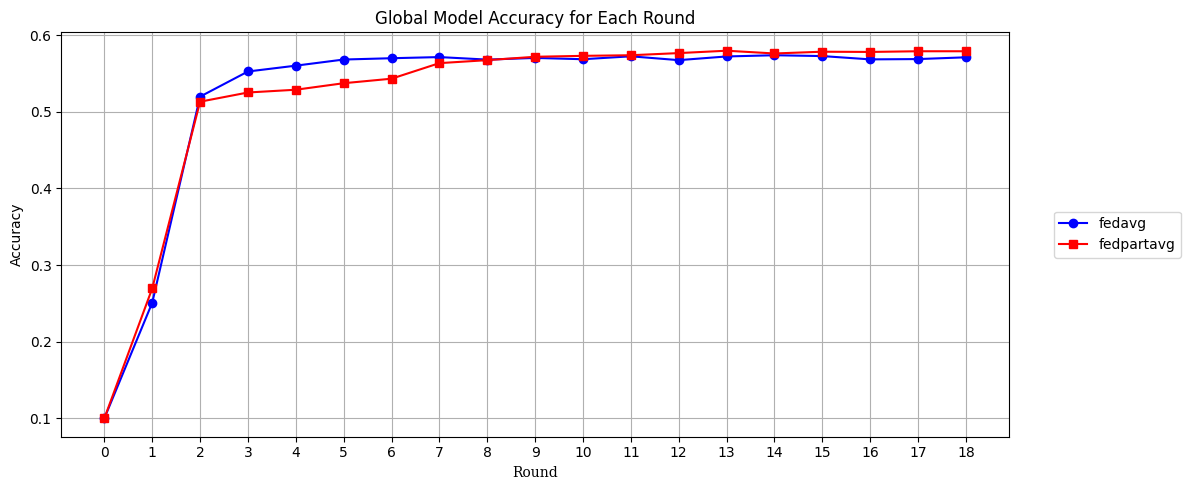

In [7]:
plot_accuracy_per_round(baseline_results)

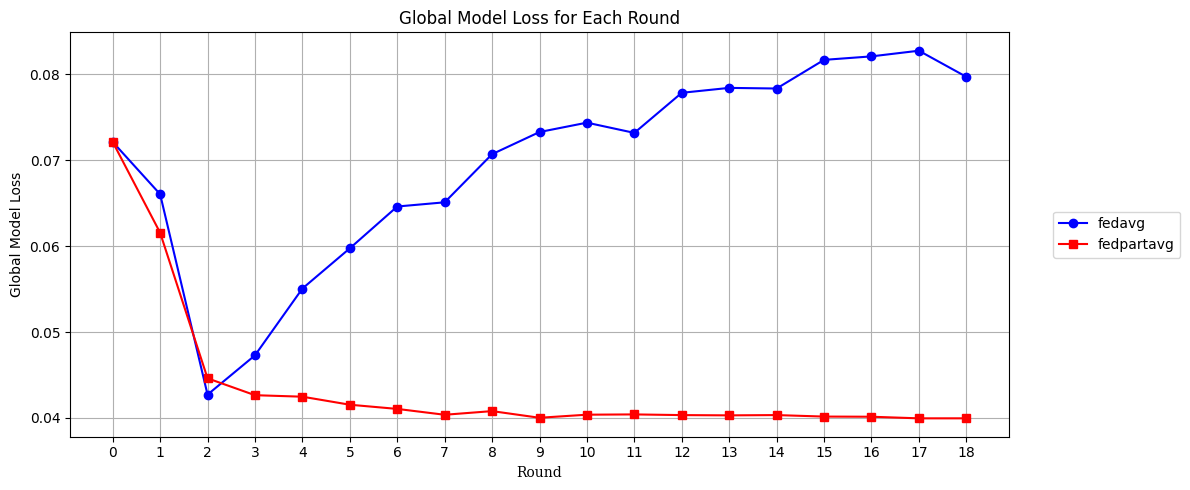

In [8]:
plot_loss_per_round(baseline_results)

As shown in both accuracy and loss plots, FedPartAvg performs better than FedAvg under ideal circumstances. It is capable achieving better accuracy by minimizing the layer-mismatching problem shown by Wang et al.

### Communication cost 

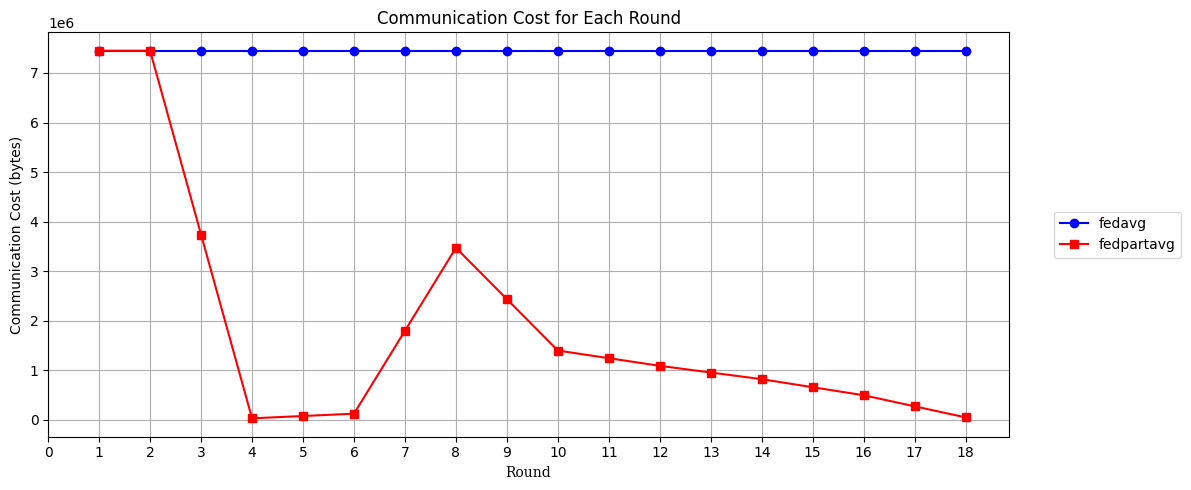

In [9]:
plot_communication_cost_per_round(baseline_results)

The communication cost per round clearly shows the advantage of FedPart based strategies where after the initial (in this case 2) warm up round the communication cost is significantly lower than the FedAvg based strategies.

/Users/macbook/Desktop/L46/L46_Project/src/visualize_data.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')


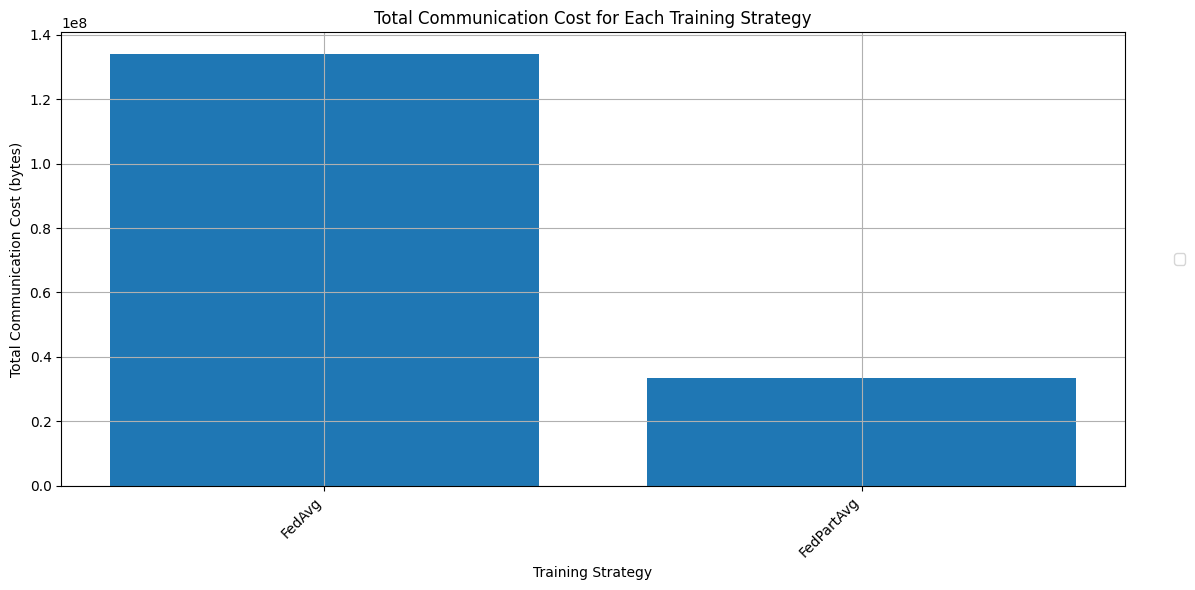

In [10]:
plot_total_communication_cost_bar_chart(baseline_results)

The layer-wise communication of updates hence also shows a significantly lower total communication cost for training.

### Parameter Differences Across Rounds













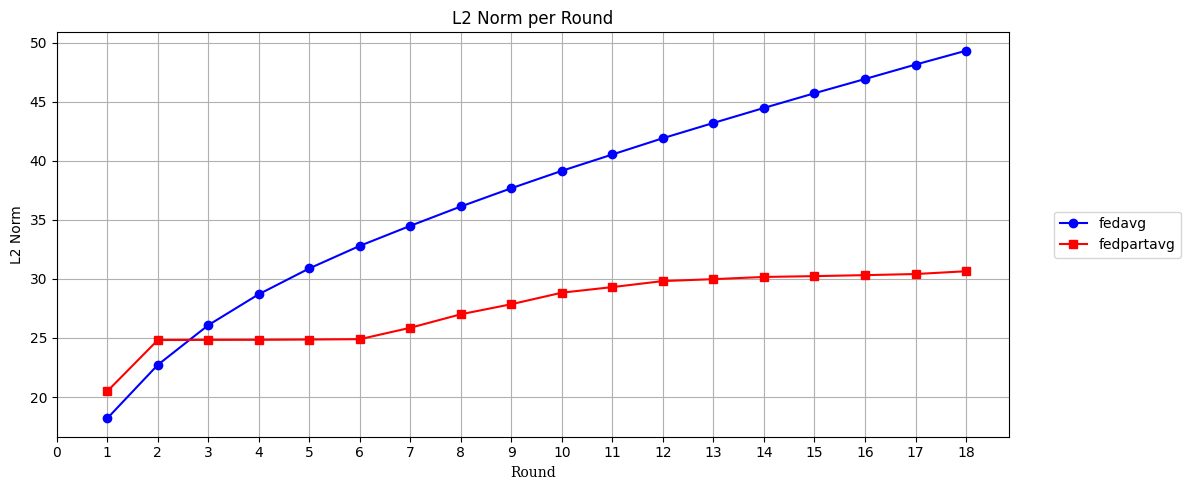

In [11]:
plot_l2_norm_per_round(baseline_results)

The figure above presents the L2 norm of the model parameters of the central model for each round. As shown FedAvg exhibits a steeper curve over time which means that the parameters of the central model are changing in bigger steps compared to FedPartAvg. These larger steps caused by the larger amount of parameter sharing of FedAvg compared to FedPartAvg which allows FedAvg to extract more information from the clients at the potential cost of the layer mismatch problem which can cause a trickle down effect across all layers when parameters are aggregated and then further trained.  

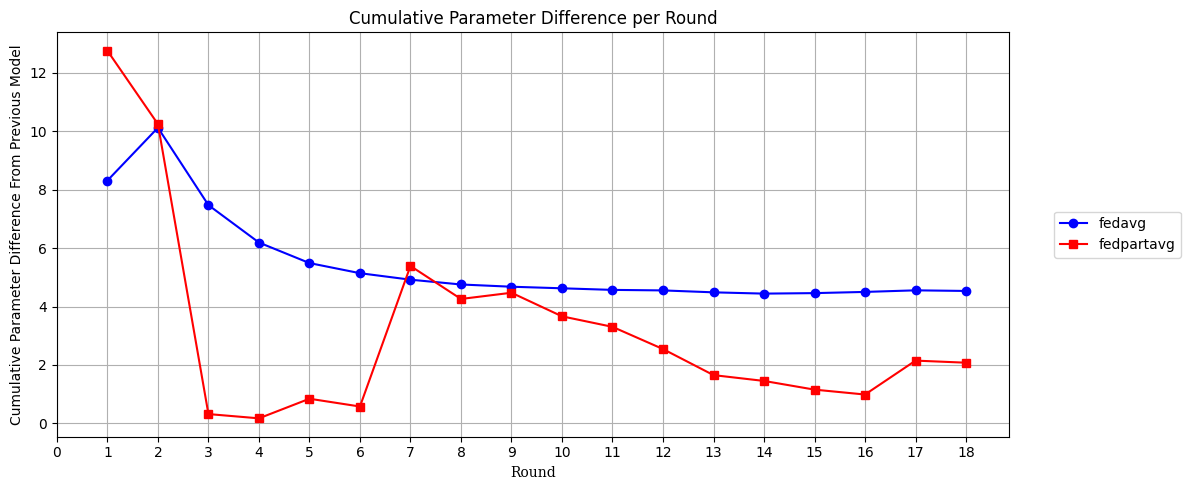

In [12]:
plot_parameter_difference_per_round(baseline_results)

The smaller step size for FedPart is also shown in the the difference between the parameters of the central model across round. As shown in the plots, the parameter differences across rounds decline steeply in the earlier rounds and stay relatively small for more shallow layers that are responsible for feature extraction hence do not change much. Between round 6 and 9 we can see and increase the difference since in those rounds the more dense layers are being updated resulting in larger changes in the parameters. On the other hand, FedAvg presents a relatively more stable decline but larger changes in the parameters caused, which is again cause by the layer-mismatching problem.

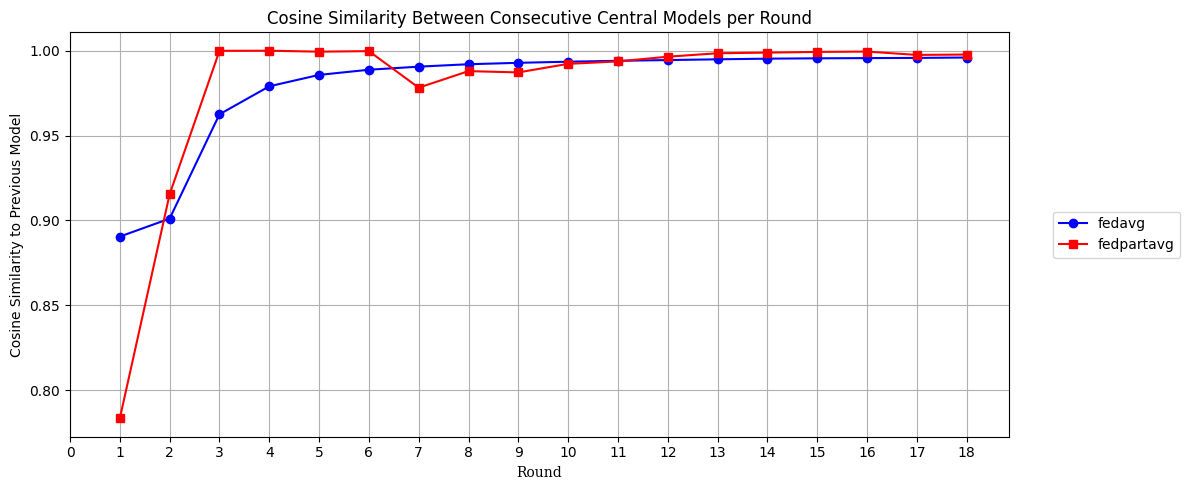

In [13]:
plot_cosine_similarity_per_round(baseline_results)

The larger change in the parameters are also presented in the figure above that depicts the cosine similarity between the current central model parameters compared to the previous round central model parameters. As shown in the figure, the cosine similarity is higher when the parameters are more similar to the previous round of the central model parameters. In the figure we can see a decrease in the cosine similarity between round 7 and 10 for FedPartAvg which is when the denser layers are trained. Meanwhile FedAvg shows a more stable increase in cosine similarity. 

Although cosine similarity across rounds is a good measure for parameter changes, it does not mean that the model will perform better as it can get stuck in a local minimum.


### Save the results to pickle files

In [91]:
pickle.dump(baseline_results, open(f"{experiment_type}_baseline.pkl", 'wb'))
all_results.update(baseline_results)

# Both Momentum

## FedAvgMom2

Strategies in this section aim to utilize both first and second momentum from the client optimizer states during the result aggregation from client in order to improve the convergence speed of the training process while decreasing the communication cost. The server uses the cosine similarity of first and second momentum compared to the central aggregated momentum of the previous (layer-wise) round to weight the parameters and the collected optimizer states from the clients. This section presents 6 different weighting strategies using the cosine similarity of the first and second momentum, including the original approach presented in the previous project.

### FedAvgMom2 Original Weighting

In [7]:
from src.Fedmom2.FedAvg.client import get_fedavg_mom2_client_fn
from src.Fedmom2.FedAvg.strategy import FedAvgMom2

In [8]:
fedavg_mom2_original_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_original_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_original= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="original")

def fedavg_mom2_original_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_original,
    )

server = ServerApp(server_fn=fedavg_mom2_original_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48922) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=48922) [Client 3] initialized
(ClientAppActor pid=48922) [Client 3] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48922) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48922) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48922) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48922) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48922) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48922) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48922) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48922) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=48921) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=48921) [Client 0] initialized
(ClientAppActor pid=48921) [Client 0] evaluate
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 8: train loss 0.037306966954725414, accuracy 0.5564056405640564
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48924) [Client 4] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48924) Layer 7 (fc2

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48921) [Client 5] initialized [repeated 11x across cluster]
(ClientAppActor pid=48923) [Client 4] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 1: train loss 0.12484614217098933, accuracy 0.23117311731173118
(ClientAppActor pid=48921) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=48921) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=48921) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48921) training network... [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 3: train loss 0.056230212989026564, accuracy 0.31218121812181215 [repeated 12x across cluster]
(ClientAppActor pid=48921) Epoch 4: train loss 0.04824392133169692, accuracy 0.43174317431743175 [repeated 11x across cluster]
(ClientAppActor pid=48925) Epoch 6: train loss 0.04974214067268858, accuracy 0.4150292485375731 [repeated 7x across cluster]
(ClientAppActor pid=48921) Epoch 

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48923) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48923)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48922) [Client 3] initialized
(ClientAppActor pid=48922) [Client 3] evaluate
(ClientAppActor pid=48921) Epoch 8: train loss 0.044372781740091884, accuracy 0.484998499849985 [repeated 6x across cluster]
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 0] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922)

(ClientAppActor pid=48923) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48923) [Client 5] initialized
(ClientAppActor pid=48923) [Client 5] evaluate
(ClientAppActor pid=48924) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48924) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48924) Epoch 8: train loss 0.04766906125031181, accuracy 0.4515451545154515 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 3] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920)

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=48921) [Client 4] initialized [repeated 10x across cluster]
(ClientAppActor pid=48924) [Client 0] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48920) Epoch 1: train loss 0.04781187376459547, accuracy 0.4458445844584458
(ClientAppActor pid=48925) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=48925) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48925) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48925) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48925) training network... [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 1] initialized
(ClientAppActor pid=48920) Epoch 2: train loss 0.04754897931514114, accuracy 0.4458445844584458 [repeated 6x across cluster]
(ClientAppActor pid=48923) Epoch 3: train loss 0.046874687795413, accuracy 0.4584458445844585 [repeated 6x across cluster]
(ClientAppActor pid=48920) E

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=48921) [Client 2] initialized
(ClientAppActor pid=48921) [Client 2] evaluate
(ClientAppActor pid=48925) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48925) Epoch 8: train loss 0.042582661499053764, accuracy 0.5062246887655617 [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 1] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48924

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]


(ClientAppActor pid=48925) Epoch 1: train loss 0.04703887604107701, accuracy 0.4533453345334533
(ClientAppActor pid=48923) [Client 3] fit [repeated 5x across cluster]
(ClientAppActor pid=48923) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48923) Layer 3 (conv2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48923) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48923) [Client 3] initialized [repeated 4x across cluster]
(ClientAppActor pid=48923) training network... [repeated 5x across cluster]
(ClientAppActor pid=48925) Epoch 3: train loss 0.0443248265575726, accuracy 0.4894989498949895 [repeated 12x across cluster]
(ClientAppActor pid=48925) Epoch 6: train loss 0.04349268668412518, accuracy 0.49834983498349833 [repeated 18x across cluster]
(ClientAppActor pid=48922) Epoch 7: train loss 0.04436345377192963, accuracy 0.49017549122543874 [repeated 11x across cluster]
(ClientAppActor pid=4892

(ClientAppActor pid=48924) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=48924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48921) [Client 5] fit
(ClientAppActor pid=48921) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48921) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48921) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48921) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48921) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48921) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48921) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48921) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48921) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48921) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48921) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48921) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48921) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48921) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48921) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48922) [Client 5] initialized
(ClientAppActor pid=48922) [Client 5] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.04370265650098259, accuracy 0.4891989198919892 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 2] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48920) [Client 5] initialized
(ClientAppActor pid=48920) [Client 5] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.035522834177386324, accuracy 0.59000900090009 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48920) [Client 5] fit
(ClientAppActor pid=48920) [Client 5] initialized [repeated 6x across cluster]
(ClientAppActor pid=48922) [Client 1] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48921) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48921) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48921) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48921) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48921) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48921) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48921) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48921) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48921) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48921) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48921) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48921) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48921) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48921) Layer 13 (fc5.bia

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48920) [Client 1] initialized
(ClientAppActor pid=48920) [Client 1] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03001868755219847, accuracy 0.6614669266536674 [repeated 5x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48925) [Client 2] fit
(ClientAppActor pid=48925) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48925) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48925) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48925) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48925) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48925) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48925) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48925) La

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48922) [Client 1] initialized [repeated 11x across cluster]
(ClientAppActor pid=48923) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48925) Epoch 1: train loss 0.03808859905393997, accuracy 0.5601560156015601
(ClientAppActor pid=48922) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=48922) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48922) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48922) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48922) training network... [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 2: train loss 0.036640700602223845, accuracy 0.5736573657365737 [repeated 8x across cluster]
(ClientAppActor pid=48925) Epoch 4: train loss 0.03621993793977691, accuracy 0.581008100810081 [repeated 10x across cluster]
(ClientAppActor pid=48921) Epoch 5: train loss 0.03546011737614038, accuracy 

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48920) [Client 3] initialized
(ClientAppActor pid=48920) [Client 3] evaluate
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 8: train loss 0.032782699127720805, accuracy 0.623968801559922 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 2] fit
(ClientAppActor pid=48925) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48925) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48925) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48925) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48925) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48925) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48925) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48925) La

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48921) [Client 4] initialized
(ClientAppActor pid=48921) [Client 4] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03396922459017218, accuracy 0.6122112211221122 [repeated 5x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 0] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922) Layer

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48920) [Client 5] initialized
(ClientAppActor pid=48920) [Client 5] evaluate
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 8: train loss 0.0391683371672214, accuracy 0.5813081308130813 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48924) [Client 5] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48924) Layer 

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48922) [Client 4] initialized
(ClientAppActor pid=48922) [Client 4] evaluate
(ClientAppActor pid=48923) Epoch 8: train loss 0.03641965529277022, accuracy 0.6077107710771077 [repeated 5x across cluster]
(ClientAppActor pid=48923) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48923) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 5] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922) Layer

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48921) [Client 1] initialized
(ClientAppActor pid=48921) [Client 1] evaluate
(ClientAppActor pid=48921) Epoch 8: train loss 0.038108572913761296, accuracy 0.5846084608460846 [repeated 11x across cluster]
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48924) [Client 4] fit
(ClientAppActor pid=48924) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48924) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48924) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48924) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48924) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48924) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48924) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48924) Lay

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48921) [Client 5] initialized
(ClientAppActor pid=48921) [Client 5] evaluate
(ClientAppActor pid=48925) Epoch 8: train loss 0.03648306962752035, accuracy 0.5943594359435943 [repeated 11x across cluster]
(ClientAppActor pid=48925) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 5] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920) Laye

(ClientAppActor pid=48925) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48925) [Client 3] initialized
(ClientAppActor pid=48925) [Client 3] evaluate
(ClientAppActor pid=48925) Epoch 8: train loss 0.03606203074144809, accuracy 0.5909090909090909 [repeated 11x across cluster]
(ClientAppActor pid=48925) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48925) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48920) [Client 1] fit
(ClientAppActor pid=48920) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48920) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48920) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48920) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48920) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48920) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48920) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48920) Laye

(ClientAppActor pid=48920) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48920)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48920) [Client 3] initialized
(ClientAppActor pid=48920) [Client 3] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03545210264375036, accuracy 0.591959195919592 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48921) [Client 4] fit
(ClientAppActor pid=48923) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48923) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48923) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48923) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48923) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48923) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48923) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48923) Layer

(ClientAppActor pid=48922) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48922)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48922) [Client 0] initialized
(ClientAppActor pid=48922) [Client 0] evaluate
(ClientAppActor pid=48922) Epoch 8: train loss 0.03489786818303929, accuracy 0.6058197090145493 [repeated 11x across cluster]
(ClientAppActor pid=48922) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48922) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48922) [Client 5] fit
(ClientAppActor pid=48922) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48922) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48922) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48922) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48922) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48922) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48922) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48922) Laye

(ClientAppActor pid=48921) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=48921)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=48921) [Client 0] initialized [repeated 11x across cluster]
(ClientAppActor pid=48925) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=48922) Epoch 1: train loss 0.03536394854547596, accuracy 0.5955595559555955
(ClientAppActor pid=48921) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=48921) Layer 13 (fc5.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=48921) Layer 15 (fc7.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=48921) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=48921) training network... [repeated 5x across cluster]
(ClientAppActor pid=48921) Epoch 2: train loss 0.035129359695745835, accuracy 0.6043197840107994 [repeated 11x across cluster]
(ClientAppActor pid=48925) Epoch 4: train loss 0.03442769314553907, accuracy 0.6066606660666066 [repeated 7x across cluster]
(ClientAppActor pid=48925) Epoch 6: train loss 0.03437936090507416, accurac

(ClientAppActor pid=48923) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48923)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48925) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48925)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48923) [Client 4] initialized
(ClientAppActor pid=48923) [Client 4] evaluate
(ClientAppActor pid=48921) Epoch 8: train loss 0.034728509295875384, accuracy 0.6074696265186741 [repeated 5x across cluster]
(ClientAppActor pid=48921) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=48921) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48924) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=48924) [Client 1] evaluate [repeated 5x across cluster]


(ClientAppActor pid=48924) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=48924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


In [32]:
fedavg_mom2_original_results=fedavg_mom2_strategy_original.get_results()
fedavg_mom2_results['fedavg_mom2_original'] = fedavg_mom2_original_results

3

### FedAvgMom2 Softmax Weighting

In [10]:
fedavg_mom2_softmax_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_softmax_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_softmax= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="softmax")

def fedavg_mom2_softmax_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_softmax,
    )

server = ServerApp(server_fn=fedavg_mom2_softmax_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64989) [Client 5] initialized
(ClientAppActor pid=64989) [Client 5] fit
(ClientAppActor pid=64989) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64989) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64989) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64989) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64989) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64989) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64989) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64989) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64989) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64989) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64989) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64989) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64989) Layer 12 (fc5.weight) 

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=64989) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=64994) 
(ClientAppActor pid=64989) Epoch 1: train loss 0.06663725950536949, accuracy 0.17461746174617462
(ClientAppActor pid=64994) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=64994) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=64994) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=64994) training network... [repeated 5x across cluster]
(ClientAppActor pid=64994) Epoch 2: train loss 0.059952276872698114, accuracy 0.22978851057447128 [repeated 11x across cluster]
(ClientAppActor pid=64989) Epoch 4: train loss 0.05202916295829565, accuracy 0.3616861686168617 [repeated 7x across cluster]
(ClientAppActor pid=64994) Epoch 5: train loss 0.049675475429948594, accuracy 0.39883005849707515 [repeated 11x across cluster]
(ClientAppActor pid=64992) Epoch 7: train loss 0.042843162414371666, accuracy 0.4888988898889889 [repeated 7x across cluster]
(ClientAppActor pid=64992) Epoch 8: train loss 0.039

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=64994) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 5] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64993) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64993) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64993) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64993) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64993) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64993) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=64993) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=64993) Laye

(ClientAppActor pid=64994) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64995) [Client 1] fit
(ClientAppActor pid=64995) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64995) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64995) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64995) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64995) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64995) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64995) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64995) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64995) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64995) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64995) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64995) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64995) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64995) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64995) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 0] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64992) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64992)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) [Client 4] initialized
(ClientAppActor pid=64992) [Client 4] evaluate
(ClientAppActor pid=64992) Epoch 8: train loss 0.06884750649623601, accuracy 0.17416741674167416 [repeated 11x across cluster]
(ClientAppActor pid=64989) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64989) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 0] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=6499

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64992) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 3] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64991) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64991) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64991) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64991) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64995) [Client 2] fit
(ClientAppActor pid=64995) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64995) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64995) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64995) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64995) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64995) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64995) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64995) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64995) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64995) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64995) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64995) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64995) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64995) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64995) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64995) [Client 4] initialized
(ClientAppActor pid=64995) [Client 4] evaluate
(ClientAppActor pid=64993) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64993) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=64993) Epoch 8: train loss 0.05751881403455996, accuracy 0.3100344982750862 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 3] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64993)

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64991) [Client 3] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64991) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64991) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64991) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64991) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64991) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64991) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64991) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64991) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64994) [Client 1] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64991) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=64991)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]


(ClientAppActor pid=64994) Epoch 1: train loss 0.053928055397767224, accuracy 0.3574321283935803
(ClientAppActor pid=64992) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=64992) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=64992) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=64992) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=64992) training network... [repeated 5x across cluster]
(ClientAppActor pid=64992) [Client 0] initialized [repeated 3x across cluster]
(ClientAppActor pid=64994) Epoch 3: train loss 0.05366187655659331, accuracy 0.35968201589920507 [repeated 12x across cluster]
(ClientAppActor pid=64994) Epoch 5: train loss 0.05346858633750022, accuracy 0.36538173091345433 [repeated 12x across cluster]
(ClientAppActor pid=64994) Epoch 7: train loss 0.053306624344733766, accuracy 0.3631318434078296 [repeated 12x across cluster]
(ClientAppActor pid=649

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 2] fit
(ClientAppActor pid=64993) [Client 2] initialized [repeated 6x across cluster]
(ClientAppActor pid=64995) [Client 0] evaluate [repeated 5x across cluster]
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64991) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64991) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64991) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64991) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64991) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64991) L

(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=64993) Epoch 1: train loss 0.05385500777422255, accuracy 0.3568856885688569
(ClientAppActor pid=64994) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=64994) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=64994) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=64994) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=64994) training network... [repeated 5x across cluster]
(ClientAppActor pid=64989) Epoch 3: train loss 0.052793404217636196, accuracy 0.37218721872187216 [repeated 12x across cluster]
(ClientAppActor pid=64995) Epoch 5: train loss 0.05279133622750396, accuracy 0.3727313634318284 [repeated 12x across cluster]
(ClientAppActor pid=64989) Epoch 7: train loss 0.05243240350937293, accuracy 0.3766876687668767 [repeated 12x across cluster]
(ClientAppActor pid=64989

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 1] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64993) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64993) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=64993) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=64993) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64993) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64993) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64993) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64993) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64994) [Client 0] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64995) [Client 1] fit
(ClientAppActor pid=64989) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64989) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64989) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64989) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64989) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64989) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64989) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64989) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64989) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64989) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64989) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=64989) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=64989) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64989) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64989) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64992) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64992)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) [Client 2] initialized
(ClientAppActor pid=64992) [Client 2] evaluate
(ClientAppActor pid=64993) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64992) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=64993) Epoch 8: train loss 0.051355822251574826, accuracy 0.3886888688868887 [repeated 2x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64992) [Client 3] fit
(ClientAppActor pid=64991) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64991) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64991) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64991) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64991) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64991) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64991) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64991) Laye

(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64994) [Client 5] fit
(ClientAppActor pid=64994) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64994) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64994) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64994) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64994) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64994) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64994) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64994) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64994) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64994) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64994) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64994) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64994) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=64994) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=64994) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=64994) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64993) [Client 1] fit
(ClientAppActor pid=64993) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64993) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64993) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64993) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64993) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64993) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64993) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64993) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64993) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64993) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64993) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64993) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64993) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64993) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64993) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=64989) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64989)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=64989) [Client 1] fit
(ClientAppActor pid=64989) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=64989) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=64989) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=64989) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=64989) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=64989) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=64989) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=64989) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=64989) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=64989) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=64989) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=64989) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=64989) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=64989) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=64989) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=64992) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=64992)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=64992) [Client 1] initialized
(ClientAppActor pid=64992) [Client 1] evaluate
(ClientAppActor pid=64991) Epoch 8: train loss 0.05057456709406521, accuracy 0.3991899189918992 [repeated 8x across cluster]
(ClientAppActor pid=64991) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=64991) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=64993) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=64993) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=64993) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=64993)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [33]:
fedavg_mom2_softmax_results=fedavg_mom2_strategy_softmax.get_results()
fedavg_mom2_results['fedavg_mom2_softmax'] = fedavg_mom2_softmax_results

3

### FedAvgMom2 Sigmoid Weighting

In [12]:
fedavg_mom2_sigmoid_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_sigmoid= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="sigmoid")

def fedavg_mom2_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_sigmoid,
    )

server = ServerApp(server_fn=fedavg_mom2_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80350) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=80350) [Client 2] initialized
(ClientAppActor pid=80350) [Client 2] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=80349) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80349)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=80349) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=80346) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActo

(ClientAppActor pid=80346) [Client 4] initialized [repeated 2x across cluster]
(ClientAppActor pid=80346) [Client 4] evaluate [repeated 2x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80346) [Client 3] fit
(ClientAppActor pid=80346) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80346) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80346) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80346) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80346) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80346) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80346) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80346) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80346) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80346) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80346) Layer 11 (fc4.bias) is trainabl

(ClientAppActor pid=80347) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 2x across cluster]
(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


  Evaluation results - Loss: 0.0567, Accuracy: 0.3128
(ClientAppActor pid=80350) [Client 2] initialized
(ClientAppActor pid=80350) [Client 2] evaluate
(ClientAppActor pid=80345) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80345) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=80345) Epoch 8: train loss 0.05015257510964402, accuracy 0.39943002849857506 [repeated 4x across cluster]


(ClientAppActor pid=80348) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80349) [Client 3] fit
(ClientAppActor pid=80349) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80349) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80349) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80349) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80349) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80349) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80349) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80349) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80349) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80349) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80349) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80349) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80349) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80349) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80349) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80347) Epoch 1: train loss 0.0565318785561996, accuracy 0.3224838758062097
(ClientAppActor pid=80345) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80345) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80345) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80345) training network... [repeated 5x across cluster]
(ClientAppActor pid=80345) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=80347) Epoch 3: train loss 0.05590434476355482, accuracy 0.3334333283335833 [repeated 12x across cluster]
(ClientAppActor pid=80346) Epoch 5: train loss 0.05548552203528916, accuracy 0.33723372337233726 [repeated 12x across cluster]
(ClientAppActor pid=80349) Epoch 7: train loss 0.055191457969020016, accuracy 0.3327332733273327 [repeated 12x across cluster]
(ClientAppActor pid=8034

(ClientAppActor pid=80348) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80348)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80348) [Client 4] initialized
(ClientAppActor pid=80348) [Client 4] evaluate
(ClientAppActor pid=80345) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80345) [Client 4] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=80347) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80347)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 5] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80346) [Client 0] initialized
(ClientAppActor pid=80346) [Client 0] evaluate
(ClientAppActor pid=80346) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80346) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=80346) Epoch 8: train loss 0.05474198356246204, accuracy 0.3481325933703315
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 3] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 2] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80345) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80345) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80345) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80345) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80345) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80345) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80345) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80349) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80349)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80349) [Client 1] fit
(ClientAppActor pid=80349) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80349) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80349) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80349) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80349) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80349) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80349) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80349) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80349) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80349) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80349) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80349) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80349) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80349) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80349) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 3] fit
(ClientAppActor pid=80346) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80346) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80346) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80346) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80346) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=80346) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=80346) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80346) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80346) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80346) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80346) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80346) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80346) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80346) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80349) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80349)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 3] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80347) [Client 3] fit
(ClientAppActor pid=80347) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80347) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80347) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80347) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80347) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80347) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80347) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=80347) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=80347) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80347) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80347) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80347) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80347) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80347) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80347) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=80347) Epoch 1: train loss 0.0459402067826526, accuracy 0.46264626462646263
(ClientAppActor pid=80346) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=80346) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80346) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80346) training network... [repeated 5x across cluster]
(ClientAppActor pid=80346) [Client 4] initialized [repeated 4x across cluster]
(ClientAppActor pid=80348) Epoch 2: train loss 0.045430637196381456, accuracy 0.47104710471047107 [repeated 7x across cluster]
(ClientAppActor pid=80347) Epoch 4: train loss 0.0452821645298914, accuracy 0.46954695469546953 [repeated 11x across cluster]
(ClientAppActor pid=80347) Epoch 6: train loss 0.044861449722838835, accuracy 0.47254725472547254 [repeated 12x across cluster]
(ClientAppActor pid=8035

(ClientAppActor pid=80348) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80348)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80348) [Client 0] initialized
(ClientAppActor pid=80348) [Client 0] evaluate
(ClientAppActor pid=80346) Epoch 8: train loss 0.043209470895686525, accuracy 0.4960996099609961 [repeated 6x across cluster]
(ClientAppActor pid=80350) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80348) [Client 1] fit
(ClientAppActor pid=80348) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80348) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80348) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80348) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80348) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80348) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80348) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80348) Laye

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80348) Epoch 1: train loss 0.04540373232297781, accuracy 0.47922603869806507
(ClientAppActor pid=80349) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=80349) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80349) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80349) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80349) training network... [repeated 5x across cluster]
(ClientAppActor pid=80349) [Client 0] initialized [repeated 2x across cluster]
(ClientAppActor pid=80347) Epoch 2: train loss 0.0436348240546482, accuracy 0.4912991299129913 [repeated 7x across cluster]
(ClientAppActor pid=80349) Epoch 3: train loss 0.044575982004766146, accuracy 0.47982600869956504 [repeated 10x across cluster]
(ClientAppActor pid=80348) Epoch 5: train loss 0.0440765741759375, accuracy 0.48687565621718915 [repeated 7x across cluster]
(ClientAppActor pid=80347) 

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 3] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80350) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80350) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=80350) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=80350) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80350) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80350) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80350) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80350) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80347) [Client 2] fit
(ClientAppActor pid=80347) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80347) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80347) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80347) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80347) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80347) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80347) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80347) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80347) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80347) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80347) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80347) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80347) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80347) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80347) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 5] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80345) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80345) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80345) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=80345) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=80345) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=80345) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=80345) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80346) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80346) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 5] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80345) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80345) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80345) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80345

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=80346) [Client 0] initialized [repeated 7x across cluster]
(ClientAppActor pid=80346) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=80345) Epoch 1: train loss 0.04541412450120573, accuracy 0.4768976897689769
(ClientAppActor pid=80347) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=80347) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=80347) Layer 13 (fc5.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=80347) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=80347) training network... [repeated 5x across cluster]
(ClientAppActor pid=80347) [Client 1] initialized [repeated 4x across cluster]
(ClientAppActor pid=80348) Epoch 2: train loss 0.043731941597046096, accuracy 0.4915991599159916 [repeated 7x across cluster]
(ClientAppActor pid=80345) Epoch 4: train loss 0.043470029363466244, accuracy 0.4930993099309931 [repeated 11x across clust

(ClientAppActor pid=80345) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80345)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80346) [Client 4] fit
(ClientAppActor pid=80346) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80346) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80346) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80346) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80346) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80346) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80346) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80346) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=80346) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=80346) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=80346) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=80346) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=80346) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=80346) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=80346) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=80348) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80348)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80348) [Client 0] initialized
(ClientAppActor pid=80348) [Client 0] evaluate
(ClientAppActor pid=80350) Epoch 8: train loss 0.042383648712213715, accuracy 0.5036003600360036 [repeated 8x across cluster]
(ClientAppActor pid=80350) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80350) [Client 0] fit
(ClientAppActor pid=80350) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80350) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80350) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80350) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80350) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80350) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80350) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80350) Laye

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80346) [Client 3] initialized
(ClientAppActor pid=80346) [Client 3] evaluate
(ClientAppActor pid=80347) Epoch 8: train loss 0.042907341067368224, accuracy 0.4981998199819982 [repeated 11x across cluster]
(ClientAppActor pid=80347) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80347) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=80345) [Client 5] fit
(ClientAppActor pid=80345) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=80345) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=80345) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=80345) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=80345) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=80345) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=80345) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=80345) Lay

(ClientAppActor pid=80346) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80346)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80346) [Client 2] initialized
(ClientAppActor pid=80346) [Client 2] evaluate
(ClientAppActor pid=80350) Epoch 8: train loss 0.04228386668303404, accuracy 0.5009000900090009 [repeated 6x across cluster]
(ClientAppActor pid=80350) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=80350) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=80350) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80350)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


In [34]:
fedavg_mom2_sigmoid_results=fedavg_mom2_strategy_sigmoid.get_results()
fedavg_mom2_results['fedavg_mom2_sigmoid'] = fedavg_mom2_sigmoid_results

3

### FedAvgMom2 Normalized Sigmoid Weighting

In [14]:
fedavg_mom2_normalized_sigmoid_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_normalized_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_normalized_sigmoid= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="normalized_sigmoid")

def fedavg_mom2_normalized_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_normalized_sigmoid,
    )

server = ServerApp(server_fn=fedavg_mom2_normalized_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=96282) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=96282)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=96282) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=96282)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=96282) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=96282) [Client 3] initialized
(ClientAppActor pid=96282) [Client 3] fit
(ClientAppActor pid=96283) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96283) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96283) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96283) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96283) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96283) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96283) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96283) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=96283) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=96283) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=96283) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=96283) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=96283) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=96283) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=96283) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=96284) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=96281) [Client 4] initialized
(ClientAppActor pid=96281) [Client 4] evaluate
(ClientAppActor pid=96284) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96284) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 5] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is trainable
(ClientAppActor 

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 0] initialized
(ClientAppActor pid=96281) [Client 0] evaluate
(ClientAppActor pid=96284) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96284) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=96284) Epoch 8: train loss 0.055016837396131064, accuracy 0.33268336583170843 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96284) [Client 2] fit
(ClientAppActor pid=96284) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96284) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96284) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96284) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96284) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96284) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96284) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=9628

(ClientAppActor pid=96285) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96285)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96285) [Client 2] initialized
(ClientAppActor pid=96285) [Client 2] evaluate
(ClientAppActor pid=96283) Epoch 8: train loss 0.06435754329207563, accuracy 0.18271827182718273 [repeated 11x across cluster]
(ClientAppActor pid=96283) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96283) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 4] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=9628

(ClientAppActor pid=96284) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96284)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 1] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 4] initialized
(ClientAppActor pid=96281) [Client 4] evaluate
(ClientAppActor pid=96285) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96285) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 0] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96281) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96281) Layer 9 (f

(ClientAppActor pid=96285) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96285)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96285) [Client 4] initialized
(ClientAppActor pid=96285) [Client 4] evaluate
(ClientAppActor pid=96284) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96284) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=96284) Epoch 8: train loss 0.06015952859166646, accuracy 0.23312331233123312 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96282) [Client 4] fit
(ClientAppActor pid=96282) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96282) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96282) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96282) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96282) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96282) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96282) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96282

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 3] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=96281) [Client 1] initialized
(ClientAppActor pid=96281) [Client 1] evaluate
(ClientAppActor pid=96281) Epoch 8: train loss 0.05509883174301088, accuracy 0.3268826882688269 [repeated 11x across cluster]
(ClientAppActor pid=96281) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96281) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 0] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96280) L

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 4] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 0] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96281) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=96281) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=96281) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96281) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96281) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96281) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96281) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 5] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96281) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=96281) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=96281) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96281) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96281) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=96281) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=96281) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96282) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=96282)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=96282) [Client 2] initialized
(ClientAppActor pid=96282) [Client 2] evaluate
(ClientAppActor pid=96285) Epoch 8: train loss 0.05198531705470963, accuracy 0.3809809509524524 [repeated 11x across cluster]
(ClientAppActor pid=96285) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96285) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96281) [Client 0] fit
(ClientAppActor pid=96281) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96281) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96281) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96281) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96281) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96281) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96281) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96281) Laye

(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96282) [Client 5] initialized
(ClientAppActor pid=96282) [Client 5] evaluate
(ClientAppActor pid=96283) Epoch 8: train loss 0.051250993293432585, accuracy 0.38163816381638166 [repeated 11x across cluster]
(ClientAppActor pid=96283) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96283) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96285) [Client 3] fit
(ClientAppActor pid=96282) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96282) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96282) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96282) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96282) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96282) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96282) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96282) La

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 2] initialized
(ClientAppActor pid=96281) [Client 2] evaluate
(ClientAppActor pid=96280) Epoch 8: train loss 0.051692906144106245, accuracy 0.38203089845507726 [repeated 11x across cluster]
(ClientAppActor pid=96280) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96280) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96284) [Client 5] fit
(ClientAppActor pid=96284) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96284) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96284) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96284) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96284) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96284) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96284) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96284) La

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 2] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96280) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96280) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=96280) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=96280) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=96280) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=96280) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=96280) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 0] initialized
(ClientAppActor pid=96281) [Client 0] evaluate
(ClientAppActor pid=96285) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96285) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96282) [Client 3] fit
(ClientAppActor pid=96282) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96282) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96282) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96282) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96282) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96282) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96282) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96282) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=96282) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=96282) Layer 9 (fc3.bia

(ClientAppActor pid=96281) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=96281)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=96281) [Client 3] initialized
(ClientAppActor pid=96281) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=96281) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=96281) Epoch 8: train loss 0.05036573577420761, accuracy 0.3940894089408941 [repeated 5x across cluster]
(ClientAppActor pid=96282) [Client 2] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=96280) [Client 2] fit
(ClientAppActor pid=96280) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=96280) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=96280) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=96280) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=96280) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=96280) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=96280) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=96280) Layer

(ClientAppActor pid=96280) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=96280)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=96283) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=96283) [Client 1] evaluate [repeated 5x across cluster]


(ClientAppActor pid=96283) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=96283)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [35]:
fedavg_mom2_normalized_sigmoid_results=fedavg_mom2_strategy_normalized_sigmoid.get_results()
fedavg_mom2_results['fedavg_mom2_normalized_sigmoid'] = fedavg_mom2_normalized_sigmoid_results

3

### FedAvgMom2 Linear Weighting



In [16]:
fedavg_mom2_linear_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_linear_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_linear= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="linear")

def fedavg_mom2_linear_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_linear,
    )

server = ServerApp(server_fn=fedavg_mom2_linear_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=12019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12019)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=12019) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=12019) [Client 1] initialized
(ClientAppActor pid=12019) [Client 1] fit
(ClientAppActor pid=12019) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12019) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12019) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12019) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12019) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12019) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12019) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12019) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=12019) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=12019) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=12019) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=12019) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=12019) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=12019) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=12019) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=12015) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=12015) [Client 4] initialized
(ClientAppActor pid=12015) [Client 4] evaluate
(ClientAppActor pid=12020) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=12020) Epoch 8: train loss 0.04301199658943006, accuracy 0.48597570121493927
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12017) [Client 1] fit
(ClientAppActor pid=12017) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12017) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12017) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12017) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12017) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12017) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12017) Layer 7 (fc2

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 4] initialized
(ClientAppActor pid=12015) [Client 4] evaluate
(ClientAppActor pid=12020) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=12020) Epoch 8: train loss 0.05339465454920346, accuracy 0.36043197840107993 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 2] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=12017) [Client 4] initialized [repeated 11x across cluster]
(ClientAppActor pid=12016) [Client 5] evaluate [repeated 5x across cluster]
(ClientAppActor pid=12019) Epoch 1: train loss 0.06784847045209434, accuracy 0.18346834683468347
(ClientAppActor pid=12015) Epoch 1: train loss 0.06795010005978964, accuracy 0.18794060296985152
(ClientAppActor pid=12017) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12017) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12017) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12017) training network... [repeated 5x across cluster]
(ClientAppActor pid=12019) Epoch 3: train loss 0.06280063778081528, accuracy 0.22082208220822083 [repeated 11x across cluster]
(ClientAppActor pid=12017) Epoch 4: train loss 0.062256429973680125, accuracy 0.21992199219921993 [re

(ClientAppActor pid=12018) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12018)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 3] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12020) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=12020) Epoch 1: train loss 0.061300105566453406, accuracy 0.2298229822982298
(ClientAppActor pid=12017) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12017) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12017) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12017) training network... [repeated 5x across cluster]
(ClientAppActor pid=12017) [Client 0] initialized
(ClientAppActor pid=12020) Epoch 3: train loss 0.060992583136210886, accuracy 0.23342334233423342 [repeated 12x across cluster]
(ClientAppActor pid=12016) Epoch 5: train loss 0.060770309869140754, accuracy 0.23927392739273928 [repeated 12x across cluster]
(ClientAppActor pid=12016) Epoch 7: train loss 0.06058853381823893, accuracy 0.24197419741974197 [repeated 12x across cluster]
(ClientAppActor pid=12016) After training, got o

(ClientAppActor pid=12016) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12016)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=12018) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=12018)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 5] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12015) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12015) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12015) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12015) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12015) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12015) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12015) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=12019)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=12020) [Client 2] initialized
(ClientAppActor pid=12020) [Client 2] evaluate
(ClientAppActor pid=12019) Epoch 8: train loss 0.05948061988477481, accuracy 0.25397539753975396 [repeated 7x across cluster]
(ClientAppActor pid=12019) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12019) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12017) [Client 3] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12016) [Client 3] fit
(ClientAppActor pid=12016) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12016) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12016) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12016) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12016) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12016) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12016) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12016) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12016) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12016) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12016) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12016) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12016) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12016) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12016) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 14x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 14x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 3] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12015) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12015) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12015) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12015) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12015) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12015) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12015) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12019) [Client 3] fit
(ClientAppActor pid=12017) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12017) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12017) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12017) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12017) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12017) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12017) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=12017) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12017) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12017) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12017) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12017) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12017) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12017) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12016) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12016)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12017) [Client 5] fit
(ClientAppActor pid=12017) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12017) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12017) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12017) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12017) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12017) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12017) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=12017) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=12017) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12017) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12017) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12017) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12017) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12017) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12017) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 0] initialized
(ClientAppActor pid=12015) [Client 0] evaluate
(ClientAppActor pid=12015) Epoch 8: train loss 0.04984915290473193, accuracy 0.4090295485225739 [repeated 11x across cluster]
(ClientAppActor pid=12015) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12015) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12018) [Client 0] fit
(ClientAppActor pid=12018) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12018) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12018) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12018) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12018) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12018) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12018) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12018) Laye

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=12015) [Client 3] initialized [repeated 9x across cluster]
(ClientAppActor pid=12017) [Client 5] evaluate [repeated 5x across cluster]
(ClientAppActor pid=12018) Epoch 1: train loss 0.05097680283536864, accuracy 0.39868006599670014
(ClientAppActor pid=12017) [Client 2] fit [repeated 5x across cluster]
(ClientAppActor pid=12017) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12017) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12017) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12017) training network... [repeated 5x across cluster]
(ClientAppActor pid=12017) [Client 2] initialized [repeated 2x across cluster]
(ClientAppActor pid=12019) Epoch 2: train loss 0.049747179004050665, accuracy 0.40812959352032396 [repeated 8x across cluster]
(ClientAppActor pid=12018) Epoch 4: train loss 0.049806340713094734, accuracy 0.4105294735263237 [repeated 10x across clus

(ClientAppActor pid=12018) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=12018)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 4] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12020) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=12020) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=12020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12020) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 1] initialized
(ClientAppActor pid=12015) [Client 1] evaluate
(ClientAppActor pid=12020) Epoch 8: train loss 0.04776369128683613, accuracy 0.43399339933993397 [repeated 11x across cluster]
(ClientAppActor pid=12020) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 0] fit
(ClientAppActor pid=12019) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12019) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12019) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12019) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12019) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12019) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12019) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12019) Lay

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 5] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12020) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=12020) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=12020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12020) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12020) [Client 5] initialized
(ClientAppActor pid=12018) Epoch 8: train loss 0.048303167919407294, accuracy 0.4314431443144314 [repeated 7x across cluster]
(ClientAppActor pid=12018) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12018) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 5] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 4] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Laye

(ClientAppActor pid=12019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12019)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=12020) [Client 2] initialized
(ClientAppActor pid=12020) [Client 2] evaluate
(ClientAppActor pid=12018) Epoch 8: train loss 0.07665478453672646, accuracy 0.39508024598770064 [repeated 11x across cluster]
(ClientAppActor pid=12018) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12018) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12015) [Client 2] fit
(ClientAppActor pid=12015) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12015) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12015) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12015) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12015) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12015) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12015) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12015) Lay

(ClientAppActor pid=12015) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=12015)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=12015) [Client 5] initialized
(ClientAppActor pid=12015) [Client 5] evaluate
(ClientAppActor pid=12016) Epoch 8: train loss 0.06784213486999639, accuracy 0.41224122412241226 [repeated 11x across cluster]
(ClientAppActor pid=12016) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=12016) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12020) [Client 3] fit
(ClientAppActor pid=12020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12020) Lay

(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=12019) [Client 3] fit
(ClientAppActor pid=12019) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=12019) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=12019) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=12019) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=12019) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=12019) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=12019) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=12019) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=12019) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=12019) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=12019) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=12019) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=12019) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=12019) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=12019) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=12017) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=12017)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=12019) Epoch 1: train loss 0.056021558533836474, accuracy 0.3853885388538854
(ClientAppActor pid=12016) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=12016) Layer 13 (fc5.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=12016) Layer 15 (fc7.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=12016) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=12016) training network... [repeated 5x across cluster]
(ClientAppActor pid=12016) [Client 4] initialized [repeated 2x across cluster]
(ClientAppActor pid=12020) Epoch 2: train loss 0.05634024781290919, accuracy 0.3927392739273927 [repeated 10x across cluster]
(ClientAppActor pid=12019) Epoch 4: train loss 0.05544153350343083, accuracy 0.39363936393639365 [repeated 8x across cluster]
(ClientAppActor pid=12019) Epoch 6: train loss 0.05409193788245745, accuracy 0.39723972397239726 [repeated 12x across cluster]
(ClientAppActor pid=1201

(ClientAppActor pid=12016) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=12016)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=12020) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=12020) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=12020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=12020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


In [36]:
fedavg_mom2_linear_results=fedavg_mom2_strategy_linear.get_results()
fedavg_mom2_results['fedavg_mom2_linear'] = fedavg_mom2_linear_results

### FedAvgMom2 Absolute Weighting

In [18]:
fedavg_mom2_absolute_client_fn = get_fedavg_mom2_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom2_absolute_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom2_strategy_absolute= FedAvgMom2(evaluate_fn=evaluate_fn, aggregate_mode="absolute")

def fedavg_mom2_absolute_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom2_strategy_absolute,
    )

server = ServerApp(server_fn=fedavg_mom2_absolute_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=28195) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=28195) [Client 4] initialized
(ClientAppActor pid=28195) [Client 4] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28195) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=28195) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=28195) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=28195) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=28195) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=28195) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=28195) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=28195) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=28194) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28196) [Client 4] fit
(ClientAppActor pid=28196) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28196) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28196) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28196) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28196) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28196) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28196) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28196) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=28196) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=28196) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=28196) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=28196) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=28196) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=28196) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=28196) Laye

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 2] initialized
(ClientAppActor pid=28194) [Client 2] evaluate
(ClientAppActor pid=28197) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28197) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=28197) Epoch 8: train loss 0.04998639934474567, accuracy 0.4049797510124494 [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28198) [Client 4] fit
(ClientAppActor pid=28198) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28198) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28198) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28198) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28198) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28198) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28198) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28198)

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=28194) [Client 0] initialized
(ClientAppActor pid=28194) [Client 0] evaluate
(ClientAppActor pid=28195) Epoch 8: train loss 0.06498278938110906, accuracy 0.19786978697869786 [repeated 5x across cluster]
(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28195) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28197) [Client 3] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28199) [Client 2] fit
(ClientAppActor pid=28199) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28199) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28199) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28199) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28199) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28199) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28199) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28199) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28199) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28199) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28199) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28199) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28199) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28199) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28199) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 5] initialized
(ClientAppActor pid=28194) [Client 5] evaluate
(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28195) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=28195) Epoch 8: train loss 0.061746396855338, accuracy 0.23477347734773477 [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=28194) [Client 2] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28194) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28194) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28194) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28194) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28194) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28194) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28194) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=28194) Layer 15 (fc7.bias) is frozen
(ClientAppActor pid=28194)

(ClientAppActor pid=28199) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=28199)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28194) [Client 4] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28194) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28194) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28194) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28194) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28194) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28194) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28194) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 0] initialized
(ClientAppActor pid=28194) [Client 0] evaluate
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28198) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=28198) Epoch 8: train loss 0.05070215040764495, accuracy 0.40047997600119994 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28194) [Client 1] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 3] initialized
(ClientAppActor pid=28194) [Client 3] evaluate
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 5x across cluster]
(ClientAppActor pid=28198) Epoch 8: train loss 0.04990350552829681, accuracy 0.41232938353082343 [repeated 10x across cluster]
(ClientAppActor pid=28198) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 5] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28195) 

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28194) [Client 2] initialized
(ClientAppActor pid=28194) [Client 2] evaluate
(ClientAppActor pid=28197) Epoch 8: train loss 0.049988938350774774, accuracy 0.4051905190519052 [repeated 9x across cluster]
(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 4x across cluster]
(ClientAppActor pid=28195) [Client 5] get_parameters [repeated 4x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28194) [Client 0] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=28194) L

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28195) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 4x across cluster]
(ClientAppActor pid=28195) [Client 2] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=28195) Epoch 8: train loss 0.048436710918911795, accuracy 0.43234323432343236 [repeated 4x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28199) [Client 5] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28195) Layer 8 (fc3.weight) is trainable
(ClientApp

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28195) [Client 0] initialized
(ClientAppActor pid=28195) [Client 0] evaluate
(ClientAppActor pid=28198) Epoch 8: train loss 0.08738780461593751, accuracy 0.41434143414341434 [repeated 7x across cluster]
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28198) [Client 3] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 5] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Laye

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28198) [Client 5] fit
(ClientAppActor pid=28198) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28198) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28198) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28198) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28198) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28198) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28198) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28198) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28198) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28198) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28198) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=28198) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=28198) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28198) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28198) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28199) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=28199)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=28196) Epoch 1: train loss 0.06674431338168607, accuracy 0.4057905790579058
(ClientAppActor pid=28199) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=28199) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=28199) Layer 11 (fc4.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=28199) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=28199) training network... [repeated 5x across cluster]
(ClientAppActor pid=28199) [Client 0] initialized
(ClientAppActor pid=28198) Epoch 2: train loss 0.16108481808177996, accuracy 0.400990099009901 [repeated 10x across cluster]
(ClientAppActor pid=28198) Epoch 3: train loss 0.15095633248684823, accuracy 0.4065406540654065 [repeated 8x across cluster]
(ClientAppActor pid=28197) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX
(ClientAppActor pid=28197) [Client 1] get_parameters
(ClientAppActor pid=

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=28196) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=28196)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=28194) [Client 2] initialized
(ClientAppActor pid=28194) [Client 2] evaluate
(ClientAppActor pid=28199) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28199) [Client 0] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=28199) Epoch 8: train loss 0.051959135461929984, accuracy 0.4358782060896955
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28198) [Client 5] fit
(ClientAppActor pid=28198) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28198) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28198) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28198) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28198) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28198) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28198) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28198) Layer 7 (fc2.bias) is frozen
(Cli

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28197) [Client 1] fit
(ClientAppActor pid=28197) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28197) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28197) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28197) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28197) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28197) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28197) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28197) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28197) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28197) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28197) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28197) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28197) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=28197) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=28197) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=28194) [Client 2] initialized [repeated 10x across cluster]
(ClientAppActor pid=28199) [Client 2] evaluate [repeated 5x across cluster]
(ClientAppActor pid=28197) Epoch 1: train loss 0.09368287283243831, accuracy 0.40362981850907453
(ClientAppActor pid=28198) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=28198) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=28198) Layer 13 (fc5.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=28198) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=28198) training network... [repeated 5x across cluster]
(ClientAppActor pid=28198) [Client 4] initialized
(ClientAppActor pid=28199) Epoch 2: train loss 0.06749697304544526, accuracy 0.39708970897089707 [repeated 11x across cluster]
(ClientAppActor pid=28195) Epoch 3: train loss 0.06924967566589461, accuracy 0.4168916891689169 [repeated 7x across cluster]
(ClientAppActor pid=2819

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=28194) [Client 1] initialized
(ClientAppActor pid=28194) [Client 1] evaluate
(ClientAppActor pid=28198) Epoch 8: train loss 0.06187754159498744, accuracy 0.44224422442244227 [repeated 11x across cluster]
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28198) [Client 4] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 0] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Lay

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=28195) Epoch 1: train loss 0.13943199738044332, accuracy 0.40992950352482377
(ClientAppActor pid=28198) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=28198) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=28198) Layer 13 (fc5.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=28198) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=28198) training network... [repeated 5x across cluster]
(ClientAppActor pid=28198) [Client 5] initialized [repeated 2x across cluster]
(ClientAppActor pid=28197) Epoch 3: train loss 0.0619687195819805, accuracy 0.43002849857507125 [repeated 11x across cluster]
(ClientAppActor pid=28195) Epoch 4: train loss 0.0820663376013271, accuracy 0.4223788810559472 [repeated 11x across cluster]
(ClientAppActor pid=28196) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX
(ClientAppActor pid=28196) Epoch 8: train 

(ClientAppActor pid=28194) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=28194)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=28194) [Client 3] initialized
(ClientAppActor pid=28194) [Client 3] evaluate
(ClientAppActor pid=28198) Epoch 8: train loss 0.05635558130002186, accuracy 0.4239423942394239 [repeated 7x across cluster]
(ClientAppActor pid=28198) After training, got optim state gAWVoS4AAAAAAAB9lCiMBXN0YXRllH2UKEsAfZQojAdleHBfYX [repeated 3x across cluster]
(ClientAppActor pid=28198) [Client 5] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28197) [Client 0] fit
(ClientAppActor pid=28194) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28194) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28194) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28194) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28194) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28194) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28194) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28194) Layer

(ClientAppActor pid=28197) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28197)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=28195) [Client 0] fit
(ClientAppActor pid=28195) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=28195) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=28195) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=28195) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=28195) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=28195) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=28195) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=28195) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=28195) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=28195) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=28195) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=28195) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=28195) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=28195) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=28195) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=28195) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=28195)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=28196) [Client 2] initialized [repeated 5x across cluster]
(ClientAppActor pid=28196) [Client 2] evaluate [repeated 5x across cluster]


(ClientAppActor pid=28196) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=28196)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [30]:
fedavg_mom2_absolute_results=fedavg_mom2_strategy_absolute.get_results()
fedavg_mom2_results['fedavg_mom2_absolute'] = fedavg_mom2_absolute_results

## Summary

### Accuracy and Loss per Round

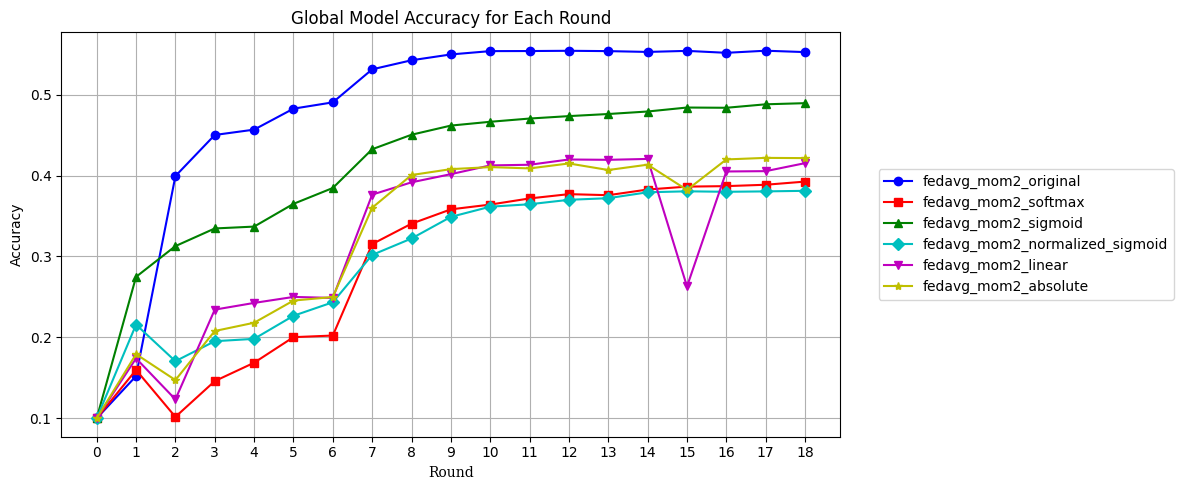

In [14]:
plot_accuracy_per_round(fedavg_mom2_results)

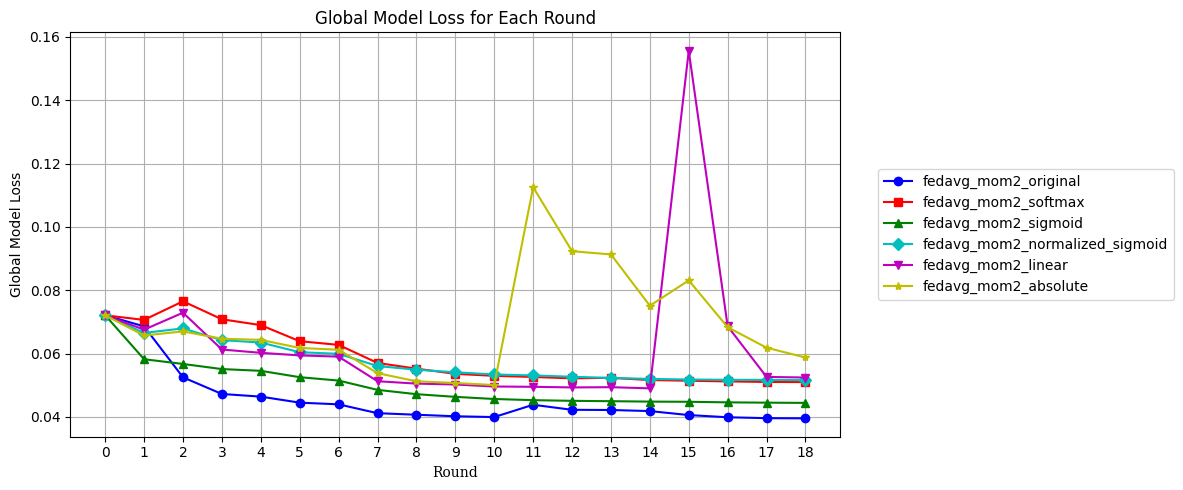

In [15]:
plot_loss_per_round(fedavg_mom2_results)

From the figures we can see that out of all the weighting strategies, interestingly, the original weighting performs the best. From the accuracy and loss plots the original weighting strategy, despite its potential issues, shows a more stable and better accuracy increase and loss curves. This could be due to the fact that during the weighting the weights also incorporate directionality, as if the client has a negative cosine similarity, its weight will be negative and will be penalized during aggregation however this is also the weakness of this method. To understand this mechanism and its effect a further study is required. The other weighting strategies return values only between 0 and 1. 

### Communication cost 

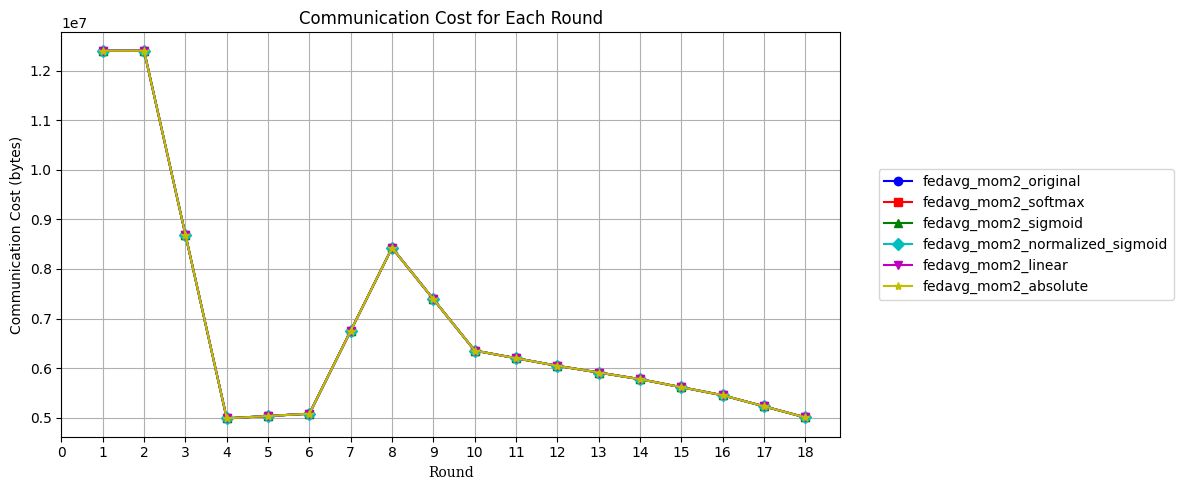

In [16]:
plot_communication_cost_per_round(fedavg_mom2_results)

Since all the weight variant strategies based on the same base framework of momentum sharing they also exhibit the same communication cost pattern. In this case the communication increase compared to the regular FedPartAvg as optimizer states (first and second momentum) are also communicated to the server.

### Parameter Differences Across Round













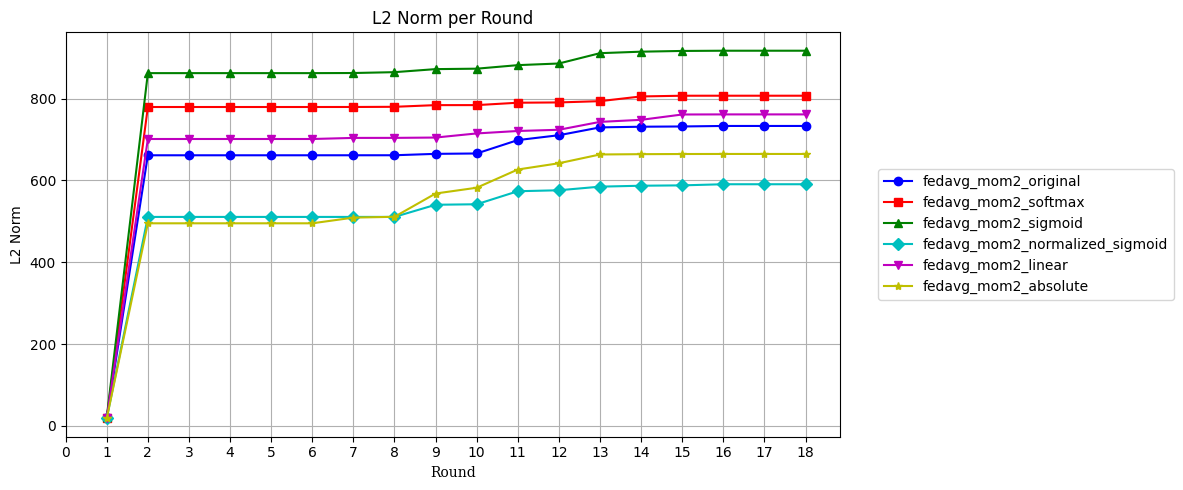

In [17]:
plot_l2_norm_per_round(fedavg_mom2_results)

In these strategies we can see a significant increase in the L2 norm compared to FedAvg and FedPartAvg. This phenomena can be attributed to the fact the momentum is aggregated and redistributed to clients, however the momentums are not treated equally and weighted during aggregation according to their cosine similarity just like the parameters, which can cause client to diverge significantly into direction that does not align well with their local data resulting in larger changes in parameters and hence a significantly larger L2 norm.  

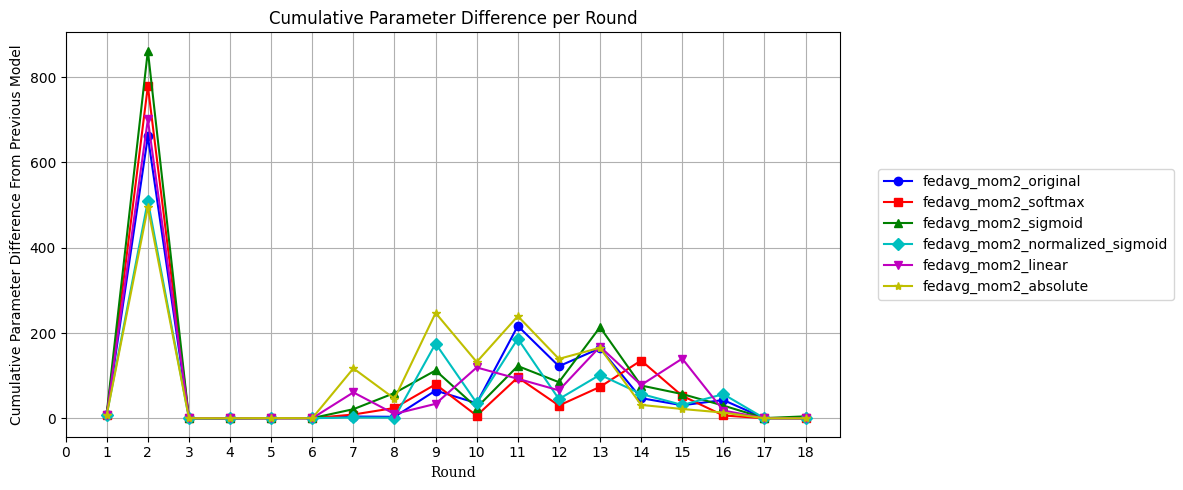

In [18]:
plot_parameter_difference_per_round(fedavg_mom2_results)

This cascading effect of weighted momentum aggregation is also shown in the changes in parameters between rounds. As we can see in the first two rounds there is an overwhelmingly large change between the two rounds of the central model parameters.

This is likely caused by the fact that in the earlier rounds( focusing on full network training) before the parameters aggregation's averaging effect can take place, the clients are so diverse in terms of their parameters that the weighted momentum aggregation and redistribution causes a them to diverge so much that later layer-wise aggregation rounds can not invert the effect of the earlier rounds. This is also indicated by the difference in the cosine similarity between the parameters of the first two rounds and later rounds (shown in the figure below). 

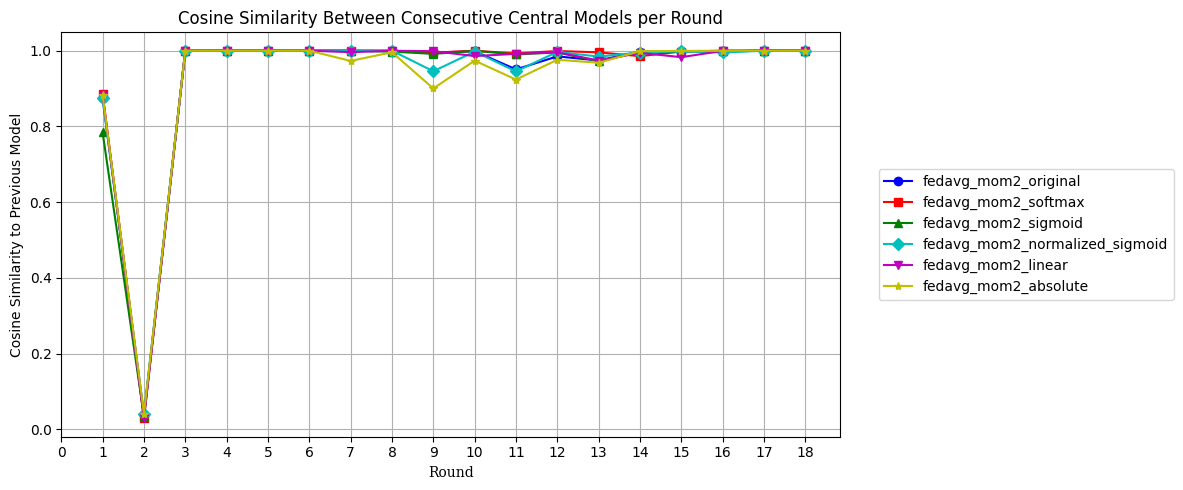

In [19]:
plot_cosine_similarity_per_round(fedavg_mom2_results)

### Save the results to pickle files

In [24]:
pickle.dump(fedavg_mom2_results, open(f"{experiment_type}_fedavgmom2.pkl", 'wb'))
all_results.update(fedavg_mom2_results)

# Single Momentum

## FedAvgMom1

Similarly to FedAvgMom2, FedAvgMom1 is a strategy that uses momentum and cosine similarity based weighting to aggregate the results from the clients. The main difference is that FedAvgMom1 uses the first momentum only of the clients to aggregate the results, the second momentum is not used, it just averaged across the clients. We use the same weighting mechanisms as in FedAvgMom2 to compare the performance of both approaches to each other.

### FedAvgMom1 Original Weighting


In [6]:
from src.FedMom1.FedAvg.client import get_fedavg_mom1_client_fn
from src.FedMom1.FedAvg.strategy import FedAvgMom1

In [7]:
fedavg_mom1_original_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_original_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_original_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="original")

def fedavg_mom1_original_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_original_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_original_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025).
/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025).
(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=5228) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=5226) [Client 5] initialized
(ClientAppActor pid=5226) [Client 5] fit
(ClientAppActor pid=5228) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5228) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5228) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5228) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5228) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5228) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5228) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5228) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5228) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=5228) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=5228) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=5228) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=5228) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=5228) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5230) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=5230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
(ClientAppActor pid=5230) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across clu

(ClientAppActor pid=5226) [Client 3] initialized
(ClientAppActor pid=5226) [Client 3] evaluate
(ClientAppActor pid=5230) Epoch 8: train loss 0.04034220954190671, accuracy 0.5176241187940603 [repeated 11x across cluster]
(ClientAppActor pid=5230) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 2] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5226) Layer 9 (fc3.bias

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=5226) Epoch 1: train loss 0.06940255167246079, accuracy 0.2476747674767477
(ClientAppActor pid=5230) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=5230) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=5230) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=5230) training network... [repeated 5x across cluster]
(ClientAppActor pid=5230) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=5228) Epoch 3: train loss 0.04971480421429098, accuracy 0.3988898889888989 [repeated 12x across cluster]
(ClientAppActor pid=5228) Epoch 5: train loss 0.044710581979700084, accuracy 0.4675967596759676 [repeated 12x across cluster]
(ClientAppActor pid=5228) Epoch 7: train loss 0.0427219887109551, accuracy 0.4951995199519952 [repeated 12x across cluster]
(ClientAppActor pid=5228) [Client 5] get_parameters
[-0.1983700841665268, -0.29843568801879883, 0.2017807811498642, -0.080

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5231) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=5231)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=5231) [Client 2] initialized
(ClientAppActor pid=5231) [Client 2] evaluate
(ClientAppActor pid=5227) Epoch 8: train loss 0.043777761080584794, accuracy 0.4843984398439844 [repeated 11x across cluster]
(ClientAppActor pid=5227) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=5226) [Client 4] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5226) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5226) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5226) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5226) Layer 15 (fc7.bias) is frozen
(ClientAppActor pid=5226) Got optimizer sta

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 6x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 6x across cluster]
(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=5227) [Client 4] initialized
(ClientAppActor pid=5228) Epoch 8: train loss 0.0820026130749222, accuracy 0.24103794810259488 [repeated 11x across cluster]
(ClientAppActor pid=5230) [Client 0] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 3] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 

(ClientAppActor pid=5228) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 12x across cluster]
(ClientAppActor pid=5228) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 12x across cluster]
(ClientAppActor pid=5230) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=5230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 5] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5226) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5226) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5226) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5226

(ClientAppActor pid=5230) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 11x across cluster]
(ClientAppActor pid=5230) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Tue Jun 24 02:55:08 2025). [repeated 11x across cluster]
(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=5229) [Client 1] initialized
(ClientAppActor pid=5229) [Client 1] evaluate
(ClientAppActor pid=5227) Epoch 8: train loss 0.0528808890110088, accuracy 0.3541854185418542 [repeated 11x across cluster]
(ClientAppActor pid=5227) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5231) [Client 1] fit
(ClientAppActor pid=5231) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5231) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5231) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=5231) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=5231) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5231) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5231) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5231) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5231) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5231) Layer 9 (fc3.bias) is frozen
(ClientApp

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 5] initialized
(ClientAppActor pid=5227) [Client 5] evaluate
(ClientAppActor pid=5229) Epoch 8: train loss 0.052969671586881054, accuracy 0.3621362136213621 [repeated 11x across cluster]
(ClientAppActor pid=5229) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5231) [Client 0] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientA

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=5227) [Client 2] initialized [repeated 9x across cluster]
(ClientAppActor pid=5231) [Client 0] evaluate [repeated 5x across cluster]
(ClientAppActor pid=5231) Epoch 1: train loss 0.06005447588886692, accuracy 0.3673316334183291
(ClientAppActor pid=5228) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=5228) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=5228) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=5228) training network... [repeated 5x across cluster]
(ClientAppActor pid=5228) [Client 5] initialized [repeated 2x across cluster]
(ClientAppActor pid=5231) Epoch 4: train loss 0.048254147719564475, accuracy 0.42342882855857206 [repeated 18x across cluster]
(ClientAppActor pid=5228) Epoch 6: train loss 0.04852322835733395, accuracy 0.4446444644464446 [repeated 17x across cluster]
(Client

(ClientAppActor pid=5229) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=5229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5230) [Client 4] fit
(ClientAppActor pid=5230) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5230) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5230) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5230) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5230) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=5230) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=5230) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5230) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5230) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5230) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5230) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5230) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5230) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5230) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5230) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5230

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 2] initialized
(ClientAppActor pid=5227) [Client 2] evaluate
(ClientAppActor pid=5227) Epoch 8: train loss 0.04556843097453857, accuracy 0.4648964896489649 [repeated 11x across cluster]
(ClientAppActor pid=5227) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5230) [Client 4] fit
(ClientAppActor pid=5230) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5230) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5230) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5230) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5230) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5230) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5230) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5230) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5230) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5230) Layer 9 (fc3.bias) is frozen
(ClientAp

(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5227) [Client 3] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5227) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5227) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5227) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5227) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5227) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5227

(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=5227) Epoch 1: train loss 0.04731177351977637, accuracy 0.4465946594659466
(ClientAppActor pid=5226) [Client 1] fit [repeated 5x across cluster]
(ClientAppActor pid=5226) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=5226) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=5226) training network... [repeated 5x across cluster]
(ClientAppActor pid=5231) Epoch 3: train loss 0.04691604543404646, accuracy 0.4564956495649565 [repeated 16x across cluster]
(ClientAppActor pid=5228) Epoch 6: train loss 0.046260526624776546, accuracy 0.46227688615569223 [repeated 14x across cluster]
(ClientAppActor pid=5228) [Client 0] get_parameters
(ClientAppActor pid=5229) Epoch 8: train loss 0.04610134950458127, accuracy 0.44854485448544856 [repeated 13x across cluster]
[0.9078409075737, 0.972993791103363, 0.9256439208984375, 0.9

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=5231) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=5231)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 0] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=5226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5226) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5226) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5226) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5226) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5226

(ClientAppActor pid=5226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=5226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5228) [Client 0] fit
(ClientAppActor pid=5228) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5228) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5228) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5228) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5228) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5228) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5228) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5228) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=5228) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=5228) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5228) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5228) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5228) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5228) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5228

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 5] initialized
(ClientAppActor pid=5227) [Client 5] evaluate
(ClientAppActor pid=5230) Epoch 8: train loss 0.04569282792475071, accuracy 0.46339633963396337 [repeated 3x across cluster]
(ClientAppActor pid=5227) [Client 1] get_parameters [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5227) [Client 5] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 2] initialized
(ClientAppActor pid=5227) [Client 2] evaluate
(ClientAppActor pid=5231) Epoch 8: train loss 0.04433985178091902, accuracy 0.47637618119094044 [repeated 11x across cluster]
(ClientAppActor pid=5231) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5226) [Client 4] fit
(ClientAppActor pid=5226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5226) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5227) [Client 2] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5227) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5227) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5227) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=5227) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=5227) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=5227

(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5228) [Client 5] initialized
(ClientAppActor pid=5228) [Client 5] evaluate
(ClientAppActor pid=5231) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=5231) Epoch 8: train loss 0.044206251442942, accuracy 0.48192590370481475 [repeated 8x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5228) [Client 0] fit
(ClientAppActor pid=5228) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5228) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5228) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5228) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5228) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5228) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5228) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5228) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5228) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5228) Layer 9 (fc3.bias) is frozen
(ClientAppActor p

(ClientAppActor pid=5227) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5227) [Client 0] initialized
(ClientAppActor pid=5227) [Client 0] evaluate
(ClientAppActor pid=5230) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=5227) Epoch 8: train loss 0.044393746927268794, accuracy 0.4813981398139814 [repeated 3x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5230) [Client 2] fit
(ClientAppActor pid=5230) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5230) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5230) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5230) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5230) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5230) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5230) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5230) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5230) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5230) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=5229) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=5229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=5231) [Client 3] fit
(ClientAppActor pid=5227) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=5227) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=5227) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=5227) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=5227) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=5227) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=5227) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=5227) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=5227) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=5227) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=5227) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=5227) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=5227) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=5227) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=5227) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=5227) L

(ClientAppActor pid=5228) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5228) [Client 1] initialized
(ClientAppActor pid=5228) [Client 1] evaluate
(ClientAppActor pid=5230) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=5230) Epoch 8: train loss 0.04400334235179042, accuracy 0.47824782478247824 [repeated 13x across cluster]
(ClientAppActor pid=5229) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=5229) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=5229) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=5229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [8]:
fedavg_mom1_original_results=fedavg_mom1_original_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_original'] = fedavg_mom1_original_results

### FedAvgMom1 Softmax Weighting



In [9]:
fedavg_mom1_softmax_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_softmax_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_softmax_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="softmax")

def fedavg_mom1_softmax_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_softmax_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_softmax_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=19298) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=19298)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=19298) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=19298) [Client 1] initialized
(ClientAppActor pid=19298) [Client 1] fit
(ClientAppActor pid=19298) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19298) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19298) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19298) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19298) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19298) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19298) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19298) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19298) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19298) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=19298) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=19298) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=19298) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=19298) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=19298) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=19295) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=19300) [Client 1] initialized
(ClientAppActor pid=19300) [Client 1] evaluate
(ClientAppActor pid=19296) Epoch 8: train loss 0.040754314767967426, accuracy 0.5091509150915091 [repeated 5x across cluster]
(ClientAppActor pid=19296) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 0] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19299) La

(ClientAppActor pid=19296) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19296)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 2] fit
(ClientAppActor pid=19296) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19296) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19296) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19296) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19296) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19296) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19296) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19296) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19296) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19296) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19296) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19296) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19296) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=19296) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=19296) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 0] initialized
(ClientAppActor pid=19300) [Client 0] evaluate
(ClientAppActor pid=19300) Epoch 8: train loss 0.05351823562979162, accuracy 0.3511851185118512 [repeated 5x across cluster]
(ClientAppActor pid=19300) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 2] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is fr

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19295) [Client 2] initialized
(ClientAppActor pid=19295) [Client 2] evaluate
(ClientAppActor pid=19296) Epoch 8: train loss 0.05229717139917388, accuracy 0.3685315734213289 [repeated 11x across cluster]
(ClientAppActor pid=19296) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 0] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is f

(ClientAppActor pid=19295) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19295)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19295) [Client 3] initialized
(ClientAppActor pid=19295) [Client 3] evaluate
(ClientAppActor pid=19296) Epoch 8: train loss 0.05032383151116607, accuracy 0.3941802909854507 [repeated 11x across cluster]
(ClientAppActor pid=19296) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19297) [Client 4] fit
(ClientAppActor pid=19297) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19297) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19297) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=19297) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=19297) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19297) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19297) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19297) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19297) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19297) Layer 9 (fc3.bias) is f

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19299) [Client 3] initialized
(ClientAppActor pid=19299) [Client 3] evaluate
(ClientAppActor pid=19299) Epoch 8: train loss 0.04899445165843286, accuracy 0.4088795560221989 [repeated 7x across cluster]
(ClientAppActor pid=19299) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 4] fit
(ClientAppActor pid=19298) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19298) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19298) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19298) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19298) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19298) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19298) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19298) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19298) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19298) Layer 9 (fc3.bias) is fr

(ClientAppActor pid=19295) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19295)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19295) [Client 0] initialized
(ClientAppActor pid=19295) [Client 0] evaluate
(ClientAppActor pid=19297) Epoch 8: train loss 0.04087122310899665, accuracy 0.4921992199219922 [repeated 11x across cluster]
(ClientAppActor pid=19297) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19297) [Client 3] fit
(ClientAppActor pid=19298) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19298) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19298) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19298) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19298) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=19298) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=19298) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19298) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19298) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19298) Layer 9 (fc3.bias) is f

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 14x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 14x across cluster]


(ClientAppActor pid=19299) [Client 4] initialized
(ClientAppActor pid=19299) [Client 4] evaluate
(ClientAppActor pid=19296) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=19296) Epoch 8: train loss 0.03836087078222669, accuracy 0.551005100510051 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 3] fit
(ClientAppActor pid=19297) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19297) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19297) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19297) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19297) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19297) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19297) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19297) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19297) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19297) Layer 9 (fc3.bias) is fro

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19299) [Client 2] initialized
(ClientAppActor pid=19299) [Client 2] evaluate
(ClientAppActor pid=19295) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 1] fit
(ClientAppActor pid=19300) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19300) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19300) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19300) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19300) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19300) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19300) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=19300) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=19300) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19300) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19300) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19300) Layer 11 (fc4.bias) is frozen
(Cli

(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19299) [Client 5] initialized
(ClientAppActor pid=19299) [Client 5] evaluate
(ClientAppActor pid=19296) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=19296) Epoch 8: train loss 0.03990961551809325, accuracy 0.5354035403540354 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 2] fit
(ClientAppActor pid=19296) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19296) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19296) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19296) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19296) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19296) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19296) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19296) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19296) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19296) Layer 9 (fc3.bias) is train

(ClientAppActor pid=19298) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19298)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19298) [Client 4] initialized
(ClientAppActor pid=19298) [Client 4] evaluate
(ClientAppActor pid=19299) Epoch 8: train loss 0.04114402642184976, accuracy 0.5321733913304335 [repeated 11x across cluster]
(ClientAppActor pid=19299) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 3] fit
(ClientAppActor pid=19300) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19300) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19300) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19300) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19300) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19300) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19300) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19300) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19300) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=19300) Layer 9 (fc3.bias) is trai

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 0] initialized
(ClientAppActor pid=19300) [Client 0] evaluate
(ClientAppActor pid=19298) Epoch 8: train loss 0.03997630555101103, accuracy 0.5379537953795379 [repeated 11x across cluster]
(ClientAppActor pid=19298) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 1] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=19296) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19296)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 1] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19299) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=19299) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=19299) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=19299) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=19299) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=19295) [Client 3] initialized
(ClientAppActor pid=19295) [Client 3] evaluate
(ClientAppActor pid=19297) Epoch 8: train loss 0.03908145577028425, accuracy 0.5426042604260426 [repeated 11x across cluster]
(ClientAppActor pid=19300) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=19299) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19299)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19299) [Client 2] fit
(ClientAppActor pid=19299) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19299) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19299) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19299) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19299) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19299) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19299) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19299) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19299) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19299) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19299) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19299) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19299) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=19299) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=19299) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=19299) Layer 15 (fc7.bias) is frozen
(ClientAppActor pid=19299)

(ClientAppActor pid=19297) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19297)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19296) [Client 0] fit
(ClientAppActor pid=19295) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19295) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19295) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19295) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19295) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19295) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19295) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19295) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19295) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19295) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19295) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19295) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19295) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=19295) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=19295) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=19300) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19300)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 1] initialized
(ClientAppActor pid=19300) [Client 1] evaluate
(ClientAppActor pid=19297) Epoch 8: train loss 0.03922058291676271, accuracy 0.5395230238488076 [repeated 11x across cluster]
(ClientAppActor pid=19297) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19299) [Client 2] fit
(ClientAppActor pid=19295) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19295) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19295) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19295) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19295) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19295) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19295) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19295) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19295) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19295) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=19297) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19297)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=19300) [Client 5] fit
(ClientAppActor pid=19300) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=19300) 
(ClientAppActor pid=19300) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=19300) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=19300) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=19300) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=19300) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=19300) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=19300) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=19300) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=19300) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=19300) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=19300) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=19300) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=19300) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=19300) Layer 14 (fc7.weig

(ClientAppActor pid=19296) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19296)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19300) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=19300) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=19295) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=19295)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [10]:
fedavg_mom1_softmax_results=fedavg_mom1_softmax_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_softmax'] = fedavg_mom1_softmax_results

### FedAvgMom1 Sigmoid Weighting

In [11]:
fedavg_mom1_sigmoid_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_sigmoid_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="sigmoid")

def fedavg_mom1_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_sigmoid_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=34026) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34026)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=34026) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=34026) [Client 0] initialized
(ClientAppActor pid=34026) [Client 0] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=34026) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=34026) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=34024) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34022) [Client 4] fit
(ClientAppActor pid=34022) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34022) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34022) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34022) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34022) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34022) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34022) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34022) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34022) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34022) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34022) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34022) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34022) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=34022) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=34022) Laye

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34025) [Client 0] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34021) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34021)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34024) [Client 2] fit
(ClientAppActor pid=34024) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=34024) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=34024) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34024) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34024) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34024) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34024) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34024) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34024) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34024) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34024) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34024) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34024) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34024) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34024) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34021) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34021)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34021) [Client 4] initialized
(ClientAppActor pid=34021) [Client 4] evaluate
(ClientAppActor pid=34023) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34022) [Client 0] fit
(ClientAppActor pid=34023) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34023) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34023) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34023) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34023) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34023) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34023) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34023) Layer 11 (fc4.bias) is frozen
(Cli

(ClientAppActor pid=34022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=34022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 3] fit
(ClientAppActor pid=34023) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34023) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34023) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=34023) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=34023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34023) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34023) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34023) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34023) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34023) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34023) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34023) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34021) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34021)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34021) [Client 4] initialized
(ClientAppActor pid=34021) [Client 4] evaluate
(ClientAppActor pid=34024) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=34024) Epoch 8: train loss 0.04379243815656972, accuracy 0.47014701470147013
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34026) [Client 3] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=340

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34026) [Client 2] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=34022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=34025) Epoch 1: train loss 0.04022011823770041, accuracy 0.5339733013349333
(ClientAppActor pid=34023) [Client 0] fit [repeated 5x across cluster]
(ClientAppActor pid=34023) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=34023) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=34023) training network... [repeated 5x across cluster]
(ClientAppActor pid=34023) [Client 0] initialized
(ClientAppActor pid=34022) Epoch 2: train loss 0.03710660476996453, accuracy 0.5622562256225623 [repeated 10x across cluster]
(ClientAppActor pid=34025) Epoch 4: train loss 0.03380196682244955, accuracy 0.6136193190340483 [repeated 8x across cluster]
(ClientAppActor pid=34023) Epoch 5: train loss 0.032760682403907185, accuracy 0.6280185990700465 [repeated 11x across cluster]
(ClientAppActor pid=34021) Epoch 7: train loss 0.0300433

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34025) [Client 5] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34021) [Client 0] fit
(ClientAppActor pid=34021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34021) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=34021) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=34021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34021) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34021) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34021) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34021) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34021) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34021) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 1] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34026) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34026) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 2] fit
(ClientAppActor pid=34023) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34023) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34023) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34023) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34023) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=34023) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=34023) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34023) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34023) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34023) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34023) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34025) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34025)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34023) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=34026) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=34026)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=34026) [Client 3] fit
(ClientAppActor pid=34026) [Client 3] initialized [repeated 6x across cluster]
(ClientAppActor pid=34026) [Client 3] evaluate [repeated 5x across cluster]
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34026) Layer 13 (fc5.bia

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34021) [Client 0] fit
(ClientAppActor pid=34021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34021) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34021) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34021) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34021) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=34021) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=34021) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34021) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34021) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34022) [Client 5] fit
(ClientAppActor pid=34021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34021) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34021) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34021) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34021) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34021) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34021) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=34021) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=34021) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=34026) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34026)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34026) [Client 4] initialized
(ClientAppActor pid=34026) [Client 4] evaluate
(ClientAppActor pid=34023) Epoch 8: train loss 0.03391321827404641, accuracy 0.6167116711671167 [repeated 5x across cluster]
(ClientAppActor pid=34023) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34024) [Client 3] fit
(ClientAppActor pid=34024) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34024) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34024) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34024) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34024) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34024) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34024) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34024) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34024) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34024) Layer 9 (fc3.bias) is frozen
(

(ClientAppActor pid=34025) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34025)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34024) [Client 2] fit
(ClientAppActor pid=34025) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34025) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34025) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34025) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34025) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34025) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34025) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34025) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34025) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34025) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34025) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34025) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34025) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34025) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34025) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=34023) [Client 3] fit
(ClientAppActor pid=34026) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=34026) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=34026) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=34026) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=34026) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=34026) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=34026) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=34026) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=34026) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=34026) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=34026) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=34026) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=34026) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=34026) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=34026) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=34024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=34024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=34025) [Client 3] initialized
(ClientAppActor pid=34025) [Client 3] evaluate
(ClientAppActor pid=34021) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=34021) Epoch 8: train loss 0.03573607450771031, accuracy 0.6038698065096745 [repeated 4x across cluster]
(ClientAppActor pid=34023) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=34023) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=34023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=34023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [12]:
fedavg_mom1_sigmoid_results=fedavg_mom1_sigmoid_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_sigmoid'] = fedavg_mom1_sigmoid_results

### FedAvgMom1 Normalized Sigmoid Weighting






In [13]:
fedavg_mom1_normalized_sigmoid_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_normalized_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_normalized_sigmoid_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="normalized_sigmoid")

def fedavg_mom1_normalized_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_normalized_sigmoid_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_normalized_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48223) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=48223) [Client 3] initialized
(ClientAppActor pid=48226) [Client 0] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48226) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48226) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48226) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48226) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48226) Layer 14 (fc7.weight) is trai

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=48225) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 4] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=48223) Laye

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 1] initialized
(ClientAppActor pid=48217) [Client 1] evaluate
(ClientAppActor pid=48226) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48217) Epoch 8: train loss 0.04909228749222273, accuracy 0.41104110411041106 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48226) [Client 2] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is f

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 0] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48221) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48221) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48221) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48221) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48221) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 0] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48223) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 0] initialized
(ClientAppActor pid=48217) [Client 0] evaluate
(ClientAppActor pid=48217) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48217) Epoch 8: train loss 0.05480782956358838, accuracy 0.32373237323732373 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 1] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is f

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48217) Epoch 8: train loss 0.053860721522324656, accuracy 0.32223222322232226 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48226) [Client 2] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48226) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48226) Laye

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 1] initialized
(ClientAppActor pid=48223) [Client 1] evaluate
(ClientAppActor pid=48223) Epoch 8: train loss 0.04852605087779286, accuracy 0.40339033903390337 [repeated 11x across cluster]
(ClientAppActor pid=48223) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 3] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is 

(ClientAppActor pid=48225) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 4] initialized
(ClientAppActor pid=48223) [Client 4] evaluate
(ClientAppActor pid=48223) Epoch 8: train loss 0.04571180074664876, accuracy 0.43999399939994 [repeated 11x across cluster]
(ClientAppActor pid=48223) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 2] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is fro

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 2] initialized
(ClientAppActor pid=48217) [Client 2] evaluate
(ClientAppActor pid=48226) Epoch 8: train loss 0.04693062470691039, accuracy 0.42649264926492647 [repeated 11x across cluster]
(ClientAppActor pid=48226) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48226) [Client 4] fit
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is 

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48224) [Client 0] fit
(ClientAppActor pid=48224) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48224) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48224) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48224) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48224) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48224) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48224) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48224) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48224) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48224) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48224) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48224) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48224) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48224) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48224) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48217) [Client 1] fit
(ClientAppActor pid=48221) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48221) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48221) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48221) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48221) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48221) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48221) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48221) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48221) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=48221) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=48221) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48221) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48221) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48221) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48221) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 5] initialized
(ClientAppActor pid=48223) [Client 5] evaluate
(ClientAppActor pid=48226) Epoch 8: train loss 0.04427074741358661, accuracy 0.4720972097209721 [repeated 11x across cluster]
(ClientAppActor pid=48226) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 3] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48217) [Client 1] fit
(ClientAppActor pid=48217) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48217) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48217) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48217) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48217) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48217) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48217) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48217) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48217) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48217) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48217) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=48217) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=48217) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48217) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48217) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=48217) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48217) [Client 2] initialized
(ClientAppActor pid=48217) [Client 2] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48221) [Client 1] fit
(ClientAppActor pid=48223) Epoch 8: train loss 0.04399764044235463, accuracy 0.478997899789979 [repeated 5x across cluster]
(ClientAppActor pid=48223) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48226) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48226) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48226) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48226) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48226) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48226) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48226) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48226) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48226) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48226) Layer 9 (fc3.bias) is frozen
(C

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=48223) [Client 0] initialized
(ClientAppActor pid=48223) [Client 0] evaluate
(ClientAppActor pid=48226) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48226) Epoch 8: train loss 0.04495870705806848, accuracy 0.4602460246024602 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 2] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(

(ClientAppActor pid=48221) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48221)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 2] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48223) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=48226) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=48226)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=48223) [Client 3] fit
(ClientAppActor pid=48223) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=48223) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=48223) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=48223) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=48223) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=48223) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=48223) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=48223) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=48223) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=48223) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=48223) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=48223) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=48223) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=48223) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=48223) Layer 14 (fc7.weight) is trainable
(ClientAppA

(ClientAppActor pid=48223) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=48223)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=48223) [Client 5] initialized
(ClientAppActor pid=48223) [Client 5] evaluate
(ClientAppActor pid=48221) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=48225) Epoch 8: train loss 0.04365629513915366, accuracy 0.47944794479447944 [repeated 5x across cluster]
(ClientAppActor pid=48225) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=48225) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=48225) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [14]:
fedavg_mom1_normalized_sigmoid_results=fedavg_mom1_normalized_sigmoid_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_normalized_sigmoid'] = fedavg_mom1_normalized_sigmoid_results

### FedAvgMom1 Linear Weighting


In [15]:
fedavg_mom1_linear_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_linear_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_linear_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="linear")

def fedavg_mom1_linear_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_linear_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_linear_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 0] initialized
(ClientAppActor pid=60562) [Client 4] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60566) Layer 12 (fc5.weight) 

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=60566) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=60562) Epoch 1: train loss 0.06467599901679469, accuracy 0.18301830183018303
(ClientAppActor pid=60563) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 3] fit [repeated 5x across cluster]
(ClientAppActor pid=60563) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=60563) training network... [repeated 5x across cluster]
(ClientAppActor pid=60562) Epoch 3: train loss 0.05485671937483551, accuracy 0.29432943294329433 [repeated 12x across cluster]
(ClientAppActor pid=60564) Epoch 5: train loss 0.051383756228549106, accuracy 0.3637863786378638 [repeated 12x across cluster]
(ClientAppActor pid=60564) Epoch 7: train loss 0.04631716953610072, accuracy 0.4365436543654365 [repeated 12x across cluster]
(ClientAppActor pid=60564) [Client 2] get_parameters
[0.2893516719341278, 0.4883926808834076, 0.4634700417518616, 0.36624225974082947, 0.34496426582336426, 0.5435135960578918]
  Evaluation results - Loss: 0.

(ClientAppActor pid=60561) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60561)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=60563) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=60563) [Client 3] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 4] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is trainable
(ClientAp

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60564) [Client 1] fit
(ClientAppActor pid=60564) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60564) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60564) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60564) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60564) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60564) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60564) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60564) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60564) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60564) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60564) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60564) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60564) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60564) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60564) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 3] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60566) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60566) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60563) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60563)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60563) [Client 1] initialized
(ClientAppActor pid=60563) [Client 1] evaluate
(ClientAppActor pid=60564) Epoch 8: train loss 0.06450817875056664, accuracy 0.19216921692169217 [repeated 6x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60563) [Client 4] fit
(ClientAppActor pid=60561) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60565) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60565) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60565) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60565) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60565) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60565) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60565) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60565) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60565) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60565) Layer 9 (fc3.bias) is f

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60562) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60565) [Client 4] fit
(ClientAppActor pid=60561) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60561) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60561) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=60561) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=60561) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60561) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60561) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60561) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60561) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60561) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60561) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60561) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60561) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60561) Layer 13 (fc5.b

(ClientAppActor pid=60565) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60565)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 2] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60562) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60562) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60562) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60562) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60562) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=60562) Epoch 1: train loss 0.06093633491428557, accuracy 0.22412241224122412
(ClientAppActor pid=60563) [Client 5] fit [repeated 5x across cluster]
(ClientAppActor pid=60563) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=60563) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=60563) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=60563) training network... [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=60562) Epoch 3: train loss 0.05891023719772147, accuracy 0.26432643264326433 [repeated 12x across cluster]
(ClientAppActor pid=60562) Epoch 6: train loss 0.05768058849389654, accuracy 0.2877287728772877 [repeated 18x across cluster]
(ClientAppActor pid=60562) [Client 2] get_parameters
[0.6456549167633057, 0.8387736082077026, 0.6865477561950684, 0.654423713684082, 0.7896806001663208

(ClientAppActor pid=60563) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60563)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=60561) [Client 5] initialized
(ClientAppActor pid=60565) Epoch 8: train loss 0.057359522655304536, accuracy 0.2926353682315884 [repeated 17x across cluster]
(ClientAppActor pid=60565) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 1] evaluate
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 5] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is 

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60565) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60565) Epoch 8: train loss 0.055037397058597386, accuracy 0.3130813081308131 [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 0] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60565) [Client 2] fit
(ClientAppActor pid=60565) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60565) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60565) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60565) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60565) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60565) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60565) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=60565) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=60565) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60565) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60565) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60565) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60565) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60565) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60565) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60563) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 5] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60562) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60562) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60562) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60562) Layer 13 (fc5.b

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60565) [Client 3] fit
(ClientAppActor pid=60565) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60565) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60565) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60565) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60565) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60565) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60565) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60565) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60565) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=60565) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=60565) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60565) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60565) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60565) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60565) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60565) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60565)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=60565) Epoch 1: train loss 0.052750766116364596, accuracy 0.3598859885988599
(ClientAppActor pid=60563) [Client 4] fit [repeated 5x across cluster]
(ClientAppActor pid=60563) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=60563) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=60563) Got optimizer state in config, setting.. [repeated 5x across cluster]
(ClientAppActor pid=60563) training network... [repeated 5x across cluster]
(ClientAppActor pid=60563) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=60561) Epoch 3: train loss 0.05236308711661686, accuracy 0.3748874887488749 [repeated 16x across cluster]
(ClientAppActor pid=60562) Epoch 5: train loss 0.0524400681516554, accuracy 0.367986798679868 [repeated 10x across cluster]
(ClientAppActor pid=60562) Epoch 7: train loss 0.05229889039266514, accuracy 0.3682868286828683 [repeated 12x across cluster]
(ClientAppActor pid=60566) [

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 2] fit
(ClientAppActor pid=60561) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60561) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60561) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60561) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60561) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60561) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60561) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60561) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60561) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60561) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60561) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60561) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60561) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60561) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60561) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60561) [Client 1] fit
(ClientAppActor pid=60561) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60561) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60561) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60561) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60561) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60561) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60561) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60561) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60561) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60561) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60561) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=60561) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=60561) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60561) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=60561) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 3] fit
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=60566) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=60566) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60562) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 14x across cluster]
(ClientAppActor pid=60562)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 14x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 3] fit
(ClientAppActor pid=60562) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60562) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60562) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60562) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60562) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60562) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60562) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60562) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60562) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60562) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60562) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60562) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60562) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=60562) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=60562) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=60566) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60566)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60566) [Client 2] fit
(ClientAppActor pid=60563) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=60566) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60566) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60566) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60566) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60566) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60566) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60566) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60566) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60566) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60566) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=60566) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=60566) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=60566) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=60566) Layer 13 (fc5.bias) i

(ClientAppActor pid=60565) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60565)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60564) [Client 2] initialized
(ClientAppActor pid=60564) [Client 2] evaluate
(ClientAppActor pid=60564) Epoch 8: train loss 0.05090009821022805, accuracy 0.38958895889588957 [repeated 11x across cluster]
(ClientAppActor pid=60564) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=60562) [Client 3] fit
(ClientAppActor pid=60563) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=60563) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=60563) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=60563) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=60563) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=60563) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=60563) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=60563) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=60563) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=60563) Layer 9 (fc3.bias) is frozen

(ClientAppActor pid=60561) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=60561)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=60564) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=60564) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=60564) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=60564)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [16]:
fedavg_mom1_linear_results=fedavg_mom1_linear_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_linear'] = fedavg_mom1_linear_results

### FedAvgMom1 Absolute Weighting

In [17]:
fedavg_mom1_absolute_client_fn = get_fedavg_mom1_client_fn(load_datasets)
client = ClientApp(client_fn=fedavg_mom1_absolute_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedavg_mom1_absolute_strategy = FedAvgMom1(evaluate_fn=evaluate_fn, aggregate_mode="absolute")

def fedavg_mom1_absolute_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedavg_mom1_absolute_strategy,
    )

server = ServerApp(server_fn=fedavg_mom1_absolute_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 4] initialized
(ClientAppActor pid=72819) [Client 4] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72819) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=72819) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=72819) Layer 12 (fc5.weight) 

(ClientAppActor pid=72819) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=72819)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=72819) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=72819) Epoch 1: train loss 0.06444023528543993, accuracy 0.20972097209720972
(ClientAppActor pid=72821) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=72820) [Client 2] fit [repeated 5x across cluster]
(ClientAppActor pid=72820) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=72820) training network... [repeated 5x across cluster]
(ClientAppActor pid=72817) Epoch 2: train loss 0.05668458628193163, accuracy 0.2942852857357132 [repeated 9x across cluster]
(ClientAppActor pid=72815) Epoch 4: train loss 0.04958921504600106, accuracy 0.40624062406240624 [repeated 9x across cluster]
(ClientAppActor pid=72815) Epoch 6: train loss 0.044063804048051214, accuracy 0.4783978397839784 [repeated 12x across cluster]
(ClientAppActor pid=72815) [Client 5] get_parameters
(ClientAppActor pid=72815) Epoch 8: train loss 0.03919079568054881, accuracy 0.5394539453945395 [repeated 12x across cluster]
[-0.010244451463222504, 0.4590

(ClientAppActor pid=72815) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=72815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=72821) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72817) [Client 4] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72817) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=72817) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=72817) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=72817) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=72817) Laye

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 2] initialized
(ClientAppActor pid=72820) [Client 2] evaluate
(ClientAppActor pid=72821) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72821) Epoch 8: train loss 0.052027557946510254, accuracy 0.37468126593670315
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72817) [Client 3] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 0] fit
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72815) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72815) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72815) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72815) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72815) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 5] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72819) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72819) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72819) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72819) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72819) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 3] initialized
(ClientAppActor pid=72820) [Client 3] evaluate
(ClientAppActor pid=72816) Epoch 8: train loss 0.058378355033827586, accuracy 0.2806780678067807 [repeated 11x across cluster]
(ClientAppActor pid=72816) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 1] fit
(ClientAppActor pid=72816) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72816) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72816) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72816) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72816) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72816) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72816) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72816) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72816) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72816) Layer 9 (fc3.bias) is 

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 1] initialized
(ClientAppActor pid=72816) [Client 1] evaluate
(ClientAppActor pid=72821) Epoch 8: train loss 0.05685904964540872, accuracy 0.2953795379537954 [repeated 17x across cluster]
(ClientAppActor pid=72821) [Client 2] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72816) [Client 3] fit
(ClientAppActor pid=72816) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72816) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72816) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72816) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72816) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72816) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72816) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72816) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72816) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72816) Layer 9 (fc3.bias) is f

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72815) [Client 5] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72816) [Client 5] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72817) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72817) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72817) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72817) Layer 13 (fc5.b

(ClientAppActor pid=72819) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72819)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 0] fit
(ClientAppActor pid=72820) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72820) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72820) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72820) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72820) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72820) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72820) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72820) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72820) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72820) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72820) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72820) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72820) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72820) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72820) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72816) [Client 1] fit
(ClientAppActor pid=72816) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72816) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72816) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72816) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72816) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72816) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72816) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72816) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72816) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72816) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72816) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72816) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72816) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72816) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72816) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72815) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 3] fit
(ClientAppActor pid=72820) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72820) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72820) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72820) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72820) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72820) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72820) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72820) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72820) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72820) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72820) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72820) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72820) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72820) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72820) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 4] fit
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72815) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72815) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72815) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72815) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72815) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 5] initialized
(ClientAppActor pid=72820) [Client 5] evaluate
(ClientAppActor pid=72821) Epoch 8: train loss 0.04906078087294747, accuracy 0.42012899355032246 [repeated 11x across cluster]
(ClientAppActor pid=72821) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 2] fit
(ClientAppActor pid=72820) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72820) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72820) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72820) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72820) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72820) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72820) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72820) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72820) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72820) Layer 9 (fc3.bias) is frozen

(ClientAppActor pid=72820) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72820)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72820) [Client 1] initialized
(ClientAppActor pid=72820) [Client 1] evaluate
(ClientAppActor pid=72817) Epoch 8: train loss 0.048349656371389424, accuracy 0.4291285435728214 [repeated 8x across cluster]
(ClientAppActor pid=72817) [Client 1] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 5] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=72817) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72820) [Client 4] fit
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72815) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72815) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72815) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=72815) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=72815) Layer 14 (fc7.weight) is frozen
(ClientA

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 3] initialized
(ClientAppActor pid=72816) [Client 3] evaluate
(ClientAppActor pid=72821) Epoch 8: train loss 0.04849220332452806, accuracy 0.4249287535623219 [repeated 5x across cluster]
(ClientAppActor pid=72821) [Client 0] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72817) [Client 0] fit
(ClientAppActor pid=72817) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72817) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72817) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72817) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72817) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72817) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72817) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72817) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72817) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72817) Layer 9 (fc3.bias) is frozen
(

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 0] initialized
(ClientAppActor pid=72816) [Client 0] evaluate
(ClientAppActor pid=72815) Epoch 8: train loss 0.04770226915641622, accuracy 0.43744374437443745 [repeated 11x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72815) [Client 5] fit
(ClientAppActor pid=72815) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72815) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72815) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72815) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72815) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72815) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72815) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72815) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72815) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72815) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72815) Layer 9 (fc3.bias) is frozen

(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 2] initialized
(ClientAppActor pid=72816) [Client 2] evaluate
(ClientAppActor pid=72819) Epoch 8: train loss 0.04688626037787075, accuracy 0.4521452145214521 [repeated 11x across cluster]
(ClientAppActor pid=72819) [Client 4] get_parameters [repeated 5x across cluster]
Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
(ClientAppActor pid=72819) [Client 2] fit
(ClientAppActor pid=72819) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72819) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72819) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72819) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72819) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72819) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72819) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72819) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72819) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72819) Layer 9 (fc3.bias) is frozen


(ClientAppActor pid=72815) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72816) [Client 2] initialized [repeated 5x across cluster]
(ClientAppActor pid=72816) [Client 2] evaluate [repeated 5x across cluster]


(ClientAppActor pid=72816) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=72816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [18]:
fedavg_mom1_absolute_results=fedavg_mom1_absolute_strategy.get_results()
fedavg_mom1_results['fedavg_mom1_absolute'] = fedavg_mom1_absolute_results


## Summary

### Accuracy and Loss per Round

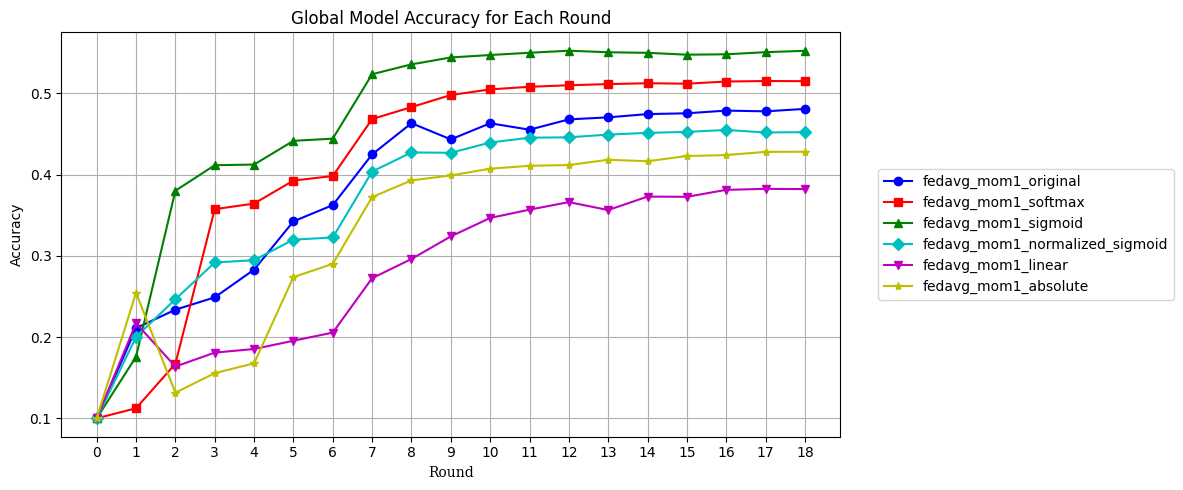

In [20]:
plot_accuracy_per_round(fedavg_mom1_results)

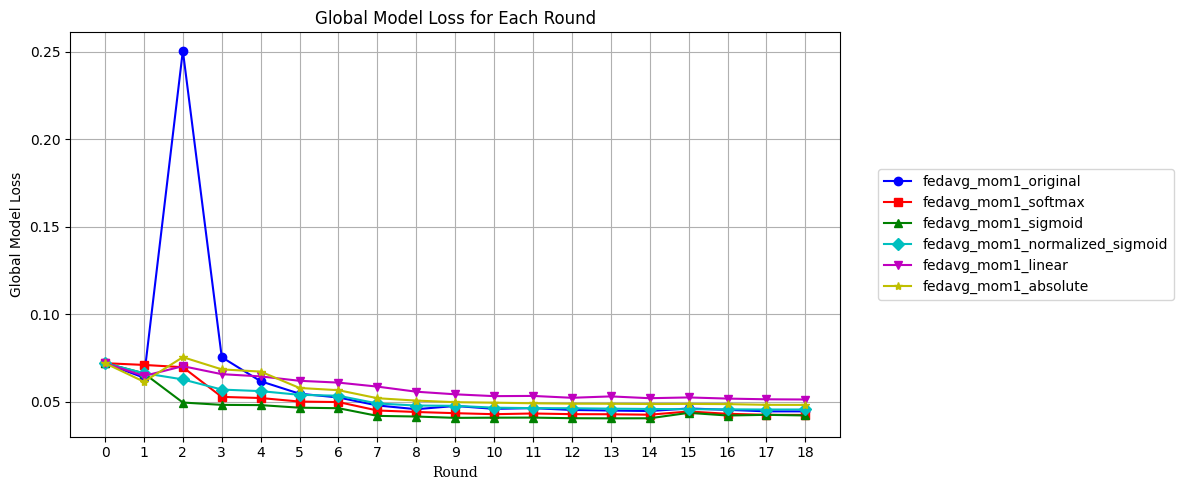

In [21]:
plot_loss_per_round(fedavg_mom1_results)

Interestingly using a first momentum as weighting factor shows a better performance using the sigmoid weighting mechanism rather than the original weighting mechanism as it was the case for FedAvgMom2. Using sigmoid function weighting also presents a more stable loss curve and increase in accuracy compared to the other weights mechanisms, especially the original weight mechanism which shows a large increase in loss in the 2nd round. 

### Communication cost 

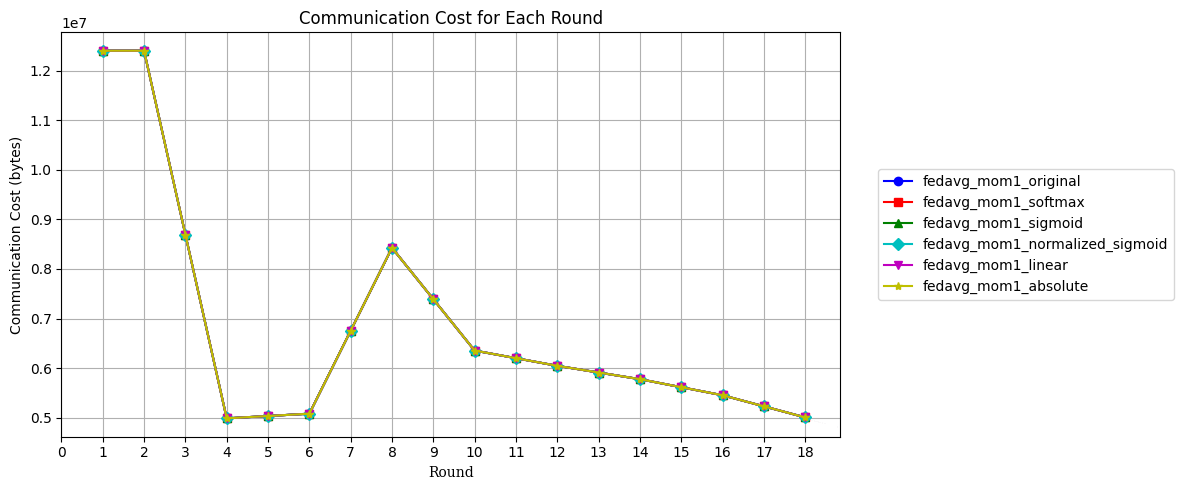

In [22]:
plot_communication_cost_per_round(fedavg_mom1_results)

Although, in this case only the first momentum is used for weighting, both of first and second momentum are communicated for aggregation and redistribution as in Local Adam (discussed later in the notebook).

### Parameter Differences per Round













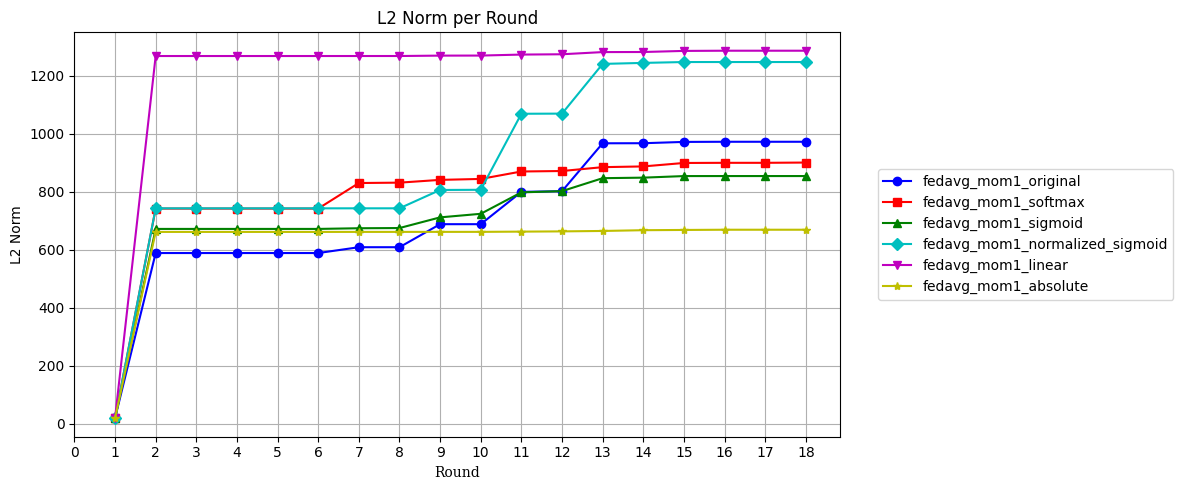

In [23]:
plot_l2_norm_per_round(fedavg_mom1_results)

Similarly to FedAvgMom2, FedAvgMom1 also exhibits much greater L2 norms then its regular FedAvg and FedPartAvg counter parts, likely caused by the same reason of momentum weighting.

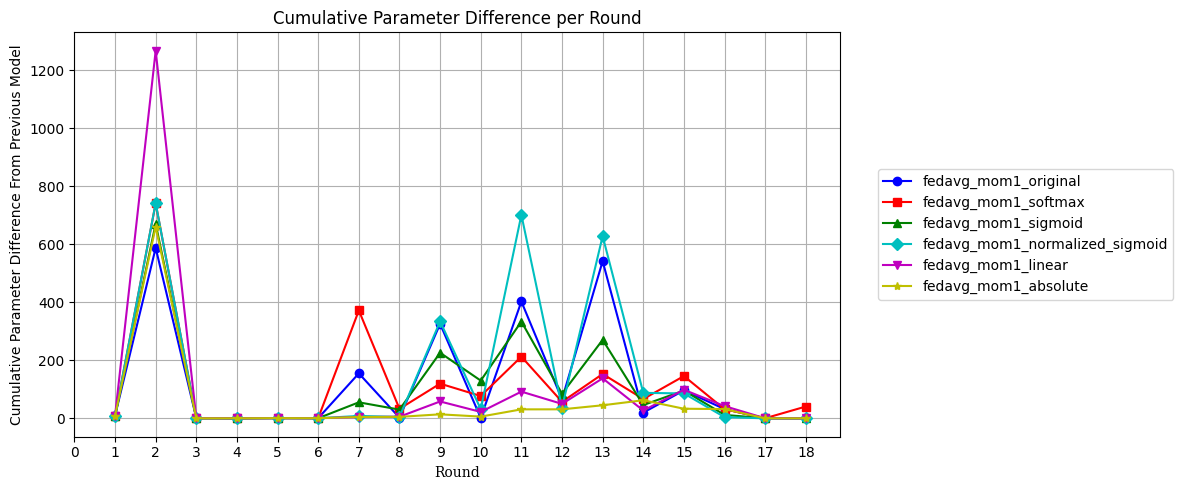

In [24]:
plot_parameter_difference_per_round(fedavg_mom1_results)

As it was discussed in FedAvgMom2 section, using weighted aggregation of momentum can cause a trickle down effect across layers. This is also shown in the figure below where cosine similarity in the second round is much smaller than the other rounds as well as the figure above that presents a significantly larger change in parameters between first and second round than any other round.

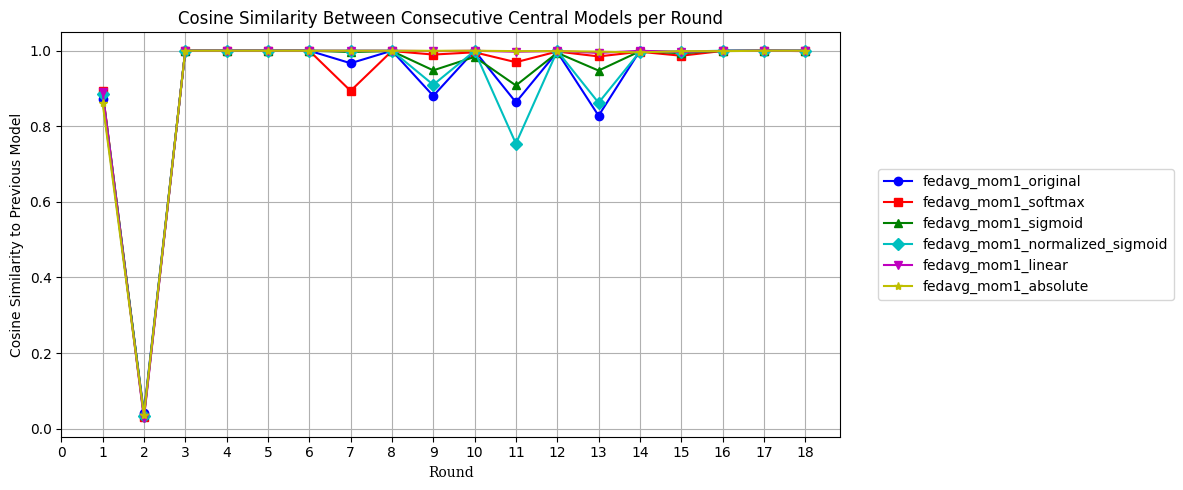

In [25]:
plot_cosine_similarity_per_round(fedavg_mom1_results)

### Save the results to pickle files

In [31]:
pickle.dump(fedavg_mom1_results, open(f"{experiment_type}_fedavgmom1.pkl", 'wb'))
all_results.update(fedavg_mom1_results)

# Pseudo Gradient

## Fed PseudoGradient Part Avg

In [61]:
from src.FedPseudoGradient.FedAvg.client import get_fedpseudo_gradient_avg_part_client_fn
from src.FedPseudoGradient.FedAvg.strategy import FedPseudoGradientPartAvg

In [62]:
fedpseudo_gradient_avg_part_client_fn = get_fedpseudo_gradient_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=fedpseudo_gradient_avg_part_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedpseudo_gradient_avg_part_strategy= FedPseudoGradientPartAvg(evaluate_fn=evaluate_fn)

def fedpseudo_gradient_avg_part_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedpseudo_gradient_avg_part_strategy,
    )

server = ServerApp(server_fn=fedpseudo_gradient_avg_part_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000


(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=35238) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=35238) [Client 2] initialized
(ClientAppActor pid=35238) [Client 2] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35238) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35238) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35238) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=35238) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=35237) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=35238) [Client 1] initialized
(ClientAppActor pid=35238) [Client 1] evaluate
(ClientAppActor pid=35237) Epoch 8: train loss 0.037876278162002563, accuracy 0.5525052505250525 [repeated 3x across cluster]
(ClientAppActor pid=35237) [Client 4] get_parameters


(ClientAppActor pid=35235) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=35236) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35236) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=35236) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35236) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35236) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35236) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35236) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35236) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35236) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35236) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35236) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35236) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35236) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35236) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35236) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=35236) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=35236) Layer 14 (fc7.weight) i

(ClientAppActor pid=35234) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 2x across cluster]
(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


total size: 7449672
Number of parameters after update: 154486
  Evaluation results - Loss: 0.0454, Accuracy: 0.5271
(ClientAppActor pid=35233) [Client 0] initialized
(ClientAppActor pid=35233) [Client 0] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.022101396694779396, accuracy 0.7382238223822383 [repeated 11x across cluster]
(ClientAppActor pid=35236) [Client 3] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=35236) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=35238) [Client 2] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35238) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35238) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35238) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35238) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35238) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35238) L

(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=35238) [Client 3] initialized
(ClientAppActor pid=35238) [Client 3] evaluate
(ClientAppActor pid=35234) Epoch 8: train loss 0.039982933551073074, accuracy 0.5535553555355536 [repeated 11x across cluster]
(ClientAppActor pid=35234) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35233) [Client 1] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35237) [Client 4] initialized
(ClientAppActor pid=35237) [Client 4] evaluate
(ClientAppActor pid=35238) Epoch 8: train loss 0.03960317373275757, accuracy 0.5604560456045604 [repeated 11x across cluster]
(ClientAppActor pid=35238) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35234) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=35234) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35234) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35234) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35234) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35234) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35234) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35234) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35234) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35234) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35234) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35237) [Client 4] initialized
(ClientAppActor pid=35237) [Client 4] evaluate
(ClientAppActor pid=35233) Epoch 8: train loss 0.036618586629629135, accuracy 0.5821208939553022 [repeated 11x across cluster]
(ClientAppActor pid=35233) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35234) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=35234) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35234) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35234) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=35234) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=35234) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35234) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35234) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35234) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35234) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35234) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=35238) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35238) [Client 4] initialized
(ClientAppActor pid=35238) [Client 4] evaluate
(ClientAppActor pid=35233) Epoch 8: train loss 0.03557907044887543, accuracy 0.5883588358835884 [repeated 11x across cluster]
(ClientAppActor pid=35233) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=35236) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35236) [Client 0] initialized
(ClientAppActor pid=35236) [Client 0] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.013606644235551357, accuracy 0.9023402340234024 [repeated 6x across cluster]
(ClientAppActor pid=35236) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=35238) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35238) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35238) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35238) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35238) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=35238) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=35238) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35238) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35238) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35238) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=35234) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35234) [Client 4] initialized
(ClientAppActor pid=35234) [Client 4] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.010648705996572971, accuracy 0.9324932493249325 [repeated 10x across cluster]
(ClientAppActor pid=35236) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35235) [Client 0] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 1] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35233) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35233) La

(ClientAppActor pid=35235) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35236) [Client 4] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=35236) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35236) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35236) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35236) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35236) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35236) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35236) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35236) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35236) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35236) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35236) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35236) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35236) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35236) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35236) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35236) La

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35233) [Client 3] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35233) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35233) La

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35233) [Client 1] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=35233) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35233) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35233) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35233) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35233) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35233) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35233) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35233) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35233) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35233) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35233) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=35233) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=35233) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35233) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35233) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=35233) La

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35235) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) [Client 0] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35235) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35235) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35235) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=35235) Layer 13 (fc5.bias) is trainable
(Clien

(ClientAppActor pid=35236) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35236) [Client 2] initialized
(ClientAppActor pid=35236) [Client 2] evaluate
(ClientAppActor pid=35236) Epoch 8: train loss 0.02582256682217121, accuracy 0.7054147292635369 [repeated 23x across cluster]
(ClientAppActor pid=35236) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35236) [Client 3] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=35236) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35236) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35236) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35236) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35236) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35236) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35236) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35236) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35236) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35236) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=3

(ClientAppActor pid=35234) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35238) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35238) Epoch 8: train loss 0.02572518214583397, accuracy 0.7086708670867087 [repeated 5x across cluster]
(ClientAppActor pid=35235) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35235) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35235) Layer 11 (fc4.bias) is frozen
(Cl

(ClientAppActor pid=35233) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35235) [Client 5] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=35235) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=35235) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=35235) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=35235) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=35235) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=35235) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=35235) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=35235) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=35235) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=35235) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=35235) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=35235) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=35235) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=35235) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=35235) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=35235) Layer

(ClientAppActor pid=35235) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=35235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=35234) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=35237) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=35237) [Client 3] evaluate [repeated 5x across cluster]


(ClientAppActor pid=35237) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=35237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [63]:
fedpseudo_gradient_avg_part_results=fedpseudo_gradient_avg_part_strategy.get_results()
pseudo_gradient_results['fedpseudo_gradient_avg_part'] = fedpseudo_gradient_avg_part_results

## Summary

### Accuracy and Loss per Round

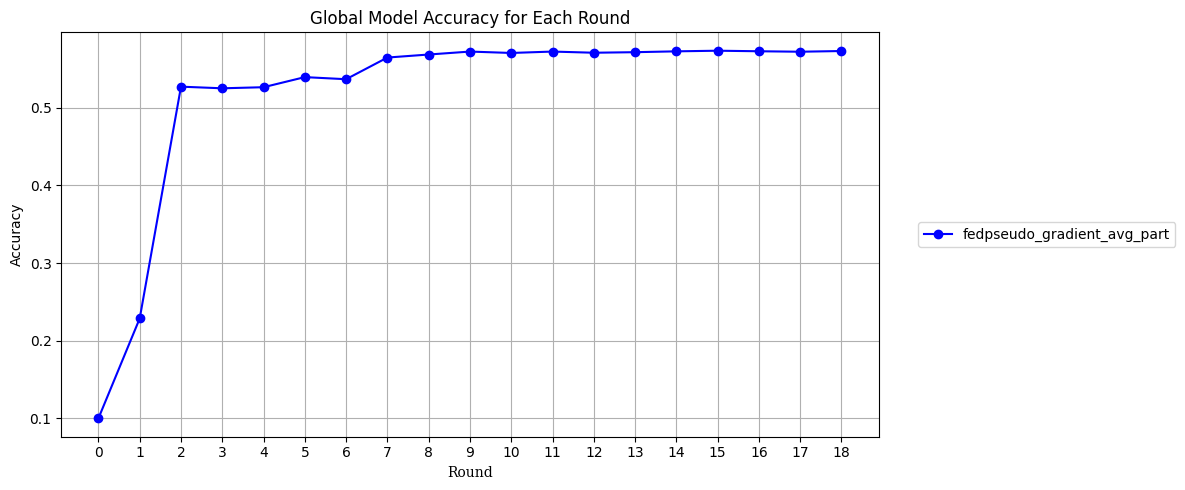

In [26]:
plot_accuracy_per_round(pseudo_gradient_results)

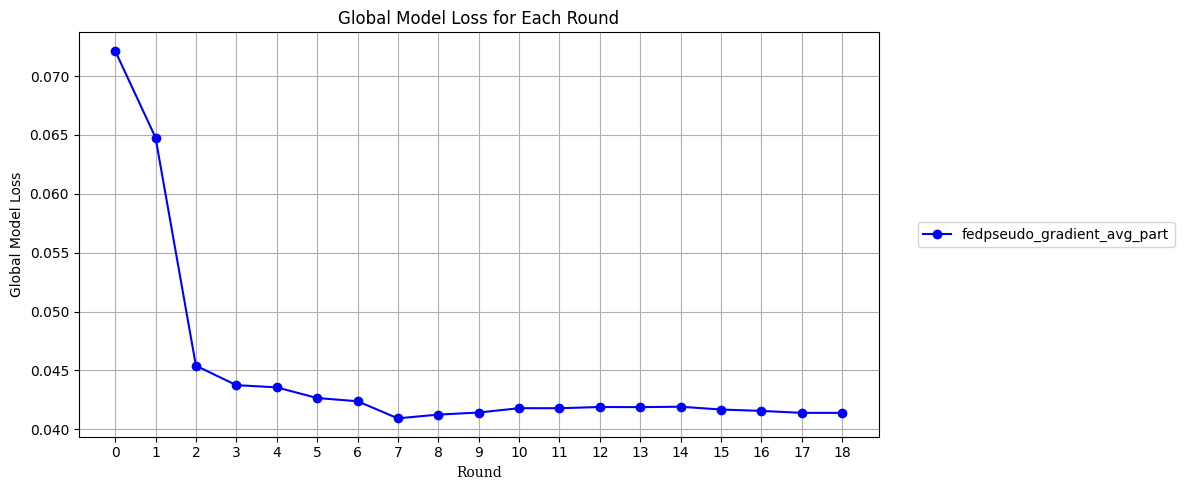

In [27]:
plot_loss_per_round(pseudo_gradient_results)

Regarding the accuracy and loss plots, using the average pseudo-gradient update approach seems to exhibit the same patterns as the regular FedPartAvg strategy except its increase in accuracy in the rounds between 3 and 6 seem to be smaller, and so is the decrease in loss.

### Communication cost 

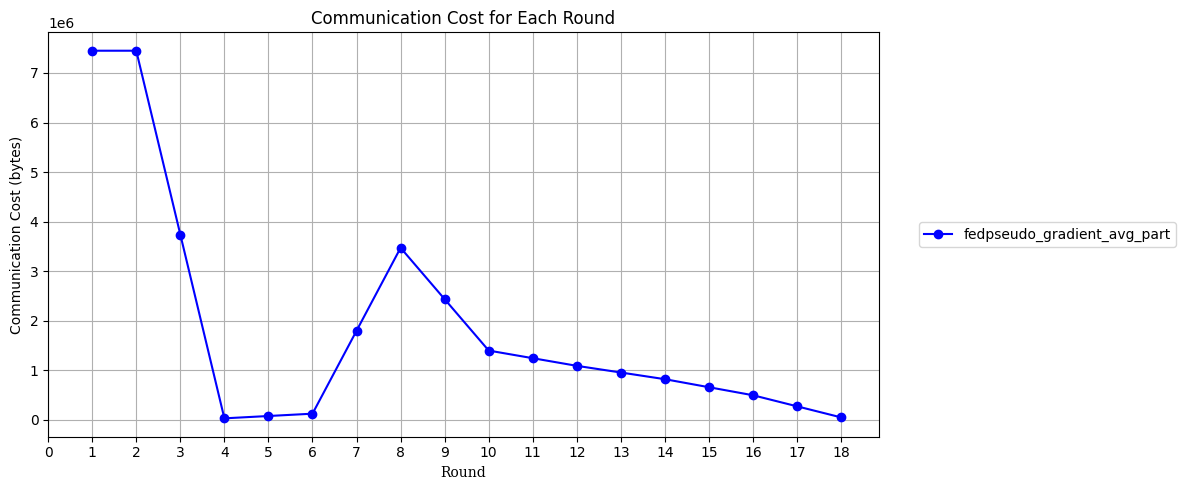

In [28]:
plot_communication_cost_per_round(pseudo_gradient_results)

Since the PseudoGradient update approach only uses the parameters that clients shared and not the momentum, it exhibits the exact same communication pattern as the regular FedPartAvg strategy.

### Parameter Differences Across Rounds













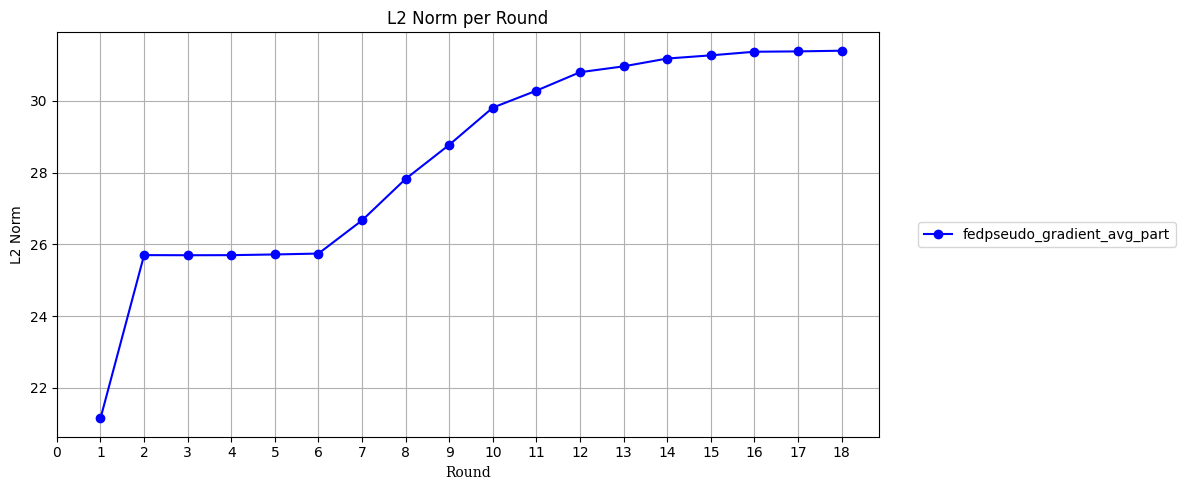

In [29]:
plot_l2_norm_per_round(pseudo_gradient_results)

Interestingly, regarding the L2 norm of the model parameters across rounds, the strategy presents a mixture of both FedAvg and FedPartAvg. The earlier rounds (until round 6) the L2 norm shows the behaviour of FedPartAvg with its constant value after which it has a more stable  and constant increase across rounds similar to FedAvg.

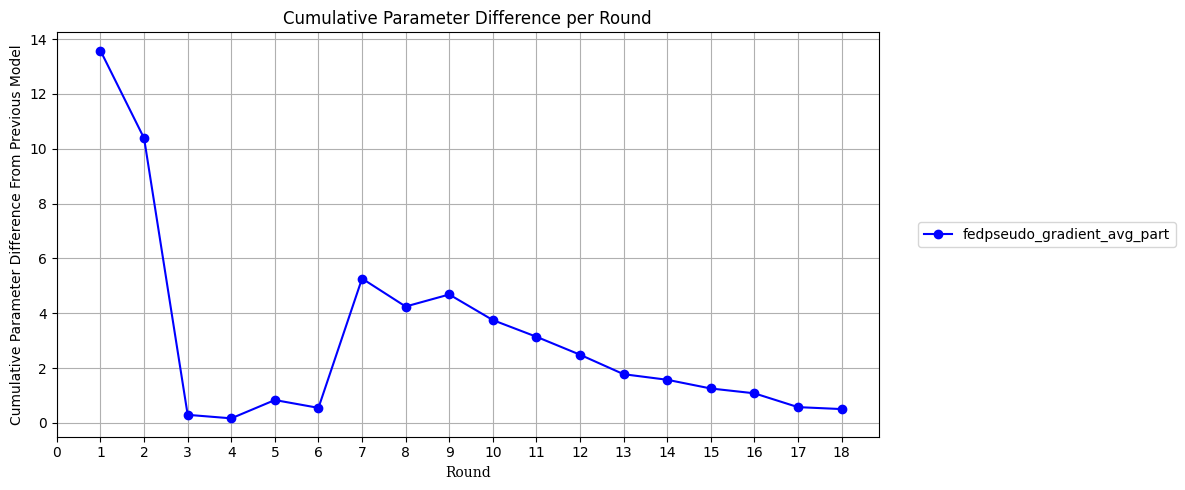

In [30]:
plot_parameter_difference_per_round(pseudo_gradient_results)

The parameter difference and model cosine similarity between rounds also shows a mixture of FedAvg and FedPartAvg. For parameter difference in the early rounds the strategy shows a similar behaviour to FedPartAvg where it fluctuates, however after round 9 it shows a constant decline like FedAvg. When it comes to cosine similarity, we can see a similar fluctuation to FedPartAvg between round 6 and 10 after which it shows a constant increase like FedAvg.

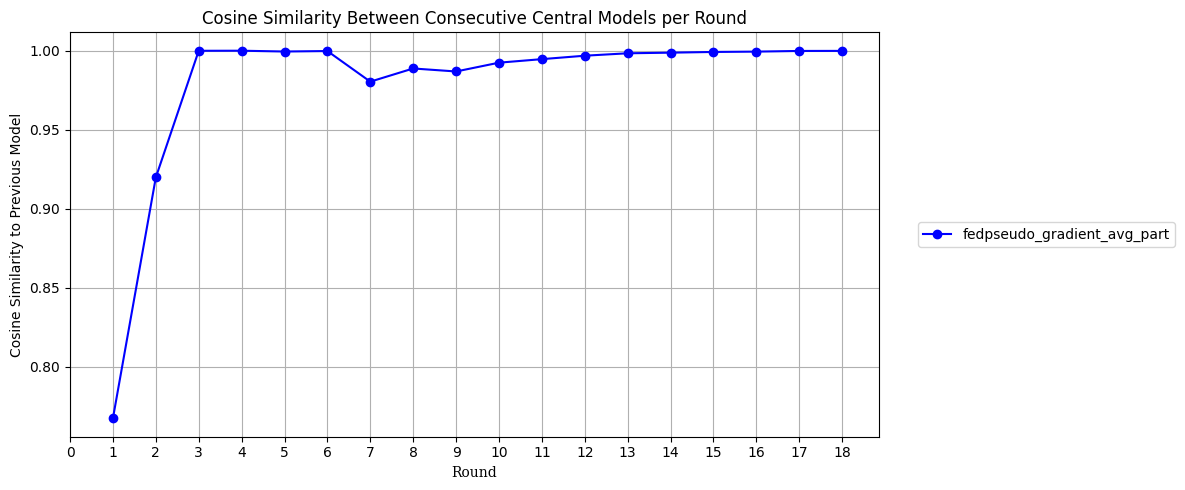

In [31]:
plot_cosine_similarity_per_round(pseudo_gradient_results)

### Save the results to pickle files

In [38]:
pickle.dump(pseudo_gradient_results, open(f"{experiment_type}_pseudogradient.pkl", 'wb'))

all_results.update(pseudo_gradient_results)

# PseudoGradient Similarity (PSAP)

The strategies presented in this section are aiming to build upon the PseudoGradient update based strategy by incorporating cosine similarity based weighting to the update process similarly how it was done with the momentum based approaches where the particular client's parameters are weighted based on the cosine similarity to the central aggregated parameters of the previous round. However, to avoid the trickle down effect of early model dissimilarities, in the first round a pseudo-gradient update is performed on the central model parameters. To the best of our knowledge it is new novel approach to the problem of layer-wise training in federated learning.


## PseudoGradient Similarity Avg Part (PSAP)

In [4]:
from src.FedPseudoGradientSimilarity.FedAvg.client import get_fedpseudo_gradient_similarity_avg_part_client_fn
from src.FedPseudoGradientSimilarity.FedAvg.strategy import FedPseudoGradientSimilarityPartAvg

### PseudoGradient Similarity Avg Part -  Original Weighting

In [6]:
psap_original_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_original_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_original_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="original")

def psap_original_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_original_strategy,
    )

server = ServerApp(server_fn=psap_original_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=27338) [Client 0] initialized
(ClientAppActor pid=27338) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=27338) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=27338) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=27338) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=27338) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=27338) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=27338) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=27338) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=27338) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=27338) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=27338) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=27338) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=27338) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=27338) Layer 12 (fc5.weight) is trainable
(Clien

(ClientAppActor pid=27338) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=27338)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=27338) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=27338) Epoch 1: train loss 0.06645823270082474, accuracy 0.20188990550472477
(ClientAppActor pid=27337) [Client 1] initialized [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=27337) [Client 1] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=27337) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=27338) Epoch 3: train loss 0.05531301721930504, accuracy 0.3248837558122094 [repeated 12x across cluster]
(ClientAppActor pid=27335) Epoch 5: train loss 0.05034148320555687, accuracy 0.3846384638463846 [repeated 13x across cluster]
(ClientAppActor pid=27335) Epoch 7: train loss 0.04503505304455757, accuracy 0.45874587458745875 [repeated 12x across cluster]
(ClientAppActor

(ClientAppActor pid=27333) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=27333)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=27337) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=27333) [Client 3] initialized
(ClientAppActor pid=27333) [Client 3] evaluate
(ClientAppActor pid=27337) Epoch 8: train loss 0.03953605145215988, accuracy 0.5312734363281836 [repeated 10x across cluster]
(ClientAppActor pid=27337) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27335) [Client 2] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=27335) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=27335) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=27335) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=27335) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=27335) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=27335) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=27335) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=27335) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=27335) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=27335) Layer 9 (fc3.bias) is

(ClientAppActor pid=27338) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27338)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27334) [Client 4] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=27335) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=27335) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=27335) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27335) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27335) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27335) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27335) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27335) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27335) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27335) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27335) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=27335) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=27335) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=27335) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=27335) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=27335) L

(ClientAppActor pid=27334) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27334)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27337) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27337) [Client 4] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=27337) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=27337) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=27337) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27337) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27337) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27337) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27337) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27337) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27337) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27337) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27337) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=27337) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=27337) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=27337) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=27335) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27335)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27335) [Client 2] initialized
(ClientAppActor pid=27335) [Client 2] evaluate
(ClientAppActor pid=27338) Epoch 8: train loss 0.03964085504412651, accuracy 0.5489048904890489 [repeated 11x across cluster]
(ClientAppActor pid=27338) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27333) 
(ClientAppActor pid=27334) [Client 3] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=27334) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27334) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27334) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=27334) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=27334) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27334) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27334) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27334) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27334) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27334) Layer 9 (fc3.bia

(ClientAppActor pid=27336) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27336)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27336) [Client 1] initialized
(ClientAppActor pid=27336) [Client 1] evaluate
(ClientAppActor pid=27337) Epoch 8: train loss 0.03577334061264992, accuracy 0.5874587458745875 [repeated 11x across cluster]
(ClientAppActor pid=27337) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27333) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=27333) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27333) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27333) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=27333) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=27333) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27333) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27333) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27333) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27333) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27333) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=27334) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27334)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27335) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27336) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=27336) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27336) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27336) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27336) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27336) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=27336) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=27336) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27336) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27336) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27336) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27336) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=27336) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=27336) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=27336) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=27337) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27337)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27337) [Client 2] initialized
(ClientAppActor pid=27337) [Client 2] evaluate
(ClientAppActor pid=27335) Epoch 8: train loss 0.016084466129541397, accuracy 0.8547854785478548 [repeated 17x across cluster]
(ClientAppActor pid=27335) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27337) [Client 0] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=27337) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27337) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27337) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27337) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27337) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=27337) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=27337) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27337) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27337) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27337) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=27336) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27336)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27336) [Client 2] initialized
(ClientAppActor pid=27336) [Client 2] evaluate
(ClientAppActor pid=27333) [Client 3] get_parameters
(ClientAppActor pid=27333) Epoch 8: train loss 0.01162494346499443, accuracy 0.9150915091509151
(ClientAppActor pid=27337) [Client 2] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=27337) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27337) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27337) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27337) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27337) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27337) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27337) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=27337) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=27337) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27337) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27337) Layer 10 (fc4.weight) is frozen
(ClientAppActor

(ClientAppActor pid=27338) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 14x across cluster]
(ClientAppActor pid=27338)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 14x across cluster]


(ClientAppActor pid=27336) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=27336) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27336) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27336) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27336) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27336) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27336) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27336) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=27336) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=27336) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27336) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27336) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=27336) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=27336) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=27336) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=27336) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=27336) La

(ClientAppActor pid=27337) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27337)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27337) [Client 5] initialized
(ClientAppActor pid=27337) [Client 5] evaluate
(ClientAppActor pid=27335) Epoch 8: train loss 0.02408047765493393, accuracy 0.7172217221722172 [repeated 8x across cluster]
(ClientAppActor pid=27333) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=27336) [Client 3] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=27336) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27336) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27336) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27336) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27336) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27336) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27336) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27336) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27336) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=27336) Layer 9 (fc3.bias) is trainable
(ClientAppActor 

(ClientAppActor pid=27335) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=27335)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=27335) [Client 0] initialized [repeated 10x across cluster]
(ClientAppActor pid=27335) [Client 3] evaluate [repeated 5x across cluster]
(ClientAppActor pid=27337) Epoch 1: train loss 0.026825768873095512, accuracy 0.6905190519051905
(ClientAppActor pid=27333) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=27333) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=27333) Layer 9 (fc3.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=27333) [Client 2] initialized
(ClientAppActor pid=27337) Epoch 4: train loss 0.026098066940903664, accuracy 0.6972697269726973 [repeated 18x across cluster]
(ClientAppActor pid=27337) Epoch 7: train loss 0.025678012520074844, accuracy 0.7077707770777077 [repeated 18x across cluster]
(ClientAppActor pid=27334) [Client 1] get_parameters
total size: 1242144
  Evaluation results - Loss: 0.0406, Accuracy: 0.5783


(ClientAppActor pid=27335) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=27335)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=27335) [Client 2] initialized
(ClientAppActor pid=27335) [Client 2] evaluate
(ClientAppActor pid=27333) Epoch 8: train loss 0.026498917490243912, accuracy 0.6978697869786978 [repeated 11x across cluster]
(ClientAppActor pid=27333) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27334) [Client 0] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=27336) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27336) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27336) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27336) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27336) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27336) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27336) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27336) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27336) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=27336) Layer 9 (fc3.bias) is trainable
(ClientAppActo

(ClientAppActor pid=27335) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27335)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27336) [Client 5] initialized
(ClientAppActor pid=27336) [Client 5] evaluate
(ClientAppActor pid=27335) Epoch 8: train loss 0.02543393336236477, accuracy 0.7101710171017102 [repeated 14x across cluster]
(ClientAppActor pid=27335) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27333) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=27333) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27333) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27333) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27333) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27333) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27333) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27333) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27333) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27333) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27333) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=2

(ClientAppActor pid=27337) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=27337)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=27337) [Client 2] initialized [repeated 11x across cluster]
(ClientAppActor pid=27337) [Client 3] evaluate [repeated 5x across cluster]
(ClientAppActor pid=27334) Epoch 1: train loss 0.02657950110733509, accuracy 0.693069306930693
(ClientAppActor pid=27337) [Client 2] fit, config: {'trainable_layers': 5, 'updated_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=27337) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=27337) Layer 11 (fc4.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=27337) Epoch 3: train loss 0.026785805821418762, accuracy 0.6933693369336934 [repeated 14x across cluster]
(ClientAppActor pid=27335) Epoch 4: train loss 0.026658372953534126, accuracy 0.689018901890189 [repeated 13x across cluster]
(ClientAppActor pid=27334) [Client 5] get_parameters
(ClientAppActor pid=27333) Epoch 6: train loss 0.026848826557397842, accuracy 0.6872656367181641 [repeated 11x across cluster]
total size: 95

(ClientAppActor pid=27334) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=27334)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=27337) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=27337)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=27334) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=27334) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27334) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27334) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27334) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27334) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27334) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27334) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27334) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27334) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27334) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27334) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=27334) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=27334) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=27334) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=27334) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=27334) La

(ClientAppActor pid=27335) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=27335)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=27336) [Client 1] initialized
(ClientAppActor pid=27336) [Client 1] evaluate
(ClientAppActor pid=27336) Epoch 8: train loss 0.026490123942494392, accuracy 0.6908190819081909 [repeated 6x across cluster]
(ClientAppActor pid=27336) [Client 3] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=27333) [Client 0] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=27333) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27333) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27333) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27333) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27333) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27333) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27333) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27333) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27333) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27333) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=2

(ClientAppActor pid=27337) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27337)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27337) [Client 0] initialized
(ClientAppActor pid=27337) [Client 0] evaluate
(ClientAppActor pid=27335) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27335) Epoch 8: train loss 0.026923706755042076, accuracy 0.6937153142342883
(ClientAppActor pid=27334) [Client 1] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=27334) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27334) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27334) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27334) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27334) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27334) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27334) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27334) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27334) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27334) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27334) Layer 10 (fc4.weight) i

(ClientAppActor pid=27335) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27335)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27337) [Client 1] initialized
(ClientAppActor pid=27337) [Client 1] evaluate
(ClientAppActor pid=27333) Epoch 8: train loss 0.026547273620963097, accuracy 0.6925153742312884 [repeated 14x across cluster]
(ClientAppActor pid=27333) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=27334) [Client 1] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=27334) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27334) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27334) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27334) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27334) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27334) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27334) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27334) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27334) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27334) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=27338) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27338)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27336) [Client 5] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=27335) Epoch 8: train loss 0.02639833465218544, accuracy 0.6953195319531953
(ClientAppActor pid=27335) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=27335) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=27335) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=27335) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=27335) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=27335) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=27335) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=27335) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=27335) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=27335) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=27335) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=27335) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=27335) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=27335) Layer 13 (fc5.bias) is froze

(ClientAppActor pid=27337) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=27337)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=27337) [Client 4] initialized
(ClientAppActor pid=27337) [Client 4] evaluate
(ClientAppActor pid=27336) Epoch 8: train loss 0.0260288305580616, accuracy 0.698019801980198 [repeated 5x across cluster]
(ClientAppActor pid=27336) [Client 5] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=27334) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=27334) [Client 3] evaluate [repeated 5x across cluster]


(ClientAppActor pid=27334) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=27334)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [7]:
psap_original_results=psap_original_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_original'] = psap_original_results

### PseudoGradient Similarity Avg Part -  Softmax Weighting

In [8]:
psap_softmax_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_softmax_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_softmax_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="softmax")

def psap_softmax_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_softmax_strategy,
    )

server = ServerApp(server_fn=psap_softmax_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000


(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=37889) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=37889) [Client 2] initialized
(ClientAppActor pid=37889) [Client 2] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=37889) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=37889) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=37889) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=37889) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=37889) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=37889) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=37889) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=37889) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=37889) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=37889) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=37889) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=37889) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=37889) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=37889) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=37888) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=37888)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=37888) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=37888) [Client 1] initialized
(ClientAppActor pid=37888) [Client 1] evaluate
(ClientAppActor pid=37889) Epoch 8: train loss 0.04111633449792862, accuracy 0.5136513651365137 [repeated 3x across cluster]
(ClientAppActor pid=37889) [Client 2] get_parameters


(ClientAppActor pid=37886) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=37884) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=37884)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=37884) [Client 5] initialized [repeated 5x across cluster]
(ClientAppActor pid=37884) [Client 5] evaluate [repeated 5x across cluster]
(ClientAppActor pid=37884) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=37884) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=37884) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=37884) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=37884) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=37884) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=37884) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=37884) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=37884) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=37884) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=37884) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=37884) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=37884) Layer 11 (fc4.bias) is trainable
(ClientAppActor p

(ClientAppActor pid=37887) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 2x across cluster]
(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


total size: 7449672
  Evaluation results - Loss: 0.0438, Accuracy: 0.5224


(ClientAppActor pid=37885) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=37886) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=37886)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=37889) [Client 5] initialized
(ClientAppActor pid=37889) [Client 5] evaluate
(ClientAppActor pid=37885) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37885) Epoch 8: train loss 0.025013679638504982, accuracy 0.6991150442477876 [repeated 5x across cluster]
(ClientAppActor pid=37884) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=37889) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=37889) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=37889) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37889) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37889) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37889) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37889) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37889) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37889) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37889) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=37886) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=37886)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=37886) [Client 0] initialized
(ClientAppActor pid=37886) [Client 0] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.03879184275865555, accuracy 0.5535553555355536 [repeated 11x across cluster]
(ClientAppActor pid=37886) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37885) [Client 3] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=37885) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=37885) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=37885) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37885) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37885) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37885) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37885) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37885) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37885) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37885) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37889) [Client 5] initialized
(ClientAppActor pid=37889) [Client 5] evaluate
(ClientAppActor pid=37884) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37886) Epoch 8: train loss 0.03967169672250748, accuracy 0.5483725813709315 [repeated 5x across cluster]
(ClientAppActor pid=37886) [Client 0] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=37888) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37888) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37888) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=37888) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=37888) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37888) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37888) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37888) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37888) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37888) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37889) [Client 5] initialized
(ClientAppActor pid=37889) [Client 5] evaluate
(ClientAppActor pid=37887) Epoch 8: train loss 0.033494457602500916, accuracy 0.6084608460846085 [repeated 6x across cluster]
(ClientAppActor pid=37887) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37885) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=37885) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37885) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37885) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=37885) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=37885) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37885) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37885) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37885) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37885) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37885) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=37885) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37885)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37885) [Client 3] initialized
(ClientAppActor pid=37885) [Client 3] evaluate
(ClientAppActor pid=37884) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37884) Epoch 8: train loss 0.03578082099556923, accuracy 0.5939703014849258 [repeated 5x across cluster]
(ClientAppActor pid=37886) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=37886) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37886) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37886) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37886) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37886) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=37886) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=37886) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37886) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37886) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37886) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=37887) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=37887)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=37887) [Client 2] fit, config: {'trainable_layers': 2, 'updated_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=37887) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=37887) Layer 5 (fc1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=37887) [Client 2] initialized
(ClientAppActor pid=37887) Epoch 2: train loss 0.03148927912116051, accuracy 0.641014101410141 [repeated 15x across cluster]
(ClientAppActor pid=37888) Epoch 6: train loss 0.02033275179564953, accuracy 0.7873106344682765 [repeated 13x across cluster]
(ClientAppActor pid=37888) [Client 1] get_parameters
(ClientAppActor pid=37887) Epoch 7: train loss 0.017991064116358757, accuracy 0.8247824782478248 [repeated 13x across cluster]
total size: 1796448
  Evaluation results - Loss: 0.0411, Accuracy: 0.5563


(ClientAppActor pid=37885) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=37885)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=37889) [Client 1] initialized
(ClientAppActor pid=37889) [Client 1] evaluate
(ClientAppActor pid=37887) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37887) Epoch 8: train loss 0.0163726843893528, accuracy 0.8531353135313532 [repeated 5x across cluster]
(ClientAppActor pid=37886) [Client 2] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=37886) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37886) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37886) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37886) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37886) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=37886) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=37886) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37886) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37886) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37886) Layer 9 (fc3.bias) is frozen
(ClientAppActor p

(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=37889) [Client 0] initialized
(ClientAppActor pid=37889) [Client 0] evaluate
(ClientAppActor pid=37889) Epoch 8: train loss 0.013399136252701283, accuracy 0.8831383138313832 [repeated 13x across cluster]
(ClientAppActor pid=37889) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37889) [Client 1] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=37889) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37889) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37889) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37889) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37889) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37889) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37889) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=37889) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=37889) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37889) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=37888) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37888)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37888) [Client 4] initialized
(ClientAppActor pid=37888) [Client 4] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.02573973871767521, accuracy 0.7103644817759112 [repeated 13x across cluster]
(ClientAppActor pid=37886) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37885) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=37885) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37885) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37885) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37885) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37885) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37885) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37885) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=37885) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=37885) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37885) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=37888) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37888)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37888) [Client 4] initialized
(ClientAppActor pid=37888) [Client 4] evaluate
(ClientAppActor pid=37886) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37886) Epoch 8: train loss 0.024231508374214172, accuracy 0.7185718571857186 [repeated 8x across cluster]
(ClientAppActor pid=37885) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=37885) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37885) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37885) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37885) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37885) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37885) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37885) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37885) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37885) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=37885) Layer 9 (fc3.bias) is trainable
(ClientAppActor

(ClientAppActor pid=37888) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37888)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37888) [Client 3] initialized
(ClientAppActor pid=37888) [Client 3] evaluate
(ClientAppActor pid=37886) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37884) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=37885) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37885) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37885) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37885) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37885) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37885) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37885) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37885) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37885) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=37885) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=37885) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=37885) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=37885

(ClientAppActor pid=37889) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37889)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37889) [Client 3] initialized
(ClientAppActor pid=37889) [Client 3] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.025098638609051704, accuracy 0.7086708670867087
(ClientAppActor pid=37888) [Client 4] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=37888) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37888) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37888) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37888) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37888) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37888) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37888) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37888) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37888) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37888) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=37888) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=37888) Layer 11 (fc4.bias) is trainable
(ClientApp

(ClientAppActor pid=37885) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37885)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37885) [Client 3] initialized
(ClientAppActor pid=37885) [Client 3] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.02683013118803501, accuracy 0.6866186618661866 [repeated 2x across cluster]
(ClientAppActor pid=37886) [Client 1] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=37886) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37886) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37886) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37886) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37886) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37886) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37886) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37886) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37886) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37886) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=37886) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=37886) Layer 11 (fc4.b

(ClientAppActor pid=37888) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37888)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37888) [Client 1] initialized
(ClientAppActor pid=37888) [Client 1] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.027278749272227287, accuracy 0.6826158692065397 [repeated 12x across cluster]
(ClientAppActor pid=37886) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37889) [Client 5] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=37889) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37889) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37889) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37889) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37889) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37889) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37889) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37889) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37889) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37889) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=37888) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=37888)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=37888) [Client 3] initialized
(ClientAppActor pid=37888) [Client 3] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.027356456965208054, accuracy 0.6857657117144143 [repeated 3x across cluster]
(ClientAppActor pid=37888) [Client 1] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=37888) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37888) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37888) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37888) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37888) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37888) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37888) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37888) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37888) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37888) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=37888) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=37888) Layer 11 (fc4.bia

(ClientAppActor pid=37886) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37886)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37886) [Client 5] initialized
(ClientAppActor pid=37886) [Client 5] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.027252797037363052, accuracy 0.6860656967151643 [repeated 2x across cluster]
(ClientAppActor pid=37885) [Client 2] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=37885) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37885) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37885) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37885) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37885) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37885) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37885) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37885) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37885) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37885) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=37885) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=37885) Layer 11 (fc4.bia

(ClientAppActor pid=37886) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=37886)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=37886) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=37886) Layer 13 (fc5.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=37886) Layer 15 (fc7.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=37886) [Client 0] initialized
(ClientAppActor pid=37886) Epoch 2: train loss 0.027565086260437965, accuracy 0.6811159442027899 [repeated 15x across cluster]
(ClientAppActor pid=37884) Epoch 6: train loss 0.025653395801782608, accuracy 0.7025202520252025 [repeated 17x across cluster]
(ClientAppActor pid=37885) [Client 2] get_parameters
(ClientAppActor pid=37886) Epoch 7: train loss 0.027367472648620605, accuracy 0.6824658767061647 [repeated 13x across cluster]
(ClientAppActor pid=37886) [Client 0] get_parameters [repeated 5x across cluster]
total size: 270480
  Evaluation results - Loss: 0.0405, Accuracy: 0.5756


(ClientAppActor pid=37886) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=37886)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=37888) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=37888)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=37886) [Client 3] initialized
(ClientAppActor pid=37886) [Client 3] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.027455467730760574, accuracy 0.6827658617069147
(ClientAppActor pid=37889) [Client 1] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=37889) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=37889) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=37889) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=37889) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=37889) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=37889) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=37889) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=37889) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=37889) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=37889) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=37889) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=37889) Layer 11 (fc4.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=37886) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=37886)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=37886) [Client 1] initialized
(ClientAppActor pid=37886) [Client 1] evaluate
(ClientAppActor pid=37886) Epoch 8: train loss 0.027334757149219513, accuracy 0.6848657567121644 [repeated 9x across cluster]
(ClientAppActor pid=37886) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=37887) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=37887) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=37887) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=37887)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [9]:
psap_softmax_results=psap_softmax_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_softmax'] = psap_softmax_results

### PseudoGradient Similarity Avg Part -  Sigmoid Weighting

In [10]:
psap_sigmoid_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_sigmoid_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="sigmoid")

def psap_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_sigmoid_strategy,
    )

server = ServerApp(server_fn=psap_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000


(ClientAppActor pid=49511) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=49511)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=49511) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=49511) [Client 1] initialized
(ClientAppActor pid=49511) [Client 1] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=49511) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=49511) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=49511) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=49511) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=49511) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=49511) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=49511) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=49511) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=49511) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=49511) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=49511) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=49511) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=49511) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=49511) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=49509) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=49506) [Client 5] initialized
(ClientAppActor pid=49506) [Client 5] evaluate
(ClientAppActor pid=49509) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49509) Epoch 8: train loss 0.04196552187204361, accuracy 0.5075007500750075
(ClientAppActor pid=49506) [Client 5] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=49506) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid

(ClientAppActor pid=49509) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49509)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49511) [Client 5] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=49511) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=49511) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=49511) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49511) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49511) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49511) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49511) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49511) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49511) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49511) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=49511) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=49511) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=49511) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=49511) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=49511) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=49511) L

(ClientAppActor pid=49511) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49511)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49511) [Client 1] initialized
(ClientAppActor pid=49511) [Client 1] evaluate
(ClientAppActor pid=49512) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49512) Epoch 8: train loss 0.03943357244133949, accuracy 0.5432043204320433 [repeated 4x across cluster]
(ClientAppActor pid=49506) 
(ClientAppActor pid=49506) [Client 4] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49506) Layer 9 (fc3.bias

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49512) [Client 3] initialized
(ClientAppActor pid=49512) [Client 3] evaluate
(ClientAppActor pid=49511) Epoch 8: train loss 0.041051145642995834, accuracy 0.5285028502850285 [repeated 9x across cluster]
(ClientAppActor pid=49507) [Client 2] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=49506) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49506) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=49511) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49511)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49511) [Client 0] initialized
(ClientAppActor pid=49511) [Client 0] evaluate
(ClientAppActor pid=49507) Epoch 8: train loss 0.038112808018922806, accuracy 0.5543054305430543 [repeated 11x across cluster]
(ClientAppActor pid=49507) [Client 3] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=49508) [Client 2] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=49509) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49509) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49509) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=49509) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=49509) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49509) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49509) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49509) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49509) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49509) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=49512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49511) [Client 5] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=49506) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49506) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=49506) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=49506) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=49506) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=49506) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=49512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49512) [Client 4] initialized
(ClientAppActor pid=49512) [Client 4] evaluate
(ClientAppActor pid=49507) Epoch 8: train loss 0.017868483439087868, accuracy 0.8353082345882706 [repeated 9x across cluster]
(ClientAppActor pid=49507) [Client 0] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=49506) [Client 4] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49506) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49506) [Client 3] initialized
(ClientAppActor pid=49506) [Client 3] evaluate
(ClientAppActor pid=49509) Epoch 8: train loss 0.012664196081459522, accuracy 0.8980050997450127 [repeated 9x across cluster]
(ClientAppActor pid=49509) [Client 1] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=49506) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49506) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=49509) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49509)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49508) [Client 5] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=49506) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49506) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=49506) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=49506) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=49506) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=49506) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49506) [Client 5] initialized
(ClientAppActor pid=49506) [Client 5] evaluate
(ClientAppActor pid=49507) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49507) Epoch 8: train loss 0.025013456121087074, accuracy 0.7073207320732073 [repeated 4x across cluster]
(ClientAppActor pid=49511) [Client 3] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=49511) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49511) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49511) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49511) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49511) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49511) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49511) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49511) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49511) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=49511) Layer 9 (fc3.bias) is trainable
(ClientAppActor

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49512) [Client 2] initialized
(ClientAppActor pid=49512) [Client 2] evaluate
(ClientAppActor pid=49507) Epoch 8: train loss 0.02745351940393448, accuracy 0.6797660116994151 [repeated 4x across cluster]
(ClientAppActor pid=49507) [Client 1] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=49512) [Client 1] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=49512) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49512) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49512) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49512) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49512) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49512) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49512) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49512) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49512) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=49512) Layer 9 (fc3.bias) is trainable
(ClientAppActor 

(ClientAppActor pid=49512) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=49512)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=49512) [Client 4] initialized
(ClientAppActor pid=49508) Epoch 8: train loss 0.02613728493452072, accuracy 0.705970597059706 [repeated 9x across cluster]
(ClientAppActor pid=49512) [Client 4] evaluate
(ClientAppActor pid=49512) [Client 4] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=49512) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49512) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49512) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49512) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49512) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49512) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49512) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49512) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49512) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49512) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=49512) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=49512) Layer 11 (fc4.bi

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=49506) [Client 5] initialized
(ClientAppActor pid=49506) [Client 5] evaluate
(ClientAppActor pid=49511) Epoch 8: train loss 0.02861913852393627, accuracy 0.6716171617161716 [repeated 11x across cluster]
(ClientAppActor pid=49511) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49511) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=49511) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49511) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49511) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49511) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49511) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49511) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49511) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49511) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49511) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49511) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=4

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49512) [Client 3] initialized
(ClientAppActor pid=49512) [Client 3] evaluate
(ClientAppActor pid=49512) Epoch 8: train loss 0.027481257915496826, accuracy 0.6825682568256826 [repeated 11x across cluster]
(ClientAppActor pid=49512) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49507) [Client 2] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=49507) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49507) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49507) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49507) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49507) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49507) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49507) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49507) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49507) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49507) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49511) [Client 3] initialized
(ClientAppActor pid=49511) [Client 3] evaluate
(ClientAppActor pid=49511) Epoch 8: train loss 0.02651282586157322, accuracy 0.6978697869786978 [repeated 9x across cluster]
(ClientAppActor pid=49511) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49512) [Client 3] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=49512) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49512) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49512) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49512) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49512) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49512) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49512) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49512) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49512) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49512) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=49

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49506) [Client 4] initialized
(ClientAppActor pid=49506) [Client 4] evaluate
(ClientAppActor pid=49509) Epoch 8: train loss 0.028221867978572845, accuracy 0.6739163041847908 [repeated 4x across cluster]
(ClientAppActor pid=49509) [Client 4] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=49512) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49512) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49512) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49512) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49512) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49512) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49512) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49512) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49512) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49512) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=49512) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=49512) Layer 11 (fc4.bia

(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49506) [Client 2] initialized
(ClientAppActor pid=49506) [Client 2] evaluate
(ClientAppActor pid=49509) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49512) Epoch 8: train loss 0.028592273592948914, accuracy 0.6707170717071708 [repeated 10x across cluster]
(ClientAppActor pid=49506) [Client 5] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=49506) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=49506) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=49506) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=49506) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=49506) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=49506) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=49506) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=49506) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=49506) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=49506) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=49511) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=49511)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=49511) [Client 4] initialized
(ClientAppActor pid=49511) [Client 4] evaluate
(ClientAppActor pid=49508) Epoch 8: train loss 0.02859337255358696, accuracy 0.6678667866786678 [repeated 6x across cluster]
(ClientAppActor pid=49508) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=49506) [Client 2] initialized [repeated 5x across cluster]
(ClientAppActor pid=49507) [Client 1] evaluate [repeated 5x across cluster]


(ClientAppActor pid=49506) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=49506)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [11]:
psap_sigmoid_results=psap_sigmoid_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_sigmoid'] = psap_sigmoid_results

### PseudoGradient Similarity Avg Part -  Normalized Sigmoid Weighting


In [12]:
psap_normalized_sigmoid_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_normalized_sigmoid_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_normalized_sigmoid_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="normalized_sigmoid")

def psap_normalized_sigmoid_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_normalized_sigmoid_strategy,
    )

server = ServerApp(server_fn=psap_normalized_sigmoid_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=61192) [Client 0] initialized
(ClientAppActor pid=61192) [Client 0] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=61189) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=61189) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=61189) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=61189) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=61189) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=61189) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=61189) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=61189) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=61189) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=61189) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=61189) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=61189) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=61189) Layer 12 (fc5.weight) is trainable
(Clien

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=61192) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=61189) Epoch 1: train loss 0.0650194063782692, accuracy 0.19216921692169217
(ClientAppActor pid=61191) [Client 1] initialized [repeated 5x across cluster]
(ClientAppActor pid=61191) [Client 1] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=61191) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=61189) Epoch 3: train loss 0.054186414927244186, accuracy 0.31533153315331536 [repeated 12x across cluster]
(ClientAppActor pid=61191) Epoch 4: train loss 0.052097249776124954, accuracy 0.34738263086845655 [repeated 11x across cluster]
(ClientAppActor pid=61192) Epoch 6: train loss 0.04780424013733864, accuracy 0.42357882105894706 [repeated 7x across cluster]
(ClientAppActor pid=61192) [Client 0] get_parameters
(ClientAppActor pid=61192) Epoch 8: train loss 0.04272356629371643, accuracy 0.4925753712314384 [repeated 12x across cluster]
total size: 7449672
  Evaluation results - Loss

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]
(ClientAppActor pid=61191) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=61188) [Client 4] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=61188) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=61188) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=61188) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=61188) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=61188) Layer 14 (fc7.weight) i

(ClientAppActor pid=61190) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61189) [Client 3] initialized
(ClientAppActor pid=61189) [Client 3] evaluate
(ClientAppActor pid=61189) Epoch 8: train loss 0.02912703901529312, accuracy 0.654965496549655 [repeated 11x across cluster]
(ClientAppActor pid=61189) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=61177) [Client 5] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=61177) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=61177) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=61177) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61177) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61177) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61177) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61177) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61177) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61177) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61177) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=61189) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61189)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61177) [Client 2] initialized
(ClientAppActor pid=61177) [Client 2] evaluate
(ClientAppActor pid=61191) Epoch 8: train loss 0.041291095316410065, accuracy 0.5187518751875188 [repeated 11x across cluster]
(ClientAppActor pid=61191) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=61189) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=61191) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=61191) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=61191) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61191) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61191) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61191) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61191) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61191) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61191) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61191) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=61177) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61177)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61188) [Client 3] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61188) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61188) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61188) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61188) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61188) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61188) La

(ClientAppActor pid=61191) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61191)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61192) [Client 5] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=61192) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61192) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61192) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=61192) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=61192) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61192) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61192) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61192) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61192) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61192) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61192) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61192) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61192) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61192) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61192) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61192) La

(ClientAppActor pid=61188) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61188) [Client 2] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61188) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61188) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61188) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61188) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61188) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61188) La

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61188) [Client 1] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61188) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61188) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61188) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61188) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61188) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61188) La

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61191) [Client 2] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=61191) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61191) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61191) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61191) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61191) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61191) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61191) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=61191) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=61191) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61191) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61191) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61191) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61191) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61191) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61191) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61191) La

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61190) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=61188) [Client 5] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=61192) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61192) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61192) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61192) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61192) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61192) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61192) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=61192) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=61192) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61192) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61192) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61192) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61192) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61192) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=61190) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61191) [Client 4] initialized
(ClientAppActor pid=61191) [Client 4] evaluate
(ClientAppActor pid=61189) Epoch 8: train loss 0.027176853269338608, accuracy 0.6851185118511851 [repeated 5x across cluster]
(ClientAppActor pid=61189) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=61188) [Client 4] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is trainable
(ClientAppActor

(ClientAppActor pid=61177) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61177)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
(ClientAppActor pid=61189) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=61189)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=61189) [Client 1] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=61189) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61189) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61189) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61189) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61189) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61189) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61189) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61189) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61189) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=61189) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=61189) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61189) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61189) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61189) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61189) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61189) La

(ClientAppActor pid=61189) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=61189)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=61189) [Client 5] initialized
(ClientAppActor pid=61189) [Client 5] evaluate
(ClientAppActor pid=61190) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=61192) [Client 0] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=61192) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61192) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61192) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61192) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61192) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61192) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61192) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61192) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61192) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61192) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61192) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=61192) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=61192

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61188) [Client 2] initialized
(ClientAppActor pid=61188) [Client 2] evaluate
(ClientAppActor pid=61188) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=61188) Epoch 8: train loss 0.027942590415477753, accuracy 0.6702670267026702 [repeated 10x across cluster]
(ClientAppActor pid=61188) [Client 1] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=61188) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61177) [Client 4] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=61177) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61177) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61177) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61177) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61177) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61177) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61177) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61177) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61177) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61177) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61177) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61177) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61177) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=61177) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=61177) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61177) La

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61190) [Client 0] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=61190) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61190) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61190) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61190) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61190) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61190) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61190) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61190) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61190) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61190) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61190) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61190) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61190) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=61190) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=61190) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=61190) La

(ClientAppActor pid=61192) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=61192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=61189) [Client 5] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61188) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61188) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61188) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61188) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61188) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=61188) Layer

(ClientAppActor pid=61188) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=61188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=61188) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=61188) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=61188) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=61188) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=61188) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=61188) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=61188) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=61188) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=61188) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=61188) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=61188) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=61188) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=61188) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=61188) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=61188) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=61188) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=61188) Layer

(ClientAppActor pid=61188) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=61188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=61177) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=61177) [Client 3] evaluate [repeated 5x across cluster]


(ClientAppActor pid=61177) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=61177)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [13]:
psap_normalized_sigmoid_results=psap_normalized_sigmoid_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_normalized_sigmoid'] = psap_normalized_sigmoid_results

### PseudoGradient Similarity Avg Part -  Linear Weighting


In [14]:
psap_linear_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_linear_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_linear_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="linear")

def psap_linear_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_linear_strategy,
    )

server = ServerApp(server_fn=psap_linear_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=72019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=72019)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=72019) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=72020) [Client 3] initialized
(ClientAppActor pid=72020) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72020) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=72020) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=72020) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=72020) Layer 13 (fc5.bias) is trainable


(ClientAppActor pid=72020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=72020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=72022) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=72020) [Client 5] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72020) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=72020) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=72020) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=72020) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=72020) Layer 14 (fc7.weight) i

(ClientAppActor pid=72022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72022) [Client 4] initialized
(ClientAppActor pid=72022) [Client 4] evaluate
(ClientAppActor pid=72023) Epoch 8: train loss 0.023611316457390785, accuracy 0.7261136943152843 [repeated 11x across cluster]
(ClientAppActor pid=72023) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72023) [Client 1] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=72023) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72023) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72023) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72023) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72023) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72023) Layer 9 (fc3.bias) is frozen
(ClientAppAct

(ClientAppActor pid=72024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72024) [Client 4] initialized
(ClientAppActor pid=72024) [Client 4] evaluate
(ClientAppActor pid=72022) Epoch 8: train loss 0.03913211449980736, accuracy 0.551005100510051 [repeated 17x across cluster]
(ClientAppActor pid=72022) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72023) [Client 4] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=72023) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=72023) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=72023) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72023) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72023) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72023) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72023) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72023) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72023) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72023) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=72019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=72019)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=72020) [Client 0] initialized [repeated 9x across cluster]
(ClientAppActor pid=72021) [Client 3] evaluate [repeated 5x across cluster]
(ClientAppActor pid=72021) Epoch 1: train loss 0.039762161672115326, accuracy 0.5472547254725473
(ClientAppActor pid=72022) [Client 5] fit, config: {'trainable_layers': 0, 'updated_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=72019) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=72019) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=72022) [Client 5] initialized [repeated 2x across cluster]
(ClientAppActor pid=72021) Epoch 3: train loss 0.03942190483212471, accuracy 0.5462046204620462 [repeated 12x across cluster]
(ClientAppActor pid=72021) Epoch 6: train loss 0.039338480681180954, accuracy 0.5474047404740474 [repeated 18x across cluster]
(ClientAppActor pid=72021) [Client 2] get_parameters
total size: 28032
  Evaluation results - Loss: 0.0430, Accur

(ClientAppActor pid=72024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=72024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=72024) [Client 4] initialized
(ClientAppActor pid=72024) [Client 4] evaluate
(ClientAppActor pid=72020) Epoch 8: train loss 0.04005782678723335, accuracy 0.544472776361182 [repeated 17x across cluster]
(ClientAppActor pid=72020) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72021) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=72021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72021) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72021) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72021) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72021) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72021) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=72022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72020) [Client 4] initialized
(ClientAppActor pid=72020) [Client 4] evaluate
(ClientAppActor pid=72019) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72019) Epoch 8: train loss 0.03661170229315758, accuracy 0.5774711264436778 [repeated 5x across cluster]
(ClientAppActor pid=72021) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=72021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72021) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=72021) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=72021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72021) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72021) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72021) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=72022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72022) [Client 0] initialized
(ClientAppActor pid=72022) [Client 0] evaluate
(ClientAppActor pid=72019) Epoch 8: train loss 0.03563329204916954, accuracy 0.5888705564721763 [repeated 11x across cluster]
(ClientAppActor pid=72024) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72020) [Client 5] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=72020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72022) [Client 5] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=72022) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72022) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72022) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72022) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72022) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=72022) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=72022) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72022) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72022) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72022) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72022) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72022) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72022) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72022) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72022) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=72022) La

(ClientAppActor pid=72019) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72019)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72020) [Client 1] initialized
(ClientAppActor pid=72020) [Client 1] evaluate
(ClientAppActor pid=72023) Epoch 8: train loss 0.009956726804375648, accuracy 0.9327932793279328 [repeated 5x across cluster]
(ClientAppActor pid=72023) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72021) [Client 3] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=72021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72021) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72021) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72021) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=72024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72022) [Client 3] initialized
(ClientAppActor pid=72022) [Client 3] evaluate
(ClientAppActor pid=72019) Epoch 8: train loss 0.02396676503121853, accuracy 0.7300134993250338 [repeated 12x across cluster]
(ClientAppActor pid=72019) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72021) [Client 1] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=72021) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72021) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72021) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72021) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72021) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72021) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72021) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=72021) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=72021) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72021) Layer 9 (fc3.bias) is frozen
(ClientAppActor

(ClientAppActor pid=72023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72020) [Client 2] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72020) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=72020) La

(ClientAppActor pid=72023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72023) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72022) [Client 4] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=72020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72020) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=72022) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72022)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72022) [Client 2] initialized
(ClientAppActor pid=72022) [Client 2] evaluate
(ClientAppActor pid=72023) Epoch 8: train loss 0.024895116686820984, accuracy 0.7158715871587159 [repeated 11x across cluster]
(ClientAppActor pid=72020) [Client 4] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=72023) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=72024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72024) [Client 2] initialized
(ClientAppActor pid=72024) [Client 2] evaluate
(ClientAppActor pid=72022) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72022) Epoch 8: train loss 0.025859829038381577, accuracy 0.704514774261287 [repeated 5x across cluster]
(ClientAppActor pid=72020) [Client 2] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72

(ClientAppActor pid=72024) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72024)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72021) [Client 3] initialized
(ClientAppActor pid=72021) [Client 3] evaluate
(ClientAppActor pid=72019) Epoch 8: train loss 0.025680596008896828, accuracy 0.7016649167541623 [repeated 9x across cluster]
(ClientAppActor pid=72019) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72020) [Client 4] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=7

(ClientAppActor pid=72020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72020) [Client 1] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72020) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=72020) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=72020) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=72020) La

(ClientAppActor pid=72020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72020) [Client 2] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=72020) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=72020) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=72020) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=72020) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=72020) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=72020) Layer

(ClientAppActor pid=72020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72020) [Client 4] initialized
(ClientAppActor pid=72022) Epoch 8: train loss 0.025697223842144012, accuracy 0.7024148792560372 [repeated 11x across cluster]
(ClientAppActor pid=72022) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=72020) [Client 4] evaluate
(ClientAppActor pid=72020) [Client 0] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=72020) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=72020) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=72020) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=72020) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=72020) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=72020) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=72020) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=72020) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=72020) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=72020) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=

(ClientAppActor pid=72023) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=72023)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=72024) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=72024) [Client 3] evaluate [repeated 5x across cluster]


(ClientAppActor pid=72020) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=72020)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [15]:
psap_linear_results=psap_linear_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_linear'] = psap_linear_results

### PseudoGradient Similarity Avg Part -  Absolute Weighting

In [16]:
psap_absolute_client_fn = get_fedpseudo_gradient_similarity_avg_part_client_fn(load_datasets)
client = ClientApp(client_fn=psap_absolute_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
psap_absolute_strategy= FedPseudoGradientSimilarityPartAvg(evaluate_fn=evaluate_fn, aggregate_mode="absolute")

def psap_absolute_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=psap_absolute_strategy,
    )

server = ServerApp(server_fn=psap_absolute_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=82546) [Client 5] initialized
(ClientAppActor pid=82546) [Client 5] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=82546) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=82546) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=82546) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=82546) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=82546) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=82546) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=82546) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=82546) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=82546) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=82546) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=82546) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=82546) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=82546) Layer 12 (fc5.weight) is trainable
(Clien

(ClientAppActor pid=82546) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=82546)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=82546) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=82546) Epoch 1: train loss 0.06469518691301346, accuracy 0.19216921692169217
(ClientAppActor pid=82548) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=82548) [Client 3] fit, config: {'trainable_layers': -1, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=82548) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=82546) Epoch 3: train loss 0.05415050685405731, accuracy 0.33033303330333036 [repeated 12x across cluster]
(ClientAppActor pid=82547) Epoch 4: train loss 0.04999898001551628, accuracy 0.3913891389138914 [repeated 8x across cluster]
(ClientAppActor pid=82546) Epoch 6: train loss 0.046498022973537445, accuracy 0.4348934893489349 [repeated 10x across cluster]
(ClientAppActor pid=82550) Epoch 7: train loss 0.04333377256989479, accuracy 0.4873256337183141 [repeated 11x across cluster]
(ClientAppActor pid=82546) [Client 5] get_parameters
total size: 7449672
  Evaluation results - Loss: 

(ClientAppActor pid=82548) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=82548)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
(ClientAppActor pid=82548) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly. [repeated 5x across cluster]


(ClientAppActor pid=82548) [Client 1] initialized
(ClientAppActor pid=82548) [Client 1] evaluate
(ClientAppActor pid=82550) Epoch 8: train loss 0.040768105536699295, accuracy 0.511324433778311 [repeated 6x across cluster]
(ClientAppActor pid=82550) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82547) [Client 1] fit, config: {'trainable_layers': -1, 'updated_layers': -1}
(ClientAppActor pid=82547) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=82547) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=82547) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=82547) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=82547) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=82547) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=82547) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=82547) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=82547) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=82547) Layer 9 (fc3.bias) is 

(ClientAppActor pid=82551) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82551)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82547) [Client 4] fit, config: {'trainable_layers': 0, 'updated_layers': -1}
(ClientAppActor pid=82551) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=82551) 
(ClientAppActor pid=82551) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=82551) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82551) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82551) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82551) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82551) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82551) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82551) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82551) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82551) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82551) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82551) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82551) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=82551) Layer 14 (fc7.weight) is frozen


(ClientAppActor pid=82549) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=82549)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=82549) [Client 2] fit, config: {'trainable_layers': 0, 'updated_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=82549) Layer 1 (conv1.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=82549) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=82549) [Client 2] initialized
(ClientAppActor pid=82547) Epoch 3: train loss 0.038703013211488724, accuracy 0.5552055205520552 [repeated 10x across cluster]
(ClientAppActor pid=82547) Epoch 5: train loss 0.038462188094854355, accuracy 0.5595559555955596 [repeated 12x across cluster]
(ClientAppActor pid=82546) Epoch 7: train loss 0.04017646610736847, accuracy 0.5449227538623069 [repeated 16x across cluster]
(ClientAppActor pid=82547) [Client 4] get_parameters
total size: 3738852
  Evaluation results - Loss: 0.0419, Accuracy: 0.5348
(ClientAppActor pid=82549) [Client 1] initialized
(ClientAppActor pid=82549) [Client 1] evaluate
(ClientAppActor pid=82549) Epoch 8: train 

(ClientAppActor pid=82549) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=82549)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=82547) [Client 0] fit, config: {'trainable_layers': 0, 'updated_layers': 0}
(ClientAppActor pid=82547) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=82547) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=82547) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82547) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82547) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82547) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82547) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82547) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82547) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82547) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82547) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82547) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82547) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82547) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=82547) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=82547) La

(ClientAppActor pid=82551) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=82551)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=82549) [Client 1] fit, config: {'trainable_layers': 1, 'updated_layers': 0}
(ClientAppActor pid=82549) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82549) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82549) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=82549) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=82549) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82549) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82549) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82549) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82549) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82549) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82549) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82549) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82549) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82549) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=82549) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=82549) La

(ClientAppActor pid=82550) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=82550)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=82551) [Client 3] fit, config: {'trainable_layers': 1, 'updated_layers': 1}
(ClientAppActor pid=82551) [Client 3] initialized [repeated 6x across cluster]
(ClientAppActor pid=82549) [Client 5] evaluate [repeated 5x across cluster]
(ClientAppActor pid=82549) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82549) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82549) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=82549) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=82549) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82549) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82549) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82549) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82549) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82549) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82549) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82549) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82549) Layer 12 (fc5.weight) 

(ClientAppActor pid=82551) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=82551)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=82549) Epoch 1: train loss 0.03902719169855118, accuracy 0.5552722363881806
(ClientAppActor pid=82550) [Client 4] fit, config: {'trainable_layers': 1, 'updated_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=82550) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=82550) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=82550) Layer 3 (conv2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=82549) Epoch 4: train loss 0.036763329058885574, accuracy 0.5831708414579271 [repeated 18x across cluster]
(ClientAppActor pid=82548) Epoch 6: train loss 0.035099949687719345, accuracy 0.5963096309630963 [repeated 15x across cluster]
(ClientAppActor pid=82549) [Client 0] get_parameters
(ClientAppActor pid=82549) Epoch 8: train loss 0.035709332674741745, accuracy 0.5902204889755512 [repeated 9x across cluster]
total size: 122112
  Evaluation results - Loss: 0.0406, Accuracy: 0.5473


(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=82546) [Client 2] initialized
(ClientAppActor pid=82546) [Client 2] evaluate
(ClientAppActor pid=82550) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82550) Epoch 8: train loss 0.03414573520421982, accuracy 0.6089108910891089 [repeated 5x across cluster]
(ClientAppActor pid=82550) [Client 3] fit, config: {'trainable_layers': 2, 'updated_layers': 1}
(ClientAppActor pid=82551) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82551) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82551) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82551) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82551) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=82551) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=82551) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82551) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82551) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82551) Layer 9 (fc3.bias) is frozen
(ClientAppActor 

(ClientAppActor pid=82546) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82546)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82547) [Client 5] fit, config: {'trainable_layers': 2, 'updated_layers': 2}
(ClientAppActor pid=82547) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82547) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82547) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82547) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82547) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=82547) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=82547) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82547) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82547) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82547) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82547) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82547) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82547) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82547) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=82547) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=82547) La

(ClientAppActor pid=82546) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82546)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82551) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 2}
(ClientAppActor pid=82550) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82550) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82550) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82550) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82550) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82550) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82550) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=82550) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=82550) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82550) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82550) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82550) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82550) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82550) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=82550) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=82550) La

(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82546) [Client 3] initialized
(ClientAppActor pid=82546) [Client 3] evaluate
(ClientAppActor pid=82550) Epoch 8: train loss 0.025174258276820183, accuracy 0.7193640317984101 [repeated 17x across cluster]
(ClientAppActor pid=82550) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82551) [Client 4] fit, config: {'trainable_layers': 3, 'updated_layers': 3}
(ClientAppActor pid=82551) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82551) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82551) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82551) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82551) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82551) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82551) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=82551) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=82551) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82551) Layer 9 (fc3.bias) is frozen
(ClientAppActo

(ClientAppActor pid=82546) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82546)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82550) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82546) [Client 5] fit, config: {'trainable_layers': 4, 'updated_layers': 3}
(ClientAppActor pid=82549) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82549) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82549) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82549) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82549) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82549) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82549) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82549) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82549) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=82549) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=82549) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82549) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82549) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82549) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=82551) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82551)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82551) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82546) [Client 1] fit, config: {'trainable_layers': 4, 'updated_layers': 4}
(ClientAppActor pid=82546) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82546) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82546) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82546) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82546) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82546) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82546) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82546) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82546) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=82546) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=82546) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82546) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82546) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82546) Layer 13 (fc5.bias) is frozen
(Clien

(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82546) [Client 1] initialized
(ClientAppActor pid=82546) [Client 1] evaluate
(ClientAppActor pid=82551) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82551) Epoch 8: train loss 0.02548827975988388, accuracy 0.7065706570657065 [repeated 5x across cluster]
(ClientAppActor pid=82547) [Client 5] fit, config: {'trainable_layers': 5, 'updated_layers': 4}
(ClientAppActor pid=82547) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82547) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82547) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82547) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82547) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82547) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82547) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82547) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82547) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82547) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82

(ClientAppActor pid=82546) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82546)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82546) [Client 2] fit, config: {'trainable_layers': 5, 'updated_layers': 5}
(ClientAppActor pid=82546) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82546) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82546) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82546) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82546) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82546) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82546) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82546) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82546) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82546) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82546) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=82546) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=82546) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=82546) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=82546) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=82546) La

(ClientAppActor pid=82546) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82546)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82546) [Client 0] fit, config: {'trainable_layers': 6, 'updated_layers': 5}
(ClientAppActor pid=82546) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82546) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82546) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82546) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82546) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82546) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82546) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82546) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82546) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82546) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82546) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82546) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82546) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=82546) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=82546) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=82546) La

(ClientAppActor pid=82551) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82551)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82550) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82547) [Client 5] fit, config: {'trainable_layers': 6, 'updated_layers': 6}
(ClientAppActor pid=82547) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82547) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82547) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82547) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82547) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82547) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82547) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82547) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82547) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82547) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82547) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=82547) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=82547) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=82547) Layer 13 (fc5.bias) is trainable
(Clien

(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82547) [Client 3] initialized
(ClientAppActor pid=82547) [Client 3] evaluate
(ClientAppActor pid=82550) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82550) Epoch 8: train loss 0.026362311094999313, accuracy 0.6938193819381938
(ClientAppActor pid=82547) [Client 4] fit, config: {'trainable_layers': 7, 'updated_layers': 6}
(ClientAppActor pid=82547) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82547) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82547) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82547) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82547) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82547) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82547) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82547) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82547) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82547) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=82547) Layer 10 (fc4.weight) i

(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=82547) [Client 0] initialized
(ClientAppActor pid=82547) [Client 0] evaluate
(ClientAppActor pid=82548) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82548) Epoch 8: train loss 0.026089318096637726, accuracy 0.7034203420342034 [repeated 5x across cluster]
(ClientAppActor pid=82546) [Client 4] fit, config: {'trainable_layers': 7, 'updated_layers': 7}
(ClientAppActor pid=82548) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=82548) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=82548) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=82548) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=82548) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=82548) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=82548) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=82548) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=82548) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=82548) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=8

(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=82546) Epoch 1: train loss 0.02546553499996662, accuracy 0.71002100210021
(ClientAppActor pid=82547) [Client 1] fit, config: {'trainable_layers': 7, 'updated_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=82547) Layer 13 (fc5.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=82547) Layer 15 (fc7.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=82547) [Client 1] initialized
(ClientAppActor pid=82550) Epoch 3: train loss 0.02673107013106346, accuracy 0.6929192919291929 [repeated 13x across cluster]
(ClientAppActor pid=82546) Epoch 5: train loss 0.025338798761367798, accuracy 0.7095709570957096 [repeated 11x across cluster]
(ClientAppActor pid=82546) Epoch 7: train loss 0.02528449147939682, accuracy 0.7095709570957096 [repeated 12x across cluster]
(ClientAppActor pid=82546) [Client 4] get_parameters
total size: 46944
  Evaluation results - Loss: 0.0398, Accuracy: 0.5860


(ClientAppActor pid=82547) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=82547)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=82549) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=82549)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=82547) [Client 0] initialized
(ClientAppActor pid=82547) [Client 0] evaluate
(ClientAppActor pid=82547) Epoch 8: train loss 0.025528734549880028, accuracy 0.7015149242537874 [repeated 11x across cluster]
(ClientAppActor pid=82547) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=82546) [Client 4] initialized [repeated 5x across cluster]
(ClientAppActor pid=82546) [Client 4] evaluate [repeated 5x across cluster]


(ClientAppActor pid=82546) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=82546)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


In [17]:
psap_absolute_results=psap_absolute_strategy.get_results()
pseudo_gradient_similarity_avg_results['psap_absolute'] = psap_absolute_results


## Summary

### Accuracy and Loss per Round

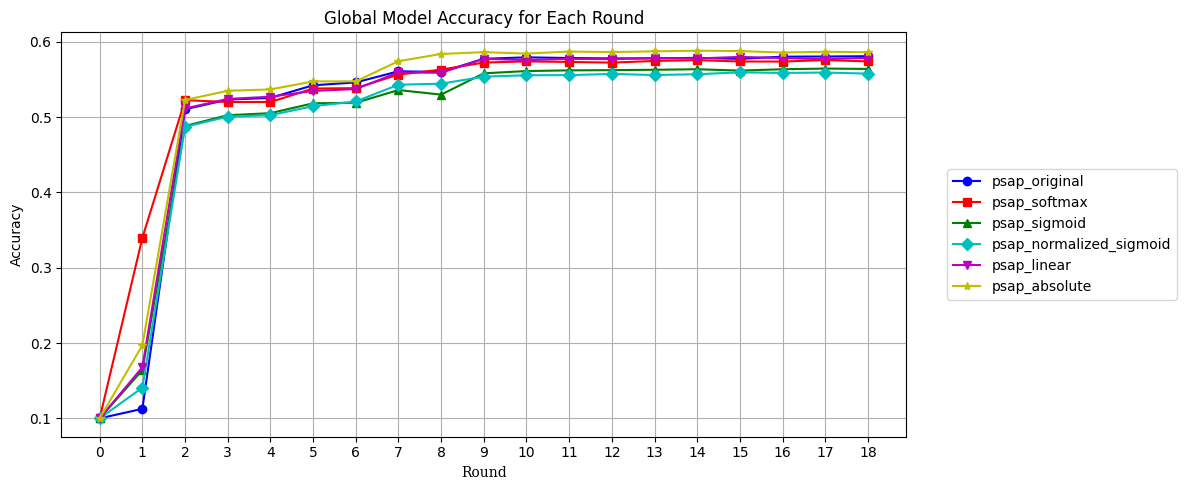

In [32]:
plot_accuracy_per_round(pseudo_gradient_similarity_avg_results)

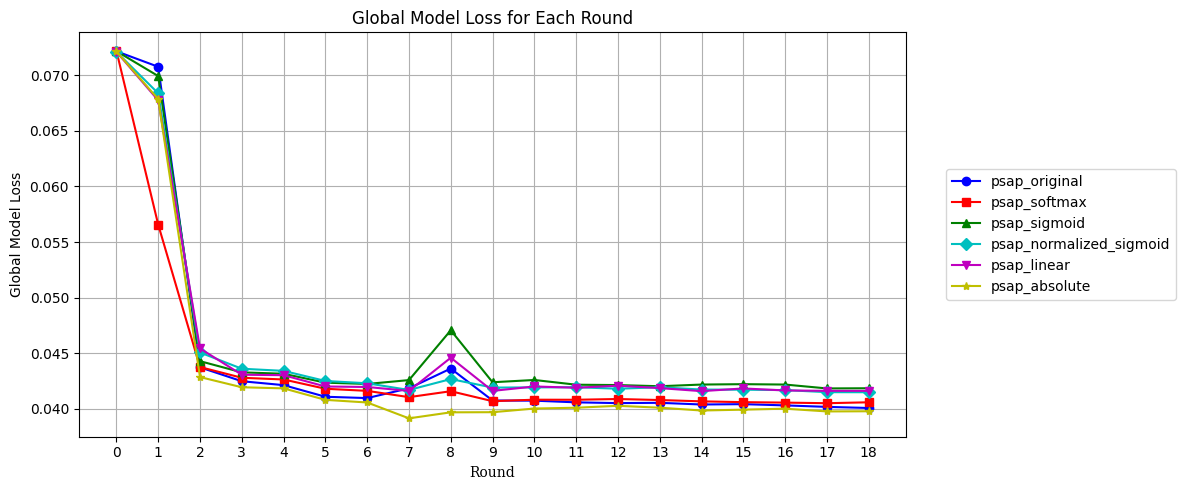

In [33]:
plot_loss_per_round(pseudo_gradient_similarity_avg_results)

In the case of pseud-gradient based cosine similarity weighting strategies, the absolute weighting model seems to offer the best performance based on accuracy and loss plots. However, it is important to note that all of the weighting mechanisms seem to perform better than their momentum based counterparts as well as that their results are relatively close to each other. Furthermore, their results are also relatively close to the FedAvg and FedPartAvg strategies.

### Communication cost 

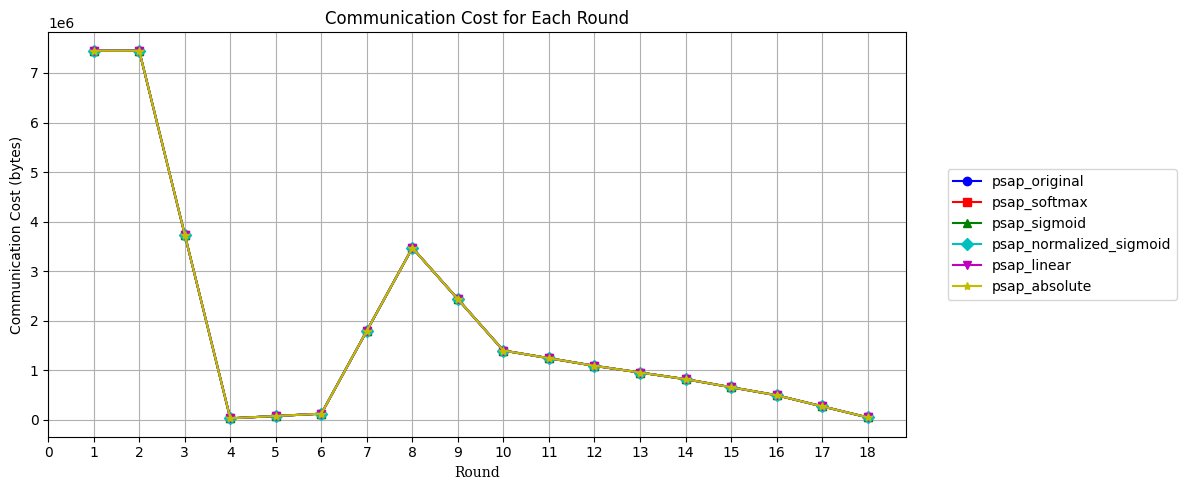

In [34]:
plot_communication_cost_per_round(pseudo_gradient_similarity_avg_results)

Similarly to the pseudo-gradient update approach, the strategies presented only use the model parameters hence the communication cost patter is the same as FedPartAvg.

### Parameter Differences Across Rounds













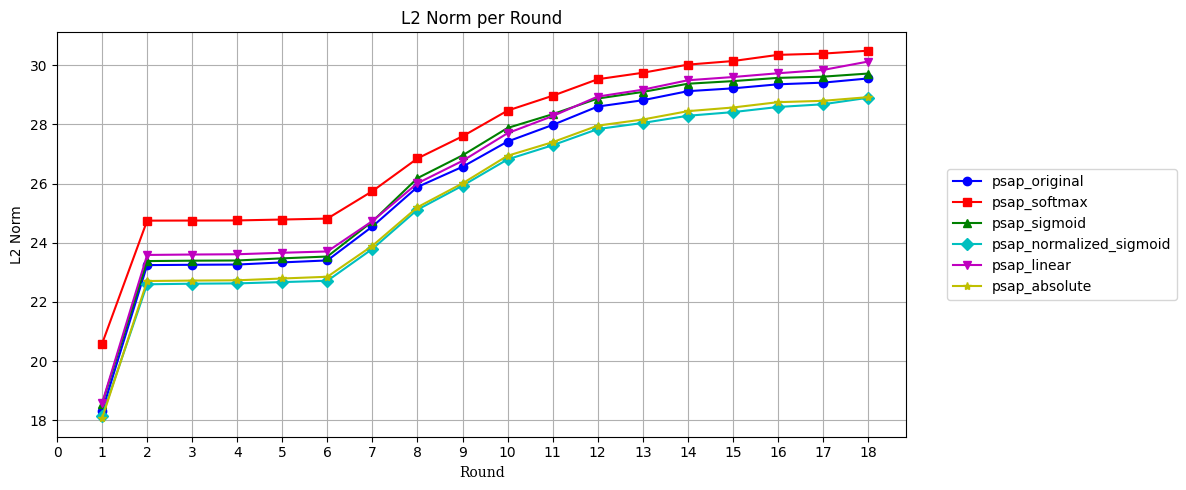

In [35]:
plot_l2_norm_per_round(pseudo_gradient_similarity_avg_results)

The L2 norm across rounds for the strategies present much smaller values than the ones presented in the momentum based strategies from which we can assume the issue potentially stems from the momentum updates rather than the cosine similarity based weighting of parameters. However it is also worth to mention that since in the first round a normal average pseudo-gradient based update is performed and not a weighted aggregation, the effect of the early model dissimilarity is not present in the system. Consequently, the L2 norm of the strategies exhibit a much smaller values than the momentum based strategies. Furthermore, curves closely follow the pseudo-gradient update based strategy's except many of them are slightly lower which can also contribute to the better accuracy.

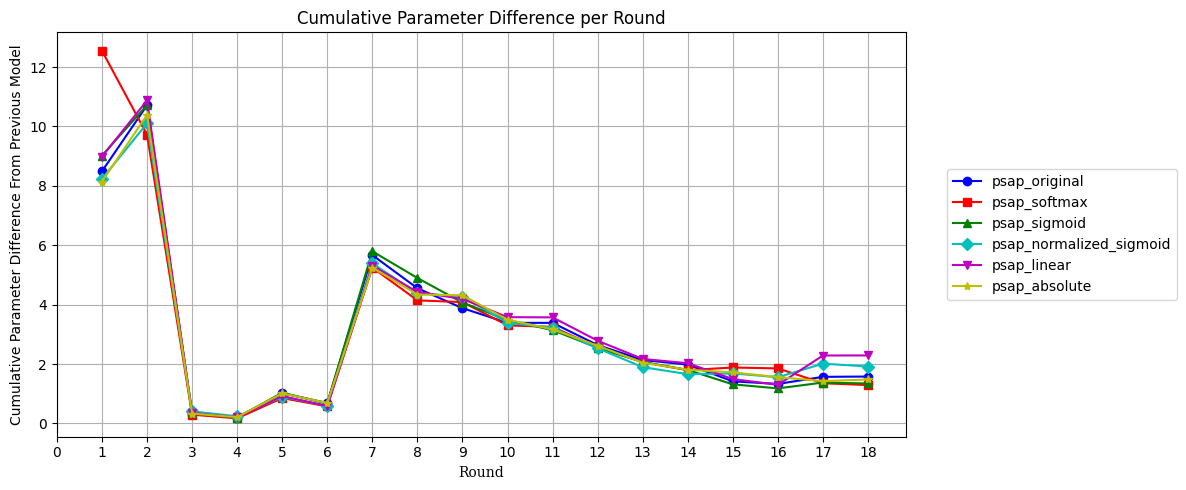

In [36]:
plot_parameter_difference_per_round(pseudo_gradient_similarity_avg_results)

When it comes to parameter and cosine similarity difference across rounds for the central model parameters, we can see minimal difference between the strategies. This is likely due to the fact the using the cosine similarity of pseudo-gradient are less sensitive to the changes in the parameters compared to the cosine similarity of the momentums where the momentum values can fluctuate more through the rounds.

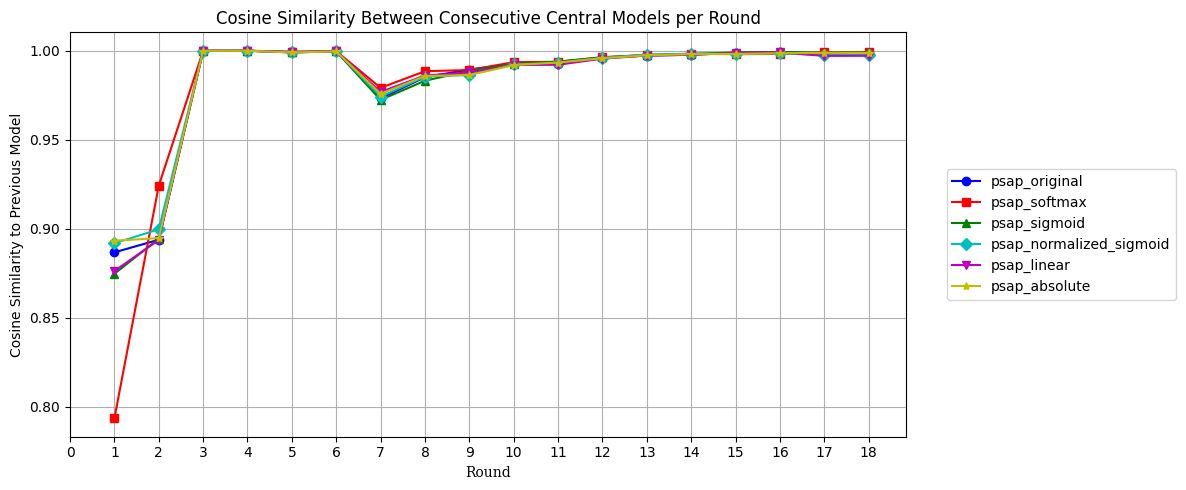

In [37]:
plot_cosine_similarity_per_round(pseudo_gradient_similarity_avg_results)

### Save the results to pickle files

In [38]:
pickle.dump(pseudo_gradient_similarity_avg_results, open(f"{experiment_type}_pseudogradient_similarity_avg.pkl", 'wb'))

all_results.update(pseudo_gradient_similarity_avg_results)

# Local Adam

The Local Adam based strategy simply adapts the momentum sharing method proposed by Cheng et al. ([2025](https://arxiv.org/abs/2409.13155)) into the FedPart strategy without any additional changes to the aggregation or update process other than the layer-wise behaviour.

## FedAvg with Local Adam

In [83]:
from src.LocalAdam.FedAvg.strategy import FedPartAdam
from src.LocalAdam.FedAvg.client import get_local_adam_fed_part_avg_client_fn

In [84]:
fedpart_local_adam_avg_client_fn = get_local_adam_fed_part_avg_client_fn(load_datasets)
client = ClientApp(client_fn=fedpart_local_adam_avg_client_fn)
model = Net().to(DEVICE)
_, _, testloader = load_datasets(0, NUM_PARTITIONS)
evaluate_fn = get_evaluate_fn(testloader, model)
fedpart_local_adam_avg_strategy= FedPartAdam(evaluate_fn=evaluate_fn)

def fedpart_local_adam_avg_server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=fedpart_local_adam_avg_strategy,
    )

server = ServerApp(server_fn=fedpart_local_adam_avg_server_fn)


run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=BACKEND_CONFIG,
)

/Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


[DEBUG] Initialized parameters with 16 model parameters
[DEBUG] Model architecture: [(6, 3, 5, 5), (6,), (16, 6, 5, 5), (16,), (180, 400), (180,), (160, 180), (160,), (140, 160), (140,), (120, 140), (120,), (84, 120), (84,), (10, 84), (10,)]
  Evaluation results - Loss: 0.0722, Accuracy: 0.1000
(ClientAppActor pid=93804) [Client 2] initialized


(ClientAppActor pid=93804) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93804)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93804) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93804) [DEBUG] Model patch length: 16
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93804) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93804) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93804) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93804) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93804) L

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
(ClientAppActor pid=93803) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93803) [Client 0] initialized
(ClientAppActor pid=93803) Epoch 8/8: train_loss 1.51626, accuracy 0.4016 [repeated 3x across cluster]
(ClientAppActor pid=93803) Local Adam training finished.
(ClientAppActor pid=93803) [Client 0] evaluate


(ClientAppActor pid=93801) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93801) [DEBUG] Model patch length: 16
(ClientAppActor pid=93801) [Client 1] initialized [repeated 6x across cluster]
(ClientAppActor pid=93798) [Client 5] evaluate [repeated 5x across cluster]


(ClientAppActor pid=93801) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93801)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93800) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93800) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93800) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93800) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93800) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93800) Layer 15 (fc7.bias) is trainable
(ClientAppActor pid=93800)

(ClientAppActor pid=93798) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.


(ClientAppActor pid=93801) Epoch 1/8: train_loss 1.93010, accuracy 0.2278
(ClientAppActor pid=93803) [DEBUG] Model patch length: 16 [repeated 5x across cluster]
(ClientAppActor pid=93803) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=93803) Layer 15 (fc7.bias) is trainable [repeated 80x across cluster]
(ClientAppActor pid=93803) Starting explicit Local Adam training for 8 epochs... [repeated 5x across cluster]
(ClientAppActor pid=93800) Epoch 2/8: train_loss 1.70339, accuracy 0.3447 [repeated 7x across cluster]
(ClientAppActor pid=93802) Epoch 3/8: train_loss 1.52042, accuracy 0.4230 [repeated 8x across cluster]
(ClientAppActor pid=93801) Epoch 5/8: train_loss 1.41001, accuracy 0.4683 [repeated 9x across cluster]
(ClientAppActor pid=93802) Epoch 6/8: train_loss 1.21676, accuracy 0.5504 [repeated 9x across cluster]
(ClientAppActor pid=93801) Local Adam training finished.
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.12262, accuracy 0.5725 [repeated 9x acro

(ClientAppActor pid=93800) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


total size: 22345608
  Evaluation results - Loss: 0.0507, Accuracy: 0.3949
(ClientAppActor pid=93801) [Client 3] initialized
(ClientAppActor pid=93801) [Client 3] evaluate
(ClientAppActor pid=93803) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93803) Epoch 8/8: train_loss 1.17805, accuracy 0.5567 [repeated 5x across cluster]


(ClientAppActor pid=93802) WARNING :   The `ParametersRecord` class has been renamed to `ArrayRecord`. Support for `ParametersRecord` will be removed in a future release. Please update your code accordingly.
(ClientAppActor pid=93801) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93801)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93798) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93798)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93802) [DEBUG] Model patch length: 16
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93802) Layer 15 (fc7.bias) is frozen
(ClientApp

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93801) [DEBUG] Model patch length: 6
(ClientAppActor pid=93801) Layer 0 (conv1.weight) is trainable
(ClientAppActor pid=93801) Layer 1 (conv1.bias) is trainable
(ClientAppActor pid=93801) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93801) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93801) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93801) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93801) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93801) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93801) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93801) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93801) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93801) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93801) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93801) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93801) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93802) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93798) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is trainable
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is trainable
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.

(ClientAppActor pid=93801) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93801)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93802) Epoch 1/8: train_loss 1.40443, accuracy 0.4833
(ClientAppActor pid=93801) [DEBUG] Model patch length: 6 [repeated 5x across cluster]
(ClientAppActor pid=93801) Layer 15 (fc7.bias) is frozen [repeated 70x across cluster]
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is trainable [repeated 10x across cluster]
(ClientAppActor pid=93801) Starting explicit Local Adam training for 8 epochs... [repeated 5x across cluster]
(ClientAppActor pid=93804) Epoch 3/8: train_loss 1.45418, accuracy 0.4719 [repeated 16x across cluster]
(ClientAppActor pid=93802) Epoch 6/8: train_loss 1.36903, accuracy 0.4958 [repeated 14x across cluster]
(ClientAppActor pid=93802) Local Adam training finished.
total size: 11259804
  Evaluation results - Loss: 0.0474, Accuracy: 0.4498
(ClientAppActor pid=93800) [Client 2] initialized
(ClientAppActor pid=93800) [Client 2] evaluate
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.43178, accuracy 0.4644 [repeated 17x across cluster]
(ClientAppA

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93798) [DEBUG] Model patch length: 6
(ClientAppActor pid=93798) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93798) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93798) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93798) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93798) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93798) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93798) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93798) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93798) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93798) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93798) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93798) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93798) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93798) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93798) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93798) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93800) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is trainable
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is trainable
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93800) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93800) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93800) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93800) Layer 14 (fc7.

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93803) [Client 5] initialized
(ClientAppActor pid=93803) [Client 5] evaluate
(ClientAppActor pid=93804) Epoch 8/8: train_loss 0.87144, accuracy 0.6993 [repeated 17x across cluster]
(ClientAppActor pid=93804) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93800) [DEBUG] Model patch length: 6
(ClientAppActor pid=93800) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is frozen
(ClientAppAct

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93803) [Client 2] initialized
(ClientAppActor pid=93803) [Client 2] evaluate
(ClientAppActor pid=93804) Epoch 8/8: train_loss 1.07510, accuracy 0.6156 [repeated 11x across cluster]
(ClientAppActor pid=93804) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is trainable
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is trainable
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is frozen
(ClientAppAct

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93800) [DEBUG] Model patch length: 6
(ClientAppActor pid=93800) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93800) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93800) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93800) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93800) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93800) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93800) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93800) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93800) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93800) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93800) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93800) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93800) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93800) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93800) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93800) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93803) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93803)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93800) [Client 5] initialized
(ClientAppActor pid=93800) [Client 5] evaluate
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.03229, accuracy 0.6227 [repeated 11x across cluster]
(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is trainable
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is trainable
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is frozen
(ClientAppAct

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93798) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) [DEBUG] Model patch length: 6
(ClientAppActor pid=93802) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93802) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93802) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93802) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93802) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93802) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93802) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93802) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93802) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93802) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93802) Layer 10 (fc4.weight) is trainable
(ClientAppActor pid=93802) Layer 11 (fc4.bias) is trainable
(ClientAppActor pid=93802) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93802) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93802) Layer 14 (fc7.

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93803) [Client 2] initialized
(ClientAppActor pid=93803) [Client 2] evaluate
(ClientAppActor pid=93800) Epoch 8/8: train_loss 1.04509, accuracy 0.6170 [repeated 11x across cluster]
(ClientAppActor pid=93800) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93803) [DEBUG] Model patch length: 6
(ClientAppActor pid=93803) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93803) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93803) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93803) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93803) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93803) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93803) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93803) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93803) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93803) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93803) Layer 10 (fc4.weight) is trainable
(ClientAppActor 

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.11823, accuracy 0.5861 [repeated 5x across cluster]
(ClientAppActor pid=93801) [DEBUG] Model patch length: 6
(ClientAppActor pid=93801) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93801) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93801) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93801) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93801) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93801) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93801) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93801) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93801) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93801) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93801) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93801) Layer 12 (fc5.weight) is trainabl

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93801) [DEBUG] Model patch length: 6
(ClientAppActor pid=93801) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93801) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93801) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93801) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93801) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93801) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93801) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93801) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93801) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93801) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93801) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93801) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93801) Layer 12 (fc5.weight) is trainable
(ClientAppActor pid=93801) Layer 13 (fc5.bias) is trainable
(ClientAppActor pid=93801) Layer 14 (fc7.weight) is frozen
(ClientAppActor pid=93801) Layer 15 (fc7.bias) is frozen
(ClientAppA

(ClientAppActor pid=93802) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93802)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93802) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93802) Epoch 8/8: train_loss 1.11461, accuracy 0.5943 [repeated 5x across cluster]
(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93804) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93804) Layer 12 (fc5.weight) is frozen
(

(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93804) [DEBUG] Model patch length: 6
(ClientAppActor pid=93804) Layer 0 (conv1.weight) is frozen
(ClientAppActor pid=93804) Layer 1 (conv1.bias) is frozen
(ClientAppActor pid=93804) Layer 2 (conv2.weight) is frozen
(ClientAppActor pid=93804) Layer 3 (conv2.bias) is frozen
(ClientAppActor pid=93804) Layer 4 (fc1.weight) is frozen
(ClientAppActor pid=93804) Layer 5 (fc1.bias) is frozen
(ClientAppActor pid=93804) Layer 6 (fc2.weight) is frozen
(ClientAppActor pid=93804) Layer 7 (fc2.bias) is frozen
(ClientAppActor pid=93804) Layer 8 (fc3.weight) is frozen
(ClientAppActor pid=93804) Layer 9 (fc3.bias) is frozen
(ClientAppActor pid=93804) Layer 10 (fc4.weight) is frozen
(ClientAppActor pid=93804) Layer 11 (fc4.bias) is frozen
(ClientAppActor pid=93804) Layer 12 (fc5.weight) is frozen
(ClientAppActor pid=93804) Layer 13 (fc5.bias) is frozen
(ClientAppActor pid=93804) Layer 14 (fc7.weight) is trainable
(ClientAppActor pid=93804) Layer 15 (fc7.bias) is trainable
(ClientAppA

(ClientAppActor pid=93798) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93798)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93804) [Client 5] initialized
(ClientAppActor pid=93804) [Client 5] evaluate
(ClientAppActor pid=93801) Epoch 8/8: train_loss 1.11709, accuracy 0.5982 [repeated 11x across cluster]
(ClientAppActor pid=93801) Local Adam training finished. [repeated 5x across cluster]
(ClientAppActor pid=93800) [Client 0] initialized [repeated 5x across cluster]
(ClientAppActor pid=93800) [Client 0] evaluate [repeated 5x across cluster]


(ClientAppActor pid=93800) /Users/macbook/Desktop/L46/L46_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=93800)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [85]:
fedpart_local_adam_avg_results=fedpart_local_adam_avg_strategy.get_results()
local_adam_results['fedpart_local_adam_avg'] = fedpart_local_adam_avg_results

## Summary

### Accuracy and Loss per Round

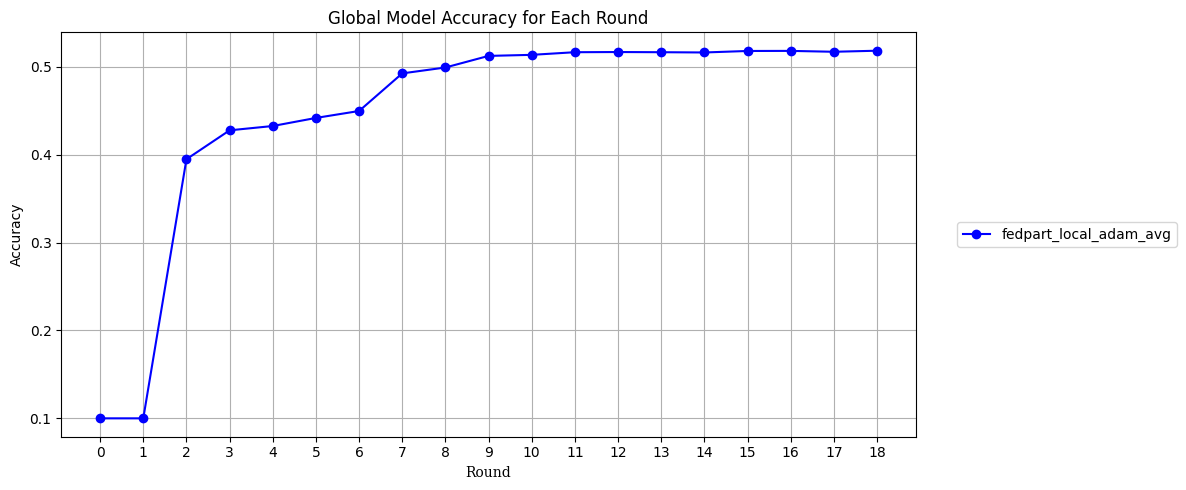

In [39]:
plot_accuracy_per_round(local_adam_results)

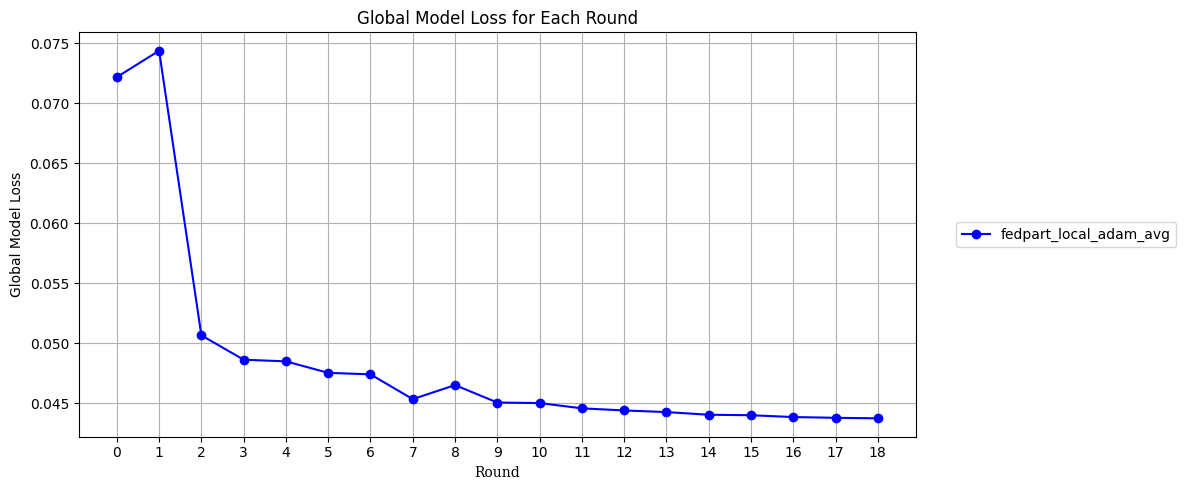

In [40]:
plot_loss_per_round(local_adam_results)

Comparing the results of the per round accuracy and loss plots to the ones presented by the FedAvgMom2 and FedAvgMom1 strategies, the adapted Local-Adam strategy to FedPart presents in a worse final accuracy then the best of the momentum based strategies. Which shows that cosine similarity based weighting can improve on momentum based layer-wise training strategies.

### Communication cost 

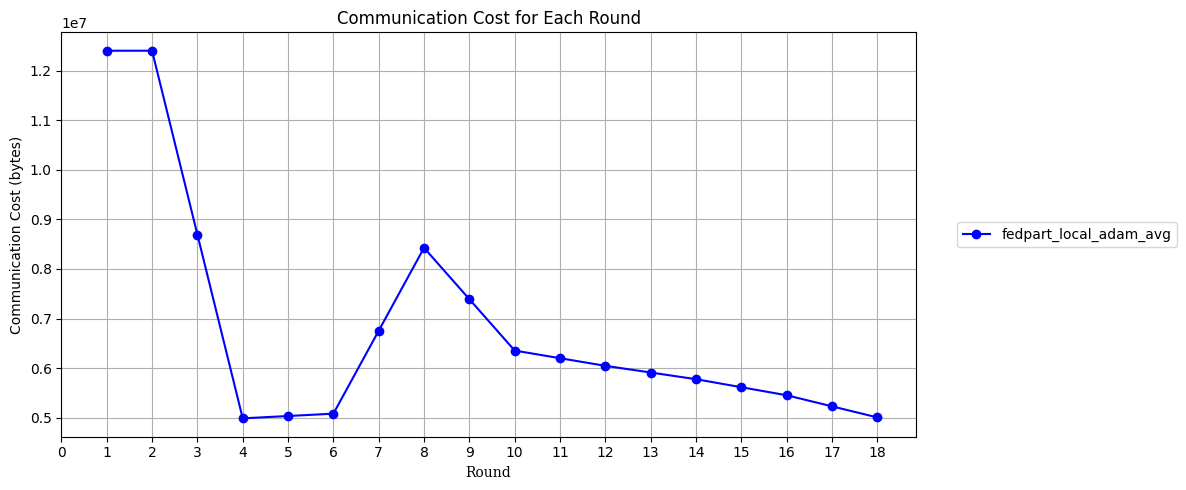

In [41]:
plot_communication_cost_per_round(local_adam_results)

Using Local Adam has the the same communication cost and pattern as FedAvgMom2 and FedAvgMom1 due to the optimiser states being shared between the clients and the server.

### Parameter Differences Across Rounds













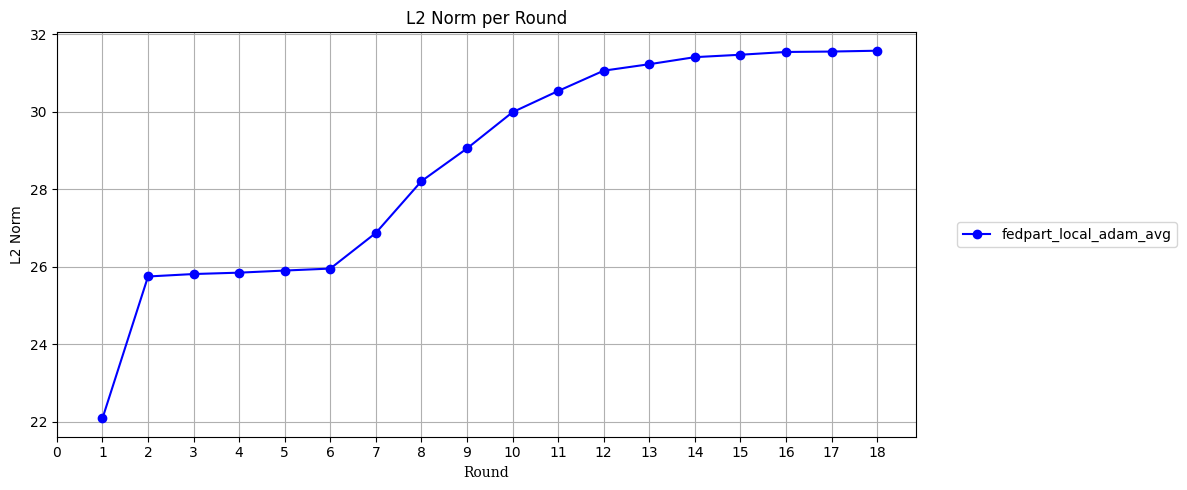

In [42]:
plot_l2_norm_per_round(local_adam_results)

The strategy interestingly presents an almost identical curve to the pseudo-gradient update based strategy as well as presents a similar behaviour for per round parameter difference and cosine similarity. Indicating that pseudo-gradient update based approach might be a cheaper alternative to the local adam based approach.

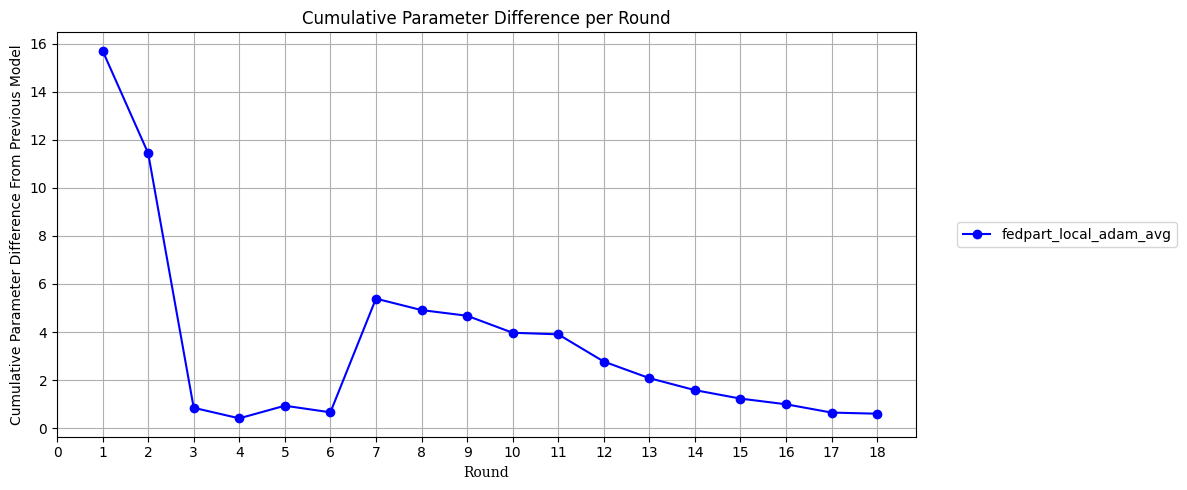

In [43]:
plot_parameter_difference_per_round(local_adam_results)

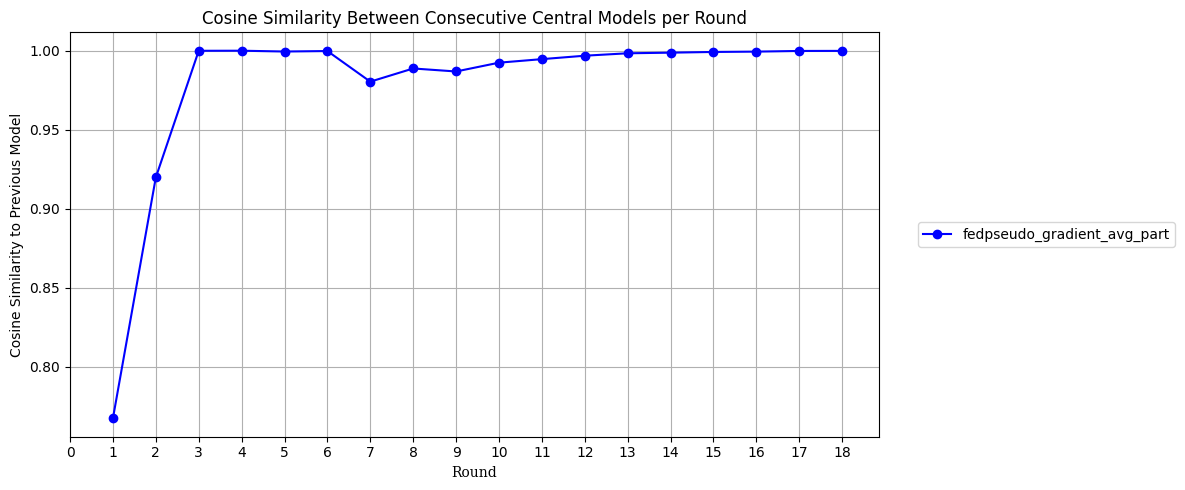

In [44]:
plot_cosine_similarity_per_round(pseudo_gradient_results)

### Save the results to pickle files

In [52]:
pickle.dump(local_adam_results, open(f"{experiment_type}_local_adam_results.pkl", 'wb'))
all_results.update(local_adam_results)

# Analysis

In this section we compare and contrast the best performing strategy variants selected from the previous experiments. Based on the best accuracy score achieved we select the weighting variant of the strategy (if there are multiple) and compare it to the other strategies. The selected strategies are:

- FedAvg (fedavg)
- FedPartAvg (fedpartavg)
- FedAvgMom2 using original weighting (fedavg_mom2_original)
- FedAvgMom1 using sigmoid weighting (fedavg_mom1_sigmoid)
- Local Adam in FedPart using FedAvg (fedpart_local_adam_avg)
- PseudoGradient Avg Update (fedpseudo_gradient_avg_part)
- PseudoGradient Similarity Part Avg absolute weighting (psap_absolute)


In [7]:
analysis_results = {}
for key, value in all_results["baseline"].items():
    analysis_results[key] = value

analysis_results["fedavg_mom2_original"] = fedavg_mom2_results["fedavg_mom2_original"]
analysis_results["fedavg_mom1_sigmoid"] = fedavg_mom1_results["fedavg_mom1_sigmoid"]
analysis_results["fedpseudo_gradient_avg_part"]= pseudo_gradient_results["fedpseudo_gradient_avg_part"]
analysis_results["psap_absolute"] = pseudo_gradient_similarity_avg_results["psap_absolute"]
analysis_results["fedpart_local_adam_avg"] = local_adam_results["fedpart_local_adam_avg"]


## Accuracy and Loss Comparison

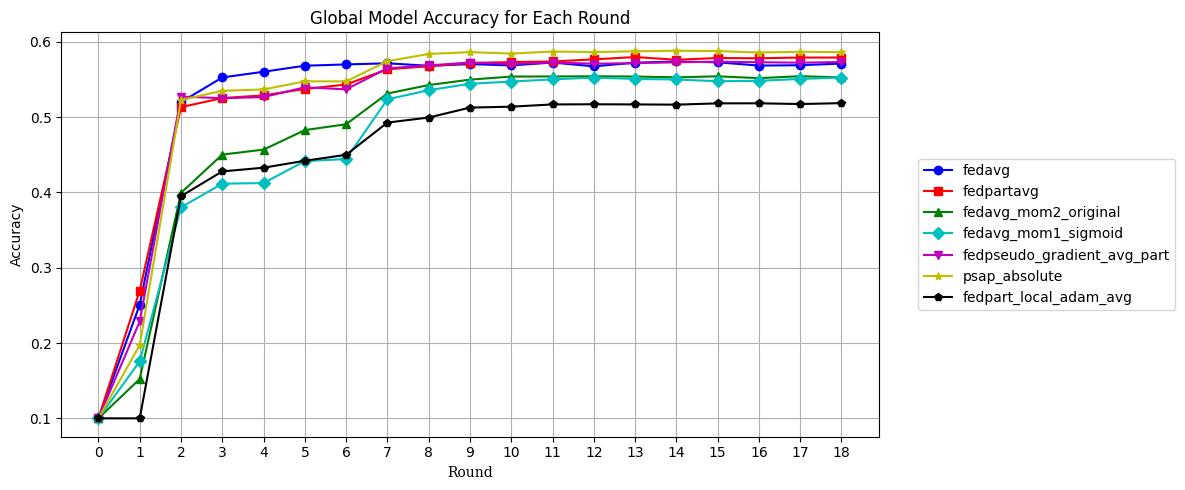

In [46]:
plot_accuracy_per_round(analysis_results)

From the accuracy values we can see that the best performing strategy under ideal conditions is the pseudo-gradient similarity based strategy using absolute weighting. We can also see that none of the momentum based strategies were able to outperform FedAVg or FedPartAvg. The only strategies that were capable of achieving better accuracy then FedAvg are the ones based on pseudo-gradient based similarity weighting or update and FedPartAvg.

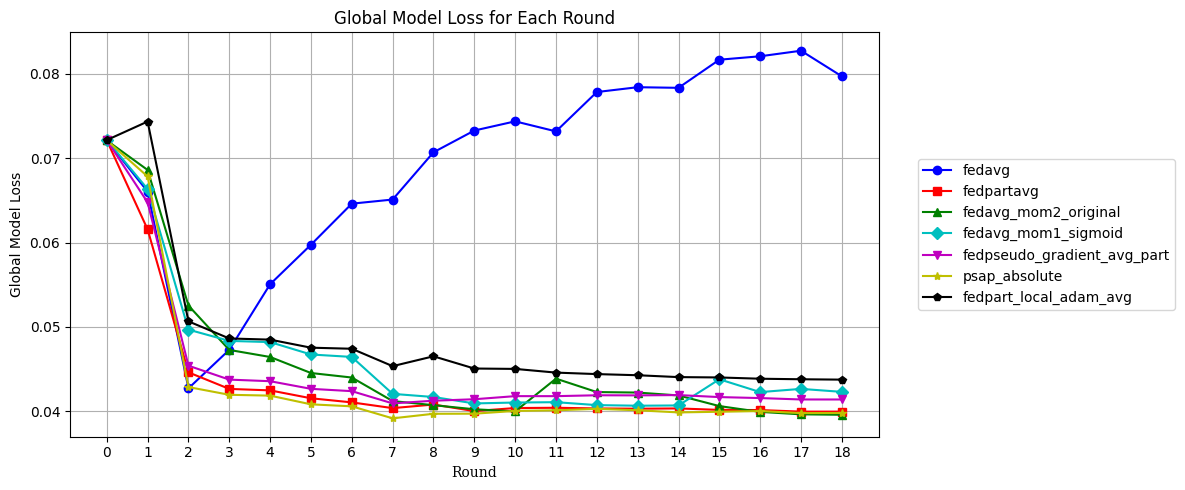

In [47]:
plot_loss_per_round(analysis_results)

## Communication Cost

Since the weight variants within the same strategy exhibit similar communication pattern we represent them as their strategy here to avoid redundancy.

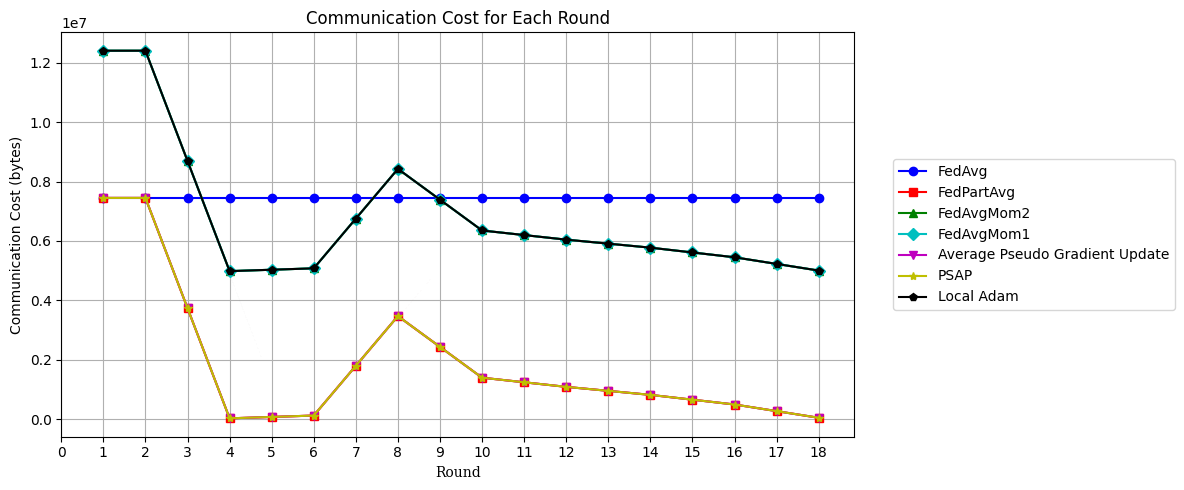

In [9]:
plot_communication_cost_per_round(analysis_results, show_strategy_names=True)

When it comes to communication cost we can observe an increase in both total and per layer communication cost when it comes to the momentum based strategies compared to the non-momentum based strategies except FedAvg. This is expected as the momentum based strategies share not just the client parameters but their optimizer states as well. Consequently, resulting in a higher communication cost, sometimes even exceeding the communication cost of FedAvg on per round basis.

Moreover we can see that the non-momentum based FedPart strategies have a much  lower communication cost  (except the warm up rounds) due to the fact that they only share the client parameters of the most recently trained layer rather than the entire model parameters.

/Users/macbook/Desktop/L46/L46_Project/src/visualize_data.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')


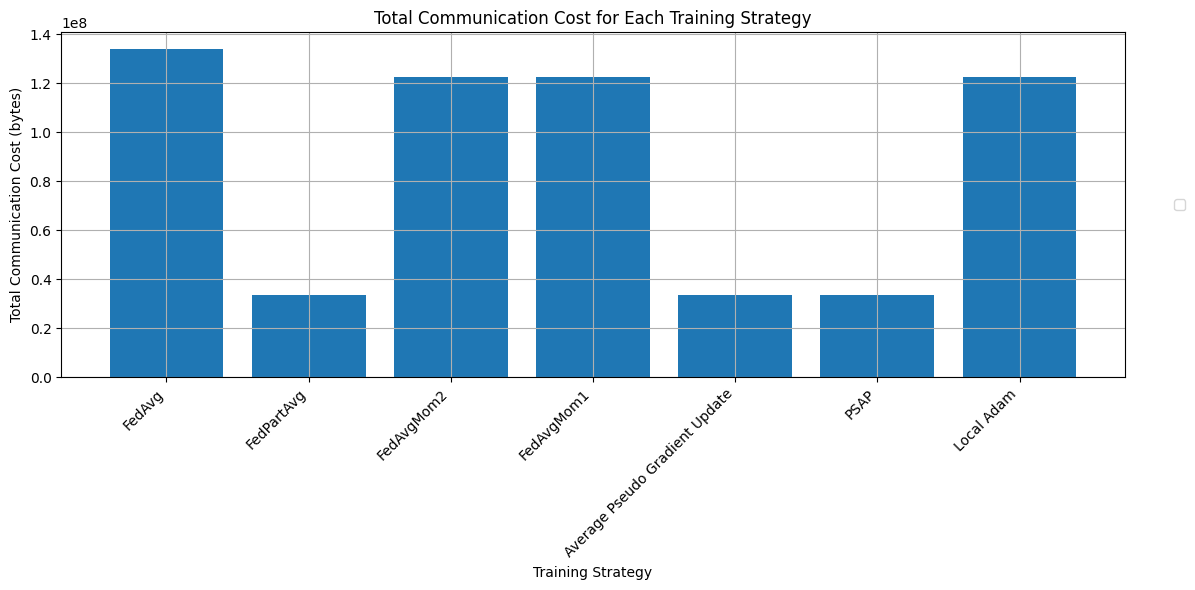

In [10]:
plot_total_communication_cost_bar_chart(analysis_results)


The communication cost bar chart shows the clear trade off between the various strategies further presenting the advantage of pseudo-gradient based strategies compared to momentum based ones or full FedAvg.

## Parameter Differences 

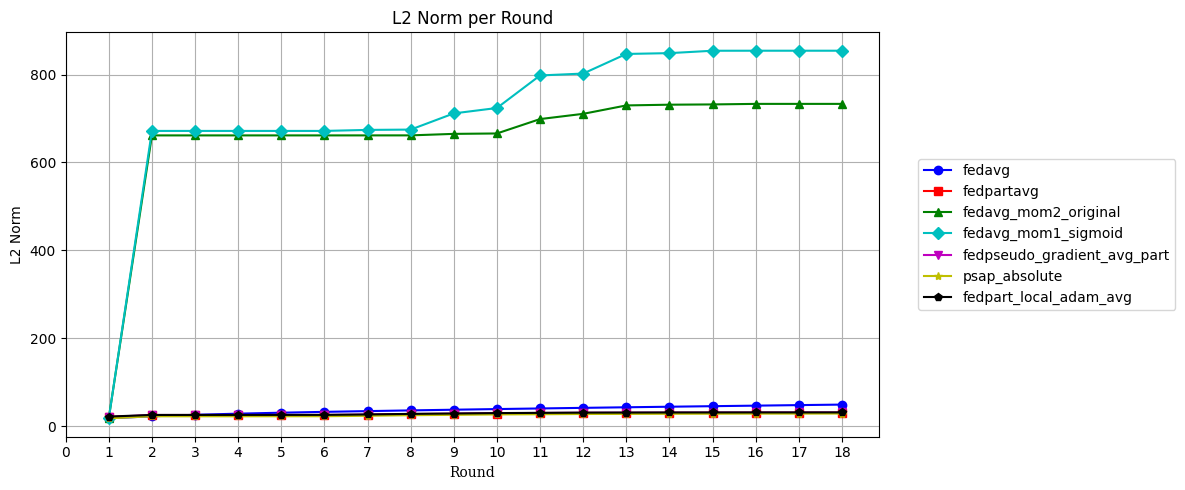

In [50]:
plot_l2_norm_per_round(analysis_results)

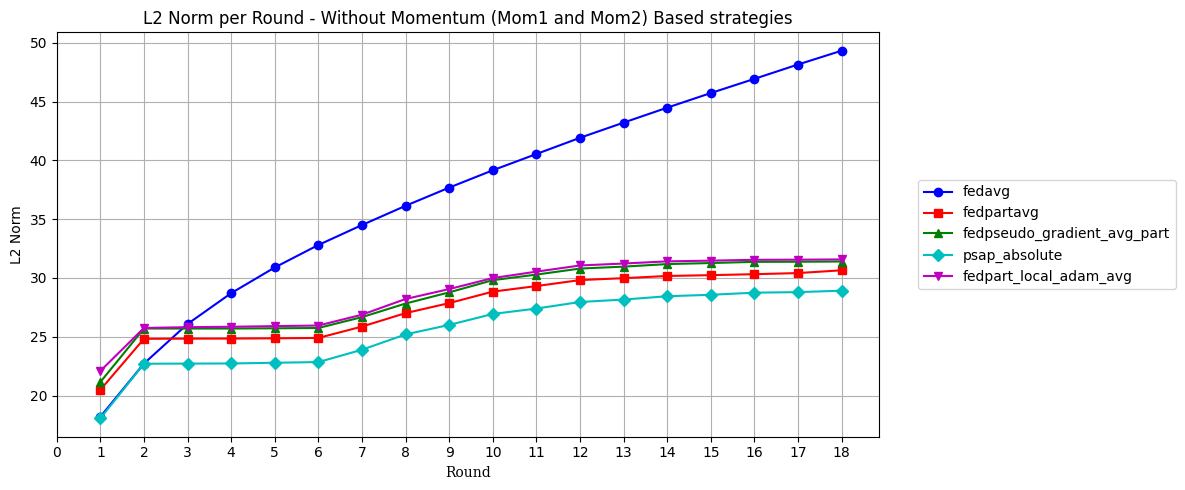

In [51]:
analysis_results_without_momentums = analysis_results.copy()

analysis_results_without_momentums.pop('fedavg_mom1_sigmoid')
analysis_results_without_momentums.pop('fedavg_mom2_original')
plot_l2_norm_per_round(analysis_results_without_momentums, modified_label="Without Momentum (Mom1 and Mom2) Based strategies")

The dramatic increase in per round L2 norm and parameter difference show us that using cosine similarity can result in an explosion of the L2 norm and parameter changes. The Local-Adam based strategy though uses momentum aggregation but it only averages the momentum values rather then weighting them based on the cosine similarity to the central aggregated momentum of the previous round. As shown on the above figures the Local-Adam based strategy has a much lower L2 norm and parameter difference (figures below), similar to the non-momentum based strategies. However, this can be potentially the result of the cosine similarity weighting acting as correcting mechanism for client divergence by making client momentums more aligned with the central tendency but since in the early rounds they are so different this results in large changes in parameters and hence in significantly larger L2 norms.

Furthermore, we can also see a plateauing trend in the L2 norm for all strategies that are not FedAvg which is expected as the models are only partially being updated in each round. Although it does not necessarily mean that the models are not learning, but it is a good indicator and can suggest that the models are not learning as fast as the FedAvg strategy. However, it is important to mention that too large L2 norm values can also be a warning of over fitting or divergence of the models as discussed earlier.











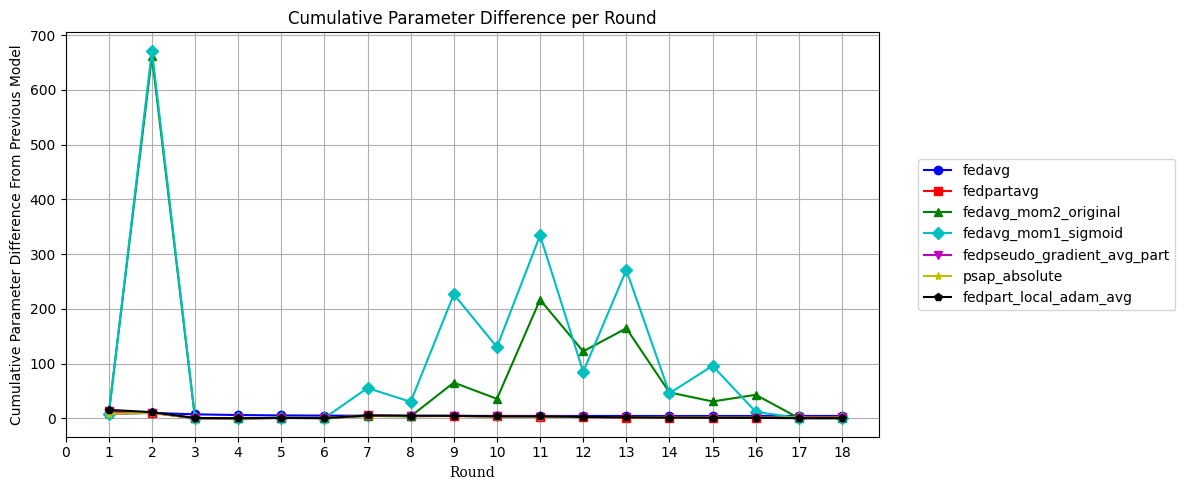

In [52]:
plot_parameter_difference_per_round(analysis_results)

Furthermore, looking at the per round parameter differences more closely (without Mom1 and Mom2 based strategies) we can see that the strategies follow a similar pattern that caused by a layer-wise training where deeper,more dense layer cause larger differences between consecutive central model updates and hence have larger effect on the convergence as well.



















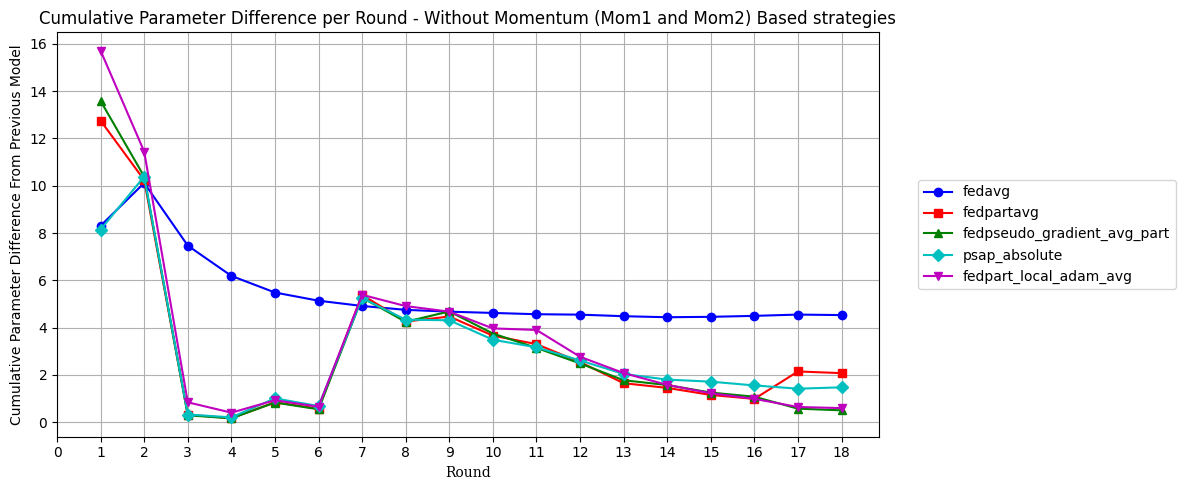

In [53]:
plot_parameter_difference_per_round(analysis_results_without_momentums, modified_label="Without Momentum (Mom1 and Mom2) Based strategies")